In [1]:
import scipy as sp
import scipy.optimize
import numpy as np
import pandas as pd
import time
import matplotlib.pyplot as plt
from os.path import exists
from hashlib import sha256

from utils_fit import get_anchors_and_scores_mean_curve, convert_table2, remove_rows_with_nan_or_inf, load_from_parts, remove_bad_fits, failed_fits_statistics,  prepare_total_dataframe, plot_data2, plot_trn_data2, plot_prediction2, plot_prediction_smooth2, get_fun_model_id, get_XY2, get_ranks_from_tables, build_rank_table, convert_to_cd_tables, filter_table, prepare_data_for_cd, make_all_cd_plots, print_pretty_rank_table_transpose, plot_metric, get_relevant_max_anchor, empirical_cdf
from fit_database_BFGS import fit_model, get_multiple_extrapolations_mean_curve_robust, df_compute_metrics_mean_curve

dir_plots = 'plots_BFGS'
dir_fitting_results = 'fitting_results_BFGS'

In [2]:
[df_anchors_and_scores, df_metrics, df_extrapolations] = load_from_parts(dir_fitting_results)
df_total = prepare_total_dataframe(df_anchors_and_scores, df_metrics, df_extrapolations)
df_total.to_pickle(fn_df_total, protocol=3)

  0%|          | 0/246 [00:00<?, ?it/s]

NameError: name 'fn_df_total' is not defined

visualizing the curve fit of row number 702958


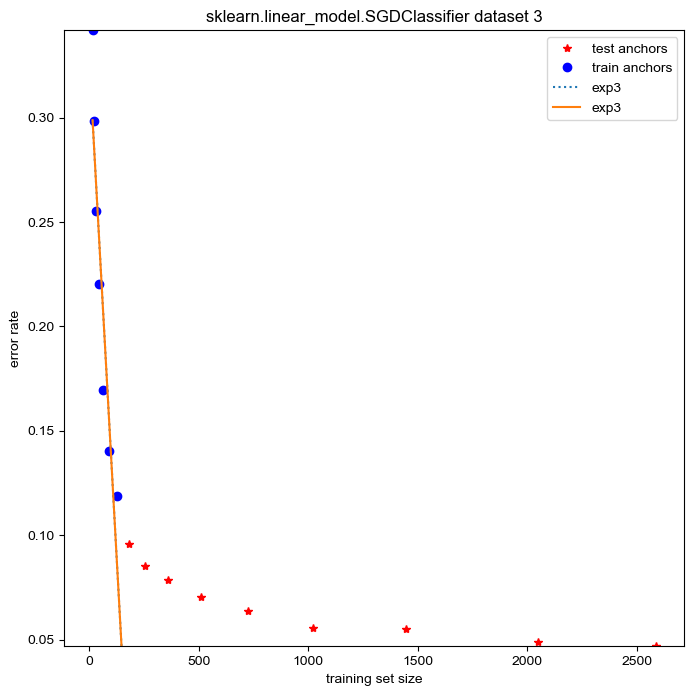

openmlid                                                             3
learner                             sklearn.linear_model.SGDClassifier
max_anchor_seen                                                    128
prediction           [0.7011989284060292, 0.7145486895699378, 0.731...
beta                 [654.896668185694, -2.9119104485842573e-06, -6...
fails_init                                                           0
fails_fit                                                            0
MSE_trn                                                       0.000788
MSE_tst                                                       5.124252
MSE_tst_last                                                 21.822181
L1_trn                                                        0.025585
L1_tst                                                        1.679227
L1_tst_last                                                   4.671422
n                                                                    7
curve_

In [3]:
num = np.random.randint(0,len(df_total))
row = df_total.iloc[2175,:]

print('visualizing the curve fit of row number %d' % num)

plt.figure(figsize=(8,8))

# plots all the points on the curve (red stars)
plot_data2(row)

# plots the points used for training only (blue dots)
plot_trn_data2(row)

# plot the curve fit from the row of the dataframe (dotted)
plot_prediction2(row)

# plot the curve fit using the beta parameters in the dataframe (line)
# this plot is smoother since we can predict any x-value
# this curve should overlap with the curve plotted previously
plot_prediction_smooth2(row)

# show the plot
plt.show()

# show the information of the row
print(row)

In [4]:
# get the X and Y values
# X are training set sizes
# Y are accuracies
[X, Y] = get_XY2(row)

# we need to find the training and test set for the curve data, we do that through the offset
offset = np.argwhere(X == row.max_anchor_seen)[0][0]

# curve training data
X_trn_curve = np.array(X[:offset + 1])
Y_trn_curve = np.array(Y[:offset + 1])

# curve testing data
X_tst_curve = np.array(X[offset + 1:])
Y_tst_curve = np.array(Y[offset + 1:])

experiment_id = '%d-%s-%s-%d' % (row.openmlid,row.learner,row.curve_model,offset)

hash = sha256(experiment_id.encode())
seed = np.frombuffer(hash.digest(), dtype='uint32')
np.random.seed(seed)

# fit the curve model again
[beta_fit_new, fitted_curve_model_new, fails_init, fails_fit] = fit_model(X_trn_curve, Y_trn_curve, X_tst_curve, row.curve_model)

print('best beta found from fitting procedure:')
print(beta_fit_new)
print('the beta provided by the authors:')
print(row.beta)
#assert(beta_fit_new == row.beta)

best beta found from fitting procedure:
[-0.35594865  0.02677192  0.89210056]
the beta provided by the authors:
[ 6.54896668e+02 -2.91191045e-06 -6.54225982e+02]


In [5]:
# all the performances
df_performances = pd.read_csv("database-accuracy.csv")

In [10]:
# only performances from dataset 1468
df_performances_one_dataset = df_performances.sample(n = 10000)
df_performances_one_dataset

,openmlid,learner,size_train,size_test,outer_seed,inner_seed,traintime,score_train,score_valid,score_test
1952530,1464,sklearn.linear_model.PassiveAggressiveClassifier,362,75,0,3,0.0011,0.7624,0.7647,0.7600
156450,23517,sklearn.linear_model.LogisticRegression,128,5000,2,1,0.0090,0.6484,0.5082,0.5042
1042806,42733,sklearn.naive_bayes.MultinomialNB,23,3995,3,3,0.0043,0.7826,0.8315,0.8315
651226,391,SVC_poly,1024,151,3,1,2.2339,0.6348,0.4779,0.5099
543020,1489,sklearn.discriminant_analysis.QuadraticDiscrim...,2896,541,4,3,0.0012,0.7863,0.8070,0.7763
...,...,...,...,...,...,...,...,...,...,...
847055,40664,sklearn.linear_model.LogisticRegression,45,173,1,3,0.0344,0.9333,0.7564,0.8035
324117,4134,sklearn.tree.DecisionTreeClassifier,3037,376,3,2,1.2459,1.0000,0.6982,0.7234
131109,901,SVC_poly,32,4077,1,4,0.0008,1.0000,0.7357,0.7366
855047,1216,sklearn.linear_model.SGDClassifier,32,5000,2,1,0.0011,0.8750,0.9550,0.9552


In [12]:
np.seterr(all='print')

rep = 5
start_time = time.time()
print('computing extrapolations...')
# compute the fits
df_extrapolations = get_multiple_extrapolations_mean_curve_robust(df_performances_one_dataset, rep, True)
df_extrapolations.to_pickle(dir_fitting_results + '/extrapolations_example.gz', protocol=3)

print('computing anchors and scores...')
# compute the X, Y values and store them for later use
df_anchors_and_scores = get_anchors_and_scores_mean_curve(df_performances_one_dataset)
df_anchors_and_scores.to_pickle(dir_fitting_results + '/anchors_scores_example.gz', protocol=3)

print('computing metrics....')
# compute the metrics and other information (L2 losses, etc.)
df_metrics = df_compute_metrics_mean_curve(df_extrapolations, df_anchors_and_scores)
df_metrics.to_pickle(dir_fitting_results + '/metrics_example.gz', protocol=3)
end_time = time.time()
total_time = end_time - start_time
total_time

computing extrapolations...





  0%|                                                 | 0/79360 [00:00<?, ?it/s]


  0%|                                      | 1/79360 [00:01<32:42:32,  1.48s/it]


  0%|                                      | 2/79360 [00:01<19:04:29,  1.16it/s]


  0%|                                      | 4/79360 [00:01<10:11:26,  2.16it/s]


  0%|                                       | 9/79360 [00:02<5:08:40,  4.28it/s]


  0%|                                      | 10/79360 [00:02<5:16:53,  4.17it/s]


  0%|                                      | 11/79360 [00:02<5:27:17,  4.04it/s]

initial value failed, retrying for  expp3
initial value failed, retrying for  expp3
initial value failed, retrying for  expp3
initial value failed, retrying for  expp3
initial value failed, retrying for  expp3
initial value failed, retrying for  expp3
initial value failed, retrying for  expp3
initial value failed, retrying for  expp3
initial value failed, retrying for  expp3
initial value failed, retrying for  expp3
fit failed, nan error? True inf error? False model? expp3
fit failed, nan error? True inf error? False model? expp3
initial value failed, retrying for  expp3
initial value failed, retrying for  expp3
initial value failed, retrying for  expp3
initial value failed, retrying for  expp3
initial value failed, retrying for  expp3





  0%|                                      | 13/79360 [00:03<5:10:18,  4.26it/s]


  0%|                                      | 15/79360 [00:03<4:45:02,  4.64it/s]

fit failed, nan error? True inf error? False model? expp3





  0%|                                      | 16/79360 [00:03<4:49:30,  4.57it/s]


  0%|                                      | 17/79360 [00:04<5:40:46,  3.88it/s]


  0%|                                      | 18/79360 [00:04<5:32:43,  3.97it/s]


  0%|                                      | 20/79360 [00:04<5:06:06,  4.32it/s]


  0%|                                      | 25/79360 [00:04<4:16:17,  5.16it/s]


  0%|                                      | 26/79360 [00:05<4:14:52,  5.19it/s]


  0%|                                      | 27/79360 [00:06<5:19:32,  4.14it/s]


  0%|                                      | 28/79360 [00:08<6:21:04,  3.47it/s]


  0%|                                      | 29/79360 [00:08<6:15:16,  3.52it/s]

fit failed, nan error? True inf error? False model? expp3





  0%|                                      | 32/79360 [00:08<5:47:33,  3.80it/s]


  0%|                                      | 33/79360 [00:13<9:04:45,  2.43it/s]


  0%|                                      | 34/79360 [00:14<9:23:17,  2.35it/s]


  0%|                                      | 35/79360 [00:14<9:14:08,  2.39it/s]


  0%|                                      | 38/79360 [00:14<8:35:25,  2.56it/s]


  0%|                                      | 41/79360 [00:15<8:07:20,  2.71it/s]


  0%|                                      | 42/79360 [00:15<8:17:53,  2.66it/s]


  0%|                                      | 43/79360 [00:16<8:37:34,  2.55it/s]


  0%|                                      | 44/79360 [00:17<8:49:23,  2.50it/s]

initial value failed, retrying for  expp3
initial value failed, retrying for  expp3
initial value failed, retrying for  expp3
fit failed, nan error? True inf error? False model? expp3
fit failed, nan error? True inf error? False model? expp3
initial value failed, retrying for  expp3
initial value failed, retrying for  expp3
fit failed, nan error? True inf error? False model? expp3
initial value failed, retrying for  expp3
fit failed, nan error? True inf error? False model? expp3
fit failed, nan error? True inf error? False model? expp3
initial value failed, retrying for  expp3
fit failed, nan error? True inf error? False model? expp3
initial value failed, retrying for  expp3
fit failed, nan error? True inf error? False model? expp3
fit failed, nan error? True inf error? False model? expp3
initial value failed, retrying for  expp3
initial value failed, retrying for  expp3





  0%|                                      | 45/79360 [00:18<8:53:18,  2.48it/s]


  0%|                                      | 47/79360 [00:18<8:34:11,  2.57it/s]

fit failed, nan error? True inf error? False model? expp3
initial value failed, retrying for  expp3
fit failed, nan error? True inf error? False model? expp3
initial value failed, retrying for  expp3





  0%|                                      | 48/79360 [00:18<8:31:19,  2.59it/s]


  0%|                                     | 49/79360 [00:34<15:39:20,  1.41it/s]


  0%|                                     | 50/79360 [00:37<16:25:07,  1.34it/s]


  0%|                                     | 51/79360 [00:37<16:11:19,  1.36it/s]


  0%|                                     | 53/79360 [00:37<15:37:36,  1.41it/s]


  0%|                                     | 57/79360 [00:38<14:41:24,  1.50it/s]


  0%|                                     | 58/79360 [00:39<15:07:15,  1.46it/s]


  0%|                                     | 59/79360 [00:41<15:23:33,  1.43it/s]


  0%|                                     | 60/79360 [00:42<15:44:24,  1.40it/s]

initial value failed, retrying for  expp3
initial value failed, retrying for  expp3
initial value failed, retrying for  expp3
initial value failed, retrying for  expp3
initial value failed, retrying for  expp3
initial value failed, retrying for  expp3
initial value failed, retrying for  expp3
initial value failed, retrying for  expp3
initial value failed, retrying for  expp3





  0%|                                     | 61/79360 [00:43<15:38:57,  1.41it/s]

fit failed, nan error? True inf error? False model? expp3
initial value failed, retrying for  expp3
initial value failed, retrying for  expp3
initial value failed, retrying for  expp3





  0%|                                     | 63/79360 [00:43<15:15:55,  1.44it/s]


  0%|                                     | 64/79360 [00:45<15:43:10,  1.40it/s]


  0%|                                     | 65/79360 [00:49<16:50:36,  1.31it/s]


  0%|                                     | 66/79360 [00:50<16:47:43,  1.31it/s]


  0%|                                     | 67/79360 [00:50<16:35:05,  1.33it/s]


  0%|                                     | 70/79360 [00:50<15:55:50,  1.38it/s]


  0%|                                     | 73/79360 [00:50<15:19:58,  1.44it/s]


  0%|                                     | 74/79360 [00:51<15:21:42,  1.43it/s]


  0%|                                     | 75/79360 [00:52<15:30:47,  1.42it/s]


  0%|                                     | 76/79360 [00:54<15:46:49,  1.40it/s]


  0%|                                     | 77/79360 [00:54<15:39:21,  1.41it/s]

initial value failed, retrying for  expp3
initial value failed, retrying for  expp3
fit failed, nan error? True inf error? False model? expp3
fit failed, nan error? True inf error? False model? expp3
initial value failed, retrying for  expp3
initial value failed, retrying for  expp3
initial value failed, retrying for  expp3
fit failed, nan error? True inf error? False model? expp3
initial value failed, retrying for  expp3
initial value failed, retrying for  expp3





  0%|                                     | 79/79360 [00:54<15:19:23,  1.44it/s]


  0%|                                     | 80/79360 [00:55<15:12:46,  1.45it/s]


  0%|                                     | 97/79360 [01:02<14:05:52,  1.56it/s]


  0%|                                     | 98/79360 [01:03<14:11:49,  1.55it/s]


  0%|                                     | 99/79360 [01:03<14:04:54,  1.56it/s]


  0%|                                    | 102/79360 [01:03<13:45:21,  1.60it/s]


  0%|                                    | 105/79360 [01:03<13:23:46,  1.64it/s]


  0%|                                    | 106/79360 [01:04<13:26:19,  1.64it/s]


  0%|                                    | 107/79360 [01:06<13:40:20,  1.61it/s]


  0%|                                    | 108/79360 [01:08<13:53:35,  1.58it/s]


  0%|                                    | 109/79360 [01:08<13:48:37,  1.59it/s]

initial value failed, retrying for  expp3
initial value failed, retrying for  expp3
initial value failed, retrying for  expp3





  0%|                                    | 111/79360 [01:08<13:38:34,  1.61it/s]


  0%|                                    | 112/79360 [01:09<13:43:18,  1.60it/s]


  0%|                                    | 113/79360 [01:11<14:00:08,  1.57it/s]


  0%|                                    | 114/79360 [01:12<13:56:51,  1.58it/s]


  0%|                                    | 116/79360 [01:12<13:43:35,  1.60it/s]


  0%|                                    | 121/79360 [01:12<13:11:55,  1.67it/s]


  0%|                                    | 122/79360 [01:12<13:08:32,  1.67it/s]


  0%|                                    | 123/79360 [01:13<13:04:37,  1.68it/s]


  0%|                                    | 124/79360 [01:13<12:59:50,  1.69it/s]


  0%|                                    | 125/79360 [01:13<12:55:53,  1.70it/s]

fit failed, nan error? True inf error? False model? expp3
initial value failed, retrying for  expp3
initial value failed, retrying for  expp3
initial value failed, retrying for  expp3
initial value failed, retrying for  expp3
initial value failed, retrying for  expp3
fit failed, nan error? True inf error? False model? expp3
fit failed, nan error? True inf error? False model? expp3





  0%|                                    | 128/79360 [01:13<12:40:03,  1.74it/s]


  0%|                                    | 129/79360 [01:14<12:40:03,  1.74it/s]


  0%|                                    | 131/79360 [01:14<12:29:58,  1.76it/s]


  0%|                                    | 137/79360 [01:14<11:58:32,  1.84it/s]


  0%|                                    | 138/79360 [01:14<11:54:20,  1.85it/s]


  0%|                                    | 139/79360 [01:15<11:52:53,  1.85it/s]


  0%|                                    | 140/79360 [01:15<11:53:07,  1.85it/s]


  0%|                                    | 141/79360 [01:15<11:49:50,  1.86it/s]

fit failed, nan error? True inf error? False model? expp3
initial value failed, retrying for  expp3
initial value failed, retrying for  expp3
fit failed, nan error? True inf error? False model? expp3
initial value failed, retrying for  expp3
fit failed, nan error? True inf error? False model? expp3
initial value failed, retrying for  expp3
initial value failed, retrying for  expp3
initial value failed, retrying for  expp3





  0%|                                    | 144/79360 [01:15<11:36:12,  1.90it/s]


  0%|                                    | 145/79360 [01:28<13:26:40,  1.64it/s]


  0%|                                    | 146/79360 [01:30<13:36:59,  1.62it/s]


  0%|                                    | 147/79360 [01:30<13:33:07,  1.62it/s]


  0%|                                    | 150/79360 [01:30<13:18:17,  1.65it/s]


  0%|                                    | 153/79360 [01:30<13:04:52,  1.68it/s]


  0%|                                    | 154/79360 [01:33<13:17:44,  1.65it/s]


  0%|                                    | 155/79360 [01:34<13:25:44,  1.64it/s]


  0%|                                    | 156/79360 [01:35<13:32:00,  1.63it/s]

initial value failed, retrying for  expp3
fit failed, nan error? True inf error? False model? expp3
initial value failed, retrying for  expp3





  0%|                                    | 157/79360 [01:36<13:30:03,  1.63it/s]

fit failed, nan error? True inf error? False model? expp3
fit failed, nan error? True inf error? False model? expp3





  0%|                                    | 159/79360 [01:36<13:22:48,  1.64it/s]


  0%|                                    | 160/79360 [01:37<13:27:47,  1.63it/s]


  0%|                                    | 177/79360 [01:39<12:19:33,  1.78it/s]


  0%|                                    | 178/79360 [01:39<12:16:56,  1.79it/s]


  0%|                                    | 183/79360 [01:39<11:57:29,  1.84it/s]


  0%|                                    | 185/79360 [01:39<11:50:29,  1.86it/s]


  0%|                                    | 186/79360 [01:39<11:48:22,  1.86it/s]


  0%|                                    | 187/79360 [01:39<11:45:24,  1.87it/s]


  0%|                                    | 189/79360 [01:40<11:39:37,  1.89it/s]

initial value failed, retrying for  expp3
initial value failed, retrying for  expp3
fit failed, nan error? True inf error? False model? expp3
fit failed, nan error? True inf error? False model? expp3
fit failed, nan error? True inf error? False model? expp3
fit failed, nan error? True inf error? False model? expp3
initial value failed, retrying for  expp3
initial value failed, retrying for  expp3
initial value failed, retrying for  expp3
initial value failed, retrying for  expp3
fit failed, nan error? True inf error? False model? expp3
initial value failed, retrying for  expp3
initial value failed, retrying for  expp3
initial value failed, retrying for  expp3
initial value failed, retrying for  expp3
initial value failed, retrying for  expp3
initial value failed, retrying for  expp3
initial value failed, retrying for  expp3
fit failed, nan error? True inf error? False model? expp3
fit failed, nan error? True inf error? False model? expp3
initial value failed, retrying for  expp3





  0%|                                    | 192/79360 [01:40<11:29:52,  1.91it/s]


  0%|                                    | 193/79360 [01:50<12:33:09,  1.75it/s]


  0%|                                    | 194/79360 [01:51<12:39:35,  1.74it/s]


  0%|                                    | 195/79360 [01:51<12:36:30,  1.74it/s]


  0%|                                    | 198/79360 [01:51<12:26:04,  1.77it/s]


  0%|                                    | 201/79360 [01:52<12:16:03,  1.79it/s]


  0%|                                    | 202/79360 [01:53<12:20:31,  1.78it/s]


  0%|                                    | 203/79360 [01:54<12:23:16,  1.77it/s]


  0%|                                    | 204/79360 [01:55<12:27:15,  1.77it/s]

initial value failed, retrying for  expp3
initial value failed, retrying for  expp3





  0%|                                    | 205/79360 [01:55<12:25:23,  1.77it/s]


  0%|                                    | 207/79360 [01:55<12:19:10,  1.78it/s]

initial value failed, retrying for  expp3
initial value failed, retrying for  expp3





  0%|                                    | 208/79360 [01:57<12:27:28,  1.76it/s]


  0%|                                    | 225/79360 [02:10<12:45:05,  1.72it/s]


  0%|                                    | 226/79360 [02:12<12:53:21,  1.71it/s]


  0%|                                    | 227/79360 [02:12<12:50:38,  1.71it/s]


  0%|                                    | 230/79360 [02:12<12:41:17,  1.73it/s]


  0%|                                    | 233/79360 [02:12<12:32:34,  1.75it/s]


  0%|                                    | 234/79360 [02:14<12:38:06,  1.74it/s]


  0%|                                    | 235/79360 [02:15<12:38:35,  1.74it/s]


  0%|                                    | 236/79360 [02:15<12:38:25,  1.74it/s]


  0%|                                    | 237/79360 [02:15<12:36:34,  1.74it/s]

initial value failed, retrying for  expp3
initial value failed, retrying for  expp3
initial value failed, retrying for  expp3
initial value failed, retrying for  expp3
initial value failed, retrying for  expp3





  0%|                                    | 239/79360 [02:16<12:31:10,  1.76it/s]


  0%|                                    | 240/79360 [02:18<12:38:44,  1.74it/s]


  0%|                                    | 241/79360 [02:28<13:30:25,  1.63it/s]


  0%|                                    | 242/79360 [02:29<13:36:05,  1.62it/s]


  0%|                                    | 243/79360 [02:29<13:33:54,  1.62it/s]


  0%|                                    | 245/79360 [02:30<13:27:58,  1.63it/s]


  0%|                                    | 246/79360 [02:30<13:25:53,  1.64it/s]


  0%|                                    | 249/79360 [02:30<13:18:02,  1.65it/s]


  0%|                                    | 250/79360 [02:32<13:22:48,  1.64it/s]


  0%|                                    | 251/79360 [02:33<13:28:43,  1.63it/s]


  0%|                                    | 252/79360 [02:35<13:31:25,  1.62it/s]

initial value failed, retrying for  expp3
initial value failed, retrying for  expp3
initial value failed, retrying for  expp3
initial value failed, retrying for  expp3
initial value failed, retrying for  expp3
initial value failed, retrying for  expp3





  0%|                                    | 253/79360 [02:35<13:30:35,  1.63it/s]

initial value failed, retrying for  expp3
initial value failed, retrying for  expp3
initial value failed, retrying for  expp3
initial value failed, retrying for  expp3
initial value failed, retrying for  expp3
initial value failed, retrying for  expp3





  0%|                                    | 255/79360 [02:35<13:25:51,  1.64it/s]


  0%|                                    | 256/79360 [02:36<13:28:23,  1.63it/s]


  0%|                                    | 257/79360 [02:37<13:27:44,  1.63it/s]


  0%|                                    | 259/79360 [02:37<13:22:10,  1.64it/s]


  0%|                                    | 263/79360 [02:37<13:10:28,  1.67it/s]


  0%|                                    | 266/79360 [02:38<13:03:41,  1.68it/s]


  0%|                                    | 267/79360 [02:38<13:04:03,  1.68it/s]


  0%|                                    | 268/79360 [02:39<13:03:48,  1.68it/s]


  0%|                                    | 269/79360 [02:39<13:01:28,  1.69it/s]


  0%|                                    | 272/79360 [02:39<12:53:24,  1.70it/s]

initial value failed, retrying for  expp3





  0%|                                    | 273/79360 [02:41<13:00:55,  1.69it/s]


  0%|                                    | 274/79360 [02:42<12:59:28,  1.69it/s]


  0%|▏                                   | 278/79360 [02:42<12:49:15,  1.71it/s]


  0%|▏                                   | 282/79360 [02:42<12:41:22,  1.73it/s]


  0%|▏                                   | 283/79360 [02:43<12:42:27,  1.73it/s]


  0%|▏                                   | 284/79360 [02:44<12:41:53,  1.73it/s]


  0%|▏                                   | 285/79360 [02:44<12:39:49,  1.73it/s]

initial value failed, retrying for  expp3
fit failed, nan error? True inf error? False model? expp3





  0%|▏                                   | 287/79360 [02:44<12:35:20,  1.74it/s]


  0%|▏                                   | 288/79360 [02:44<12:33:39,  1.75it/s]


  0%|▏                                   | 289/79360 [02:59<13:38:16,  1.61it/s]


  0%|▏                                   | 290/79360 [03:01<13:46:41,  1.59it/s]


  0%|▏                                   | 291/79360 [03:02<13:44:42,  1.60it/s]


  0%|▏                                   | 293/79360 [03:02<13:39:34,  1.61it/s]


  0%|▏                                   | 294/79360 [03:02<13:37:18,  1.61it/s]


  0%|▏                                   | 297/79360 [03:02<13:30:19,  1.63it/s]


  0%|▏                                   | 298/79360 [03:05<13:39:28,  1.61it/s]


  0%|▏                                   | 299/79360 [03:07<13:46:53,  1.59it/s]


  0%|▏                                   | 300/79360 [03:10<13:55:56,  1.58it/s]

initial value failed, retrying for  expp3
initial value failed, retrying for  expp3
initial value failed, retrying for  expp3
initial value failed, retrying for  expp3
initial value failed, retrying for  expp3
initial value failed, retrying for  expp3
initial value failed, retrying for  expp3
initial value failed, retrying for  expp3





  0%|▏                                   | 301/79360 [03:10<13:54:59,  1.58it/s]

initial value failed, retrying for  expp3
initial value failed, retrying for  expp3
initial value failed, retrying for  expp3
initial value failed, retrying for  expp3
initial value failed, retrying for  expp3
initial value failed, retrying for  expp3
initial value failed, retrying for  expp3
initial value failed, retrying for  expp3
initial value failed, retrying for  expp3
initial value failed, retrying for  expp3
fit failed, nan error? True inf error? False model? expp3
initial value failed, retrying for  expp3
initial value failed, retrying for  expp3
initial value failed, retrying for  expp3





  0%|▏                                   | 303/79360 [03:10<13:50:19,  1.59it/s]


  0%|▏                                   | 304/79360 [03:11<13:51:48,  1.58it/s]


  0%|▏                                   | 305/79360 [03:31<15:11:39,  1.45it/s]


  0%|▏                                   | 306/79360 [03:33<15:21:12,  1.43it/s]


  0%|▏                                   | 307/79360 [03:34<15:19:32,  1.43it/s]


  0%|▏                                   | 309/79360 [03:34<15:14:08,  1.44it/s]


  0%|▏                                   | 311/79360 [03:34<15:08:45,  1.45it/s]

fit failed, nan error? False inf error? True model? exp2





  0%|▏                                   | 313/79360 [03:35<15:05:15,  1.46it/s]


  0%|▏                                   | 314/79360 [03:38<15:15:46,  1.44it/s]


  0%|▏                                   | 315/79360 [03:39<15:19:08,  1.43it/s]


  0%|▏                                   | 316/79360 [03:40<15:21:00,  1.43it/s]

initial value failed, retrying for  expp3
initial value failed, retrying for  expp3
initial value failed, retrying for  expp3
fit failed, nan error? True inf error? False model? expp3
initial value failed, retrying for  expp3
initial value failed, retrying for  expp3
fit failed, nan error? True inf error? False model? expp3
fit failed, nan error? True inf error? False model? expp3
initial value failed, retrying for  expp3
initial value failed, retrying for  expp3
initial value failed, retrying for  expp3
initial value failed, retrying for  expp3
initial value failed, retrying for  expp3
initial value failed, retrying for  expp3
initial value failed, retrying for  expp3
initial value failed, retrying for  expp3
initial value failed, retrying for  expp3
fit failed, nan error? True inf error? False model? expp3
fit failed, nan error? True inf error? False model? expp3
initial value failed, retrying for  expp3
fit failed, nan error? True inf error? False model? expp3
fit failed, nan error?




  0%|▏                                   | 317/79360 [03:41<15:22:14,  1.43it/s]

initial value failed, retrying for  expp3
initial value failed, retrying for  expp3
fit failed, nan error? False inf error? True model? expp3
fit failed, nan error? False inf error? True model? expp3





  0%|▏                                   | 319/79360 [03:42<15:17:06,  1.44it/s]


  0%|▏                                   | 320/79360 [03:42<15:16:24,  1.44it/s]


  0%|▏                                   | 321/79360 [03:43<15:18:29,  1.43it/s]


  0%|▏                                   | 322/79360 [03:44<15:16:46,  1.44it/s]


  0%|▏                                   | 326/79360 [03:44<15:05:55,  1.45it/s]


  0%|▏                                   | 329/79360 [03:44<14:58:26,  1.47it/s]


  0%|▏                                   | 330/79360 [03:44<14:56:39,  1.47it/s]


  0%|▏                                   | 331/79360 [03:45<14:56:19,  1.47it/s]


  0%|▏                                   | 332/79360 [03:45<14:56:15,  1.47it/s]

initial value failed, retrying for  expp3
initial value failed, retrying for  expp3
fit failed, nan error? True inf error? False model? expp3
initial value failed, retrying for  expp3
fit failed, nan error? True inf error? False model? expp3
initial value failed, retrying for  expp3
initial value failed, retrying for  expp3
fit failed, nan error? True inf error? False model? expp3
initial value failed, retrying for  expp3
fit failed, nan error? True inf error? False model? expp3
fit failed, nan error? True inf error? False model? expp3
fit failed, nan error? True inf error? False model? expp3
fit failed, nan error? True inf error? False model? expp3
fit failed, nan error? True inf error? False model? expp3
initial value failed, retrying for  expp3
fit failed, nan error? True inf error? False model? expp3
initial value failed, retrying for  expp3
fit failed, nan error? True inf error? False model? expp3
fit failed, nan error? True inf error? False model? expp3
fit failed, nan error? Tru




  0%|▏                                   | 333/79360 [03:46<14:55:38,  1.47it/s]

initial value failed, retrying for  expp3
initial value failed, retrying for  expp3
initial value failed, retrying for  expp3
initial value failed, retrying for  expp3
initial value failed, retrying for  expp3
initial value failed, retrying for  expp3
fit failed, nan error? True inf error? False model? expp3
initial value failed, retrying for  expp3
initial value failed, retrying for  expp3
initial value failed, retrying for  expp3
initial value failed, retrying for  expp3





  0%|▏                                   | 336/79360 [03:46<14:48:20,  1.48it/s]


  0%|▏                                   | 337/79360 [03:46<14:46:50,  1.49it/s]


  0%|▏                                   | 339/79360 [03:47<14:42:10,  1.49it/s]


  0%|▏                                   | 345/79360 [03:47<14:27:35,  1.52it/s]


  0%|▏                                   | 347/79360 [03:47<14:23:01,  1.53it/s]


  0%|▏                                   | 348/79360 [03:47<14:20:56,  1.53it/s]


  0%|▏                                   | 349/79360 [03:47<14:19:02,  1.53it/s]


  0%|▏                                   | 352/79360 [03:47<14:12:08,  1.55it/s]

initial value failed, retrying for  expp3
initial value failed, retrying for  expp3





  0%|▏                                   | 353/79360 [03:55<14:36:57,  1.50it/s]


  0%|▏                                   | 354/79360 [03:56<14:38:48,  1.50it/s]


  0%|▏                                   | 355/79360 [03:56<14:36:43,  1.50it/s]


  0%|▏                                   | 358/79360 [03:56<14:29:44,  1.51it/s]


  0%|▏                                   | 361/79360 [03:56<14:23:08,  1.53it/s]


  0%|▏                                   | 362/79360 [03:57<14:23:34,  1.52it/s]


  0%|▏                                   | 363/79360 [03:57<14:22:46,  1.53it/s]


  0%|▏                                   | 364/79360 [03:58<14:22:18,  1.53it/s]

fit failed, nan error? True inf error? False model? expp3
initial value failed, retrying for  expp3
initial value failed, retrying for  expp3
initial value failed, retrying for  expp3
fit failed, nan error? True inf error? False model? expp3
initial value failed, retrying for  expp3
initial value failed, retrying for  expp3
initial value failed, retrying for  expp3
initial value failed, retrying for  expp3
initial value failed, retrying for  expp3
initial value failed, retrying for  expp3
fit failed, nan error? True inf error? False model? expp3
fit failed, nan error? True inf error? False model? expp3
initial value failed, retrying for  expp3





  0%|▏                                   | 365/79360 [03:58<14:20:46,  1.53it/s]


  0%|▏                                   | 368/79360 [03:58<14:14:28,  1.54it/s]


  0%|▏                                   | 369/79360 [03:59<14:14:54,  1.54it/s]


  0%|▏                                   | 377/79360 [03:59<13:57:15,  1.57it/s]


  0%|▏                                   | 378/79360 [04:00<13:56:45,  1.57it/s]


  0%|▏                                   | 379/79360 [04:00<13:55:18,  1.58it/s]


  0%|▏                                   | 380/79360 [04:00<13:53:28,  1.58it/s]


  0%|▏                                   | 383/79360 [04:00<13:47:16,  1.59it/s]

initial value failed, retrying for  expp3
initial value failed, retrying for  expp3
fit failed, nan error? True inf error? False model? expp3
initial value failed, retrying for  expp3
initial value failed, retrying for  expp3
initial value failed, retrying for  expp3
initial value failed, retrying for  expp3





  0%|▏                                   | 385/79360 [04:09<14:12:32,  1.54it/s]


  0%|▏                                   | 386/79360 [04:10<14:15:06,  1.54it/s]


  0%|▏                                   | 387/79360 [04:10<14:13:24,  1.54it/s]


  0%|▏                                   | 391/79360 [04:11<14:05:00,  1.56it/s]


  0%|▏                                   | 393/79360 [04:11<14:01:28,  1.56it/s]


  0%|▏                                   | 394/79360 [04:12<14:04:55,  1.56it/s]


  0%|▏                                   | 395/79360 [04:14<14:06:34,  1.55it/s]


  0%|▏                                   | 396/79360 [04:14<14:06:46,  1.55it/s]

fit failed, nan error? True inf error? True model? expp3
initial value failed, retrying for  expp3
fit failed, nan error? True inf error? False model? expp3
initial value failed, retrying for  expp3
fit failed, nan error? True inf error? False model? expp3
initial value failed, retrying for  expp3
fit failed, nan error? True inf error? False model? expp3
fit failed, nan error? True inf error? False model? expp3
fit failed, nan error? True inf error? False model? expp3





  1%|▏                                   | 397/79360 [04:15<14:05:58,  1.56it/s]

initial value failed, retrying for  expp3
fit failed, nan error? True inf error? False model? expp3
initial value failed, retrying for  expp3
initial value failed, retrying for  expp3
initial value failed, retrying for  expp3
initial value failed, retrying for  expp3
initial value failed, retrying for  expp3
initial value failed, retrying for  expp3
initial value failed, retrying for  expp3
initial value failed, retrying for  expp3





  1%|▏                                   | 400/79360 [04:15<14:00:43,  1.57it/s]


  1%|▏                                   | 401/79360 [04:27<14:37:43,  1.50it/s]


  1%|▏                                   | 402/79360 [04:29<14:41:23,  1.49it/s]


  1%|▏                                   | 403/79360 [04:29<14:39:38,  1.50it/s]


  1%|▏                                   | 406/79360 [04:29<14:33:28,  1.51it/s]


  1%|▏                                   | 409/79360 [04:29<14:27:45,  1.52it/s]


  1%|▏                                   | 410/79360 [04:31<14:29:49,  1.51it/s]


  1%|▏                                   | 411/79360 [04:32<14:30:54,  1.51it/s]


  1%|▏                                   | 412/79360 [04:33<14:32:51,  1.51it/s]

initial value failed, retrying for  expp3
initial value failed, retrying for  expp3
initial value failed, retrying for  expp3
initial value failed, retrying for  expp3
fit failed, nan error? True inf error? False model? expp3
initial value failed, retrying for  expp3





  1%|▏                                   | 413/79360 [04:33<14:31:36,  1.51it/s]


  1%|▏                                   | 415/79360 [04:33<14:28:23,  1.52it/s]


  1%|▏                                   | 416/79360 [04:34<14:28:56,  1.51it/s]


  1%|▏                                   | 417/79360 [04:46<15:03:51,  1.46it/s]


  1%|▏                                   | 418/79360 [04:48<15:07:39,  1.45it/s]


  1%|▏                                   | 419/79360 [04:48<15:06:00,  1.45it/s]


  1%|▏                                   | 422/79360 [04:48<14:59:59,  1.46it/s]


  1%|▏                                   | 425/79360 [04:48<14:54:29,  1.47it/s]


  1%|▏                                   | 426/79360 [04:50<14:57:18,  1.47it/s]


  1%|▏                                   | 427/79360 [04:51<14:59:00,  1.46it/s]


  1%|▏                                   | 428/79360 [04:53<15:00:35,  1.46it/s]

initial value failed, retrying for  expp3
fit failed, nan error? True inf error? False model? expp3
fit failed, nan error? True inf error? False model? expp3
initial value failed, retrying for  expp3
initial value failed, retrying for  expp3
initial value failed, retrying for  expp3
fit failed, nan error? True inf error? False model? expp3
fit failed, nan error? True inf error? False model? expp3
fit failed, nan error? True inf error? False model? expp3
fit failed, nan error? True inf error? False model? expp3
fit failed, nan error? True inf error? False model? expp3
initial value failed, retrying for  expp3
fit failed, nan error? True inf error? False model? expp3
initial value failed, retrying for  expp3
initial value failed, retrying for  expp3
initial value failed, retrying for  expp3
initial value failed, retrying for  expp3
fit failed, nan error? True inf error? False model? expp3
fit failed, nan error? True inf error? False model? expp3
initial value failed, retrying for  expp3





  1%|▏                                   | 429/79360 [04:53<15:00:00,  1.46it/s]


  1%|▏                                   | 431/79360 [04:53<14:56:07,  1.47it/s]

fit failed, nan error? True inf error? False model? expp3
initial value failed, retrying for  expp3
fit failed, nan error? True inf error? False model? expp3
initial value failed, retrying for  expp3
initial value failed, retrying for  expp3
fit failed, nan error? True inf error? False model? expp3
initial value failed, retrying for  expp3
initial value failed, retrying for  expp3
initial value failed, retrying for  expp3
fit failed, nan error? True inf error? False model? expp3
fit failed, nan error? False inf error? True model? expd3





  1%|▏                                   | 432/79360 [04:53<14:55:09,  1.47it/s]


  1%|▏                                   | 433/79360 [05:03<15:23:00,  1.43it/s]


  1%|▏                                   | 434/79360 [05:05<15:25:20,  1.42it/s]


  1%|▏                                   | 435/79360 [05:05<15:23:41,  1.42it/s]


  1%|▏                                   | 438/79360 [05:05<15:17:59,  1.43it/s]


  1%|▏                                   | 441/79360 [05:05<15:12:30,  1.44it/s]


  1%|▏                                   | 442/79360 [05:07<15:14:55,  1.44it/s]


  1%|▏                                   | 443/79360 [05:08<15:15:32,  1.44it/s]


  1%|▏                                   | 444/79360 [05:09<15:16:47,  1.43it/s]

initial value failed, retrying for  expp3
initial value failed, retrying for  expp3
initial value failed, retrying for  expp3
initial value failed, retrying for  expp3
initial value failed, retrying for  expp3
initial value failed, retrying for  expp3
initial value failed, retrying for  expp3
initial value failed, retrying for  expp3
initial value failed, retrying for  expp3
fit failed, nan error? True inf error? True model? expp3
initial value failed, retrying for  expp3
fit failed, nan error? True inf error? False model? expp3
fit failed, nan error? True inf error? True model? expp3
fit failed, nan error? True inf error? True model? expp3
fit failed, nan error? True inf error? False model? expp3
fit failed, nan error? True inf error? False model? expp3
initial value failed, retrying for  expp3
fit failed, nan error? True inf error? False model? expp3
initial value failed, retrying for  expp3
fit failed, nan error? True inf error? False model? expp3
initial value failed, retrying for 




  1%|▏                                   | 445/79360 [05:09<15:16:01,  1.44it/s]


  1%|▏                                   | 447/79360 [05:10<15:12:13,  1.44it/s]

initial value failed, retrying for  expp3
initial value failed, retrying for  expp3





  1%|▏                                   | 448/79360 [05:10<15:11:58,  1.44it/s]


  1%|▏                                   | 449/79360 [05:21<15:40:27,  1.40it/s]


  1%|▏                                   | 450/79360 [05:22<15:43:37,  1.39it/s]


  1%|▏                                   | 451/79360 [05:23<15:42:04,  1.40it/s]


  1%|▏                                   | 453/79360 [05:23<15:38:12,  1.40it/s]


  1%|▏                                   | 457/79360 [05:23<15:31:12,  1.41it/s]


  1%|▏                                   | 458/79360 [05:25<15:33:19,  1.41it/s]


  1%|▏                                   | 459/79360 [05:26<15:36:21,  1.40it/s]


  1%|▏                                   | 460/79360 [05:28<15:38:12,  1.40it/s]

initial value failed, retrying for  expp3
initial value failed, retrying for  expp3
initial value failed, retrying for  expp3
initial value failed, retrying for  expp3
initial value failed, retrying for  expp3
initial value failed, retrying for  expp3
initial value failed, retrying for  expp3





  1%|▏                                   | 461/79360 [05:28<15:37:14,  1.40it/s]

initial value failed, retrying for  expp3
initial value failed, retrying for  expp3
fit failed, nan error? True inf error? False model? expp3
initial value failed, retrying for  expp3
initial value failed, retrying for  expp3
initial value failed, retrying for  expp3
initial value failed, retrying for  expp3
initial value failed, retrying for  expp3
initial value failed, retrying for  expp3
initial value failed, retrying for  expp3
initial value failed, retrying for  expp3





  1%|▏                                   | 463/79360 [05:28<15:33:34,  1.41it/s]


  1%|▏                                   | 464/79360 [05:29<15:33:08,  1.41it/s]


  1%|▏                                   | 465/79360 [05:46<16:20:45,  1.34it/s]


  1%|▏                                   | 466/79360 [05:49<16:26:21,  1.33it/s]


  1%|▏                                   | 467/79360 [05:49<16:24:55,  1.34it/s]


  1%|▏                                   | 469/79360 [05:49<16:21:01,  1.34it/s]


  1%|▏                                   | 470/79360 [05:50<16:19:22,  1.34it/s]


  1%|▏                                   | 473/79360 [05:50<16:14:07,  1.35it/s]


  1%|▏                                   | 474/79360 [05:53<16:19:29,  1.34it/s]


  1%|▏                                   | 475/79360 [05:55<16:23:37,  1.34it/s]


  1%|▏                                   | 476/79360 [05:58<16:29:29,  1.33it/s]

initial value failed, retrying for  expp3
initial value failed, retrying for  expp3
initial value failed, retrying for  expp3
initial value failed, retrying for  expp3
initial value failed, retrying for  expp3
initial value failed, retrying for  expp3
initial value failed, retrying for  expp3
initial value failed, retrying for  expp3
initial value failed, retrying for  expp3
initial value failed, retrying for  expp3
initial value failed, retrying for  expp3
initial value failed, retrying for  expp3
initial value failed, retrying for  expp3
initial value failed, retrying for  expp3
initial value failed, retrying for  expp3
initial value failed, retrying for  expp3
initial value failed, retrying for  expp3
initial value failed, retrying for  expp3
initial value failed, retrying for  expp3
initial value failed, retrying for  expp3
initial value failed, retrying for  expp3





  1%|▏                                   | 477/79360 [05:58<16:28:45,  1.33it/s]

initial value failed, retrying for  expp3
initial value failed, retrying for  expp3





  1%|▏                                   | 479/79360 [05:58<16:25:16,  1.33it/s]


  1%|▏                                   | 480/79360 [06:00<16:26:22,  1.33it/s]


  1%|▏                                   | 481/79360 [06:04<16:36:18,  1.32it/s]


  1%|▏                                   | 482/79360 [06:05<16:36:13,  1.32it/s]


  1%|▏                                   | 484/79360 [06:05<16:32:23,  1.32it/s]


  1%|▏                                   | 489/79360 [06:05<16:22:49,  1.34it/s]


  1%|▏                                   | 490/79360 [06:06<16:22:54,  1.34it/s]


  1%|▏                                   | 491/79360 [06:07<16:22:57,  1.34it/s]


  1%|▏                                   | 492/79360 [06:07<16:21:56,  1.34it/s]

initial value failed, retrying for  expp3
initial value failed, retrying for  expp3
initial value failed, retrying for  expp3
initial value failed, retrying for  expp3
initial value failed, retrying for  expp3
initial value failed, retrying for  expp3
fit failed, nan error? True inf error? False model? expp3
fit failed, nan error? True inf error? False model? expp3
initial value failed, retrying for  expp3
initial value failed, retrying for  expp3
fit failed, nan error? True inf error? False model? expp3
initial value failed, retrying for  expp3
initial value failed, retrying for  expp3
fit failed, nan error? True inf error? False model? expp3
initial value failed, retrying for  expp3
fit failed, nan error? True inf error? False model? expp3





  1%|▏                                   | 493/79360 [06:07<16:20:35,  1.34it/s]


  1%|▏                                   | 496/79360 [06:07<16:15:09,  1.35it/s]


  1%|▏                                   | 497/79360 [06:13<16:26:56,  1.33it/s]


  1%|▏                                   | 498/79360 [06:14<16:27:07,  1.33it/s]


  1%|▏                                   | 499/79360 [06:14<16:25:35,  1.33it/s]


  1%|▏                                   | 502/79360 [06:14<16:19:56,  1.34it/s]


  1%|▏                                   | 505/79360 [06:14<16:15:00,  1.35it/s]


  1%|▏                                   | 506/79360 [06:15<16:15:03,  1.35it/s]


  1%|▏                                   | 507/79360 [06:16<16:15:18,  1.35it/s]


  1%|▏                                   | 508/79360 [06:17<16:15:28,  1.35it/s]

initial value failed, retrying for  expp3
initial value failed, retrying for  expp3
initial value failed, retrying for  expp3
initial value failed, retrying for  expp3
initial value failed, retrying for  expp3
initial value failed, retrying for  expp3
initial value failed, retrying for  expp3
initial value failed, retrying for  expp3
fit failed, nan error? True inf error? False model? expp3
initial value failed, retrying for  expp3
initial value failed, retrying for  expp3
initial value failed, retrying for  expp3
initial value failed, retrying for  expp3





  1%|▏                                   | 509/79360 [06:17<16:14:26,  1.35it/s]

initial value failed, retrying for  expp3
initial value failed, retrying for  expp3
fit failed, nan error? True inf error? False model? expp3
initial value failed, retrying for  expp3
fit failed, nan error? True inf error? False model? expp3





  1%|▏                                   | 512/79360 [06:17<16:09:46,  1.36it/s]


  1%|▏                                   | 529/79360 [06:18<15:40:29,  1.40it/s]


  1%|▏                                   | 530/79360 [06:18<15:39:02,  1.40it/s]


  1%|▏                                   | 531/79360 [06:18<15:37:36,  1.40it/s]


  1%|▏                                   | 534/79360 [06:19<15:32:38,  1.41it/s]

fit failed, nan error? False inf error? True model? exp2





  1%|▏                                   | 537/79360 [06:19<15:28:00,  1.42it/s]


  1%|▏                                   | 538/79360 [06:19<15:27:07,  1.42it/s]


  1%|▏                                   | 539/79360 [06:20<15:26:11,  1.42it/s]


  1%|▏                                   | 540/79360 [06:20<15:25:08,  1.42it/s]

initial value failed, retrying for  expp3
initial value failed, retrying for  expp3
initial value failed, retrying for  expp3
initial value failed, retrying for  expp3
fit failed, nan error? True inf error? False model? expp3
fit failed, nan error? True inf error? False model? expp3
initial value failed, retrying for  expp3
fit failed, nan error? True inf error? False model? expp3
initial value failed, retrying for  expp3
initial value failed, retrying for  expp3
initial value failed, retrying for  expp3
initial value failed, retrying for  expp3
initial value failed, retrying for  expp3
initial value failed, retrying for  expp3





  1%|▏                                   | 541/79360 [06:20<15:24:06,  1.42it/s]

initial value failed, retrying for  expp3
initial value failed, retrying for  expp3
initial value failed, retrying for  expp3





  1%|▏                                   | 544/79360 [06:20<15:19:35,  1.43it/s]


  1%|▏                                   | 545/79360 [06:43<16:11:55,  1.35it/s]


  1%|▏                                   | 546/79360 [06:47<16:19:15,  1.34it/s]


  1%|▏                                   | 547/79360 [06:47<16:18:02,  1.34it/s]


  1%|▏                                   | 549/79360 [06:47<16:14:46,  1.35it/s]


  1%|▏                                   | 551/79360 [06:47<16:11:28,  1.35it/s]


  1%|▎                                   | 553/79360 [06:47<16:08:45,  1.36it/s]


  1%|▎                                   | 554/79360 [06:50<16:13:17,  1.35it/s]


  1%|▎                                   | 555/79360 [06:51<16:14:47,  1.35it/s]


  1%|▎                                   | 556/79360 [06:53<16:16:25,  1.35it/s]

initial value failed, retrying for  expp3
initial value failed, retrying for  expp3
initial value failed, retrying for  expp3
initial value failed, retrying for  expp3
initial value failed, retrying for  expp3
fit failed, nan error? True inf error? False model? expp3
initial value failed, retrying for  expp3
initial value failed, retrying for  expp3
initial value failed, retrying for  expp3
initial value failed, retrying for  expp3
initial value failed, retrying for  expp3
fit failed, nan error? True inf error? False model? expp3
fit failed, nan error? True inf error? False model? expp3
initial value failed, retrying for  expp3
initial value failed, retrying for  expp3
initial value failed, retrying for  expp3
initial value failed, retrying for  expp3
initial value failed, retrying for  expp3
fit failed, nan error? True inf error? False model? expp3
initial value failed, retrying for  expp3
initial value failed, retrying for  expp3
initial value failed, retrying for  expp3





  1%|▎                                   | 557/79360 [06:53<16:15:56,  1.35it/s]

fit failed, nan error? True inf error? False model? expp3
fit failed, nan error? True inf error? False model? expp3
initial value failed, retrying for  expp3
initial value failed, retrying for  expp3
initial value failed, retrying for  expp3
initial value failed, retrying for  expp3





  1%|▎                                   | 559/79360 [06:54<16:12:53,  1.35it/s]


  1%|▎                                   | 560/79360 [06:54<16:12:01,  1.35it/s]


  1%|▎                                   | 561/79360 [06:55<16:12:43,  1.35it/s]


  1%|▎                                   | 562/79360 [06:55<16:11:16,  1.35it/s]


  1%|▎                                   | 565/79360 [06:55<16:06:20,  1.36it/s]


  1%|▎                                   | 569/79360 [06:55<15:59:57,  1.37it/s]


  1%|▎                                   | 570/79360 [06:56<15:59:54,  1.37it/s]


  1%|▎                                   | 571/79360 [06:56<15:58:43,  1.37it/s]


  1%|▎                                   | 572/79360 [06:57<15:57:42,  1.37it/s]

fit failed, nan error? True inf error? False model? expp3
initial value failed, retrying for  expp3
fit failed, nan error? True inf error? False model? expp3
initial value failed, retrying for  expp3
initial value failed, retrying for  expp3
initial value failed, retrying for  expp3
initial value failed, retrying for  expp3
fit failed, nan error? True inf error? False model? expp3
initial value failed, retrying for  expp3
initial value failed, retrying for  expp3
fit failed, nan error? True inf error? False model? expp3
fit failed, nan error? True inf error? False model? expp3
initial value failed, retrying for  expp3
fit failed, nan error? True inf error? False model? expp3
initial value failed, retrying for  expp3
initial value failed, retrying for  expp3





  1%|▎                                   | 573/79360 [06:57<15:56:39,  1.37it/s]

initial value failed, retrying for  expp3
fit failed, nan error? True inf error? False model? expp3





  1%|▎                                   | 576/79360 [06:57<15:52:01,  1.38it/s]


  1%|▎                                   | 577/79360 [06:59<15:53:31,  1.38it/s]


  1%|▎                                   | 578/79360 [06:59<15:52:22,  1.38it/s]


  1%|▎                                   | 579/79360 [06:59<15:51:05,  1.38it/s]


  1%|▎                                   | 582/79360 [06:59<15:46:24,  1.39it/s]


  1%|▎                                   | 585/79360 [06:59<15:42:19,  1.39it/s]


  1%|▎                                   | 586/79360 [07:00<15:41:32,  1.39it/s]


  1%|▎                                   | 587/79360 [07:01<15:42:04,  1.39it/s]


  1%|▎                                   | 588/79360 [07:01<15:41:50,  1.39it/s]

initial value failed, retrying for  expp3
initial value failed, retrying for  expp3
initial value failed, retrying for  expp3
initial value failed, retrying for  expp3
initial value failed, retrying for  expp3
initial value failed, retrying for  expp3





  1%|▎                                   | 589/79360 [07:02<15:41:06,  1.40it/s]

initial value failed, retrying for  expp3
initial value failed, retrying for  expp3
initial value failed, retrying for  expp3
initial value failed, retrying for  expp3
fit failed, nan error? False inf error? True model? expp3
initial value failed, retrying for  expp3
initial value failed, retrying for  expp3
initial value failed, retrying for  expp3
initial value failed, retrying for  expp3
initial value failed, retrying for  expp3
initial value failed, retrying for  expp3





  1%|▎                                   | 591/79360 [07:02<15:38:07,  1.40it/s]


  1%|▎                                   | 592/79360 [07:02<15:37:04,  1.40it/s]


  1%|▎                                   | 593/79360 [07:16<16:06:46,  1.36it/s]


  1%|▎                                   | 594/79360 [07:18<16:10:10,  1.35it/s]


  1%|▎                                   | 595/79360 [07:19<16:08:57,  1.35it/s]


  1%|▎                                   | 598/79360 [07:19<16:04:25,  1.36it/s]


  1%|▎                                   | 601/79360 [07:19<16:00:17,  1.37it/s]


  1%|▎                                   | 602/79360 [07:21<16:02:30,  1.36it/s]


  1%|▎                                   | 603/79360 [07:22<16:03:07,  1.36it/s]


  1%|▎                                   | 604/79360 [07:23<16:04:52,  1.36it/s]

initial value failed, retrying for  expp3
initial value failed, retrying for  expp3
initial value failed, retrying for  expp3
initial value failed, retrying for  expp3
initial value failed, retrying for  expp3
initial value failed, retrying for  expp3
initial value failed, retrying for  expp3
initial value failed, retrying for  expp3
initial value failed, retrying for  expp3
initial value failed, retrying for  expp3
initial value failed, retrying for  expp3
initial value failed, retrying for  expp3
initial value failed, retrying for  expp3
initial value failed, retrying for  expp3
initial value failed, retrying for  expp3





  1%|▎                                   | 605/79360 [07:24<16:04:05,  1.36it/s]

fit failed, nan error? True inf error? False model? expp3
initial value failed, retrying for  expp3
initial value failed, retrying for  expp3
initial value failed, retrying for  expp3
initial value failed, retrying for  expp3
initial value failed, retrying for  expp3





  1%|▎                                   | 607/79360 [07:24<16:01:19,  1.37it/s]


  1%|▎                                   | 608/79360 [07:25<16:00:59,  1.37it/s]


  1%|▎                                   | 609/79360 [07:27<16:03:51,  1.36it/s]


  1%|▎                                   | 610/79360 [07:27<16:03:00,  1.36it/s]


  1%|▎                                   | 613/79360 [07:27<15:58:30,  1.37it/s]


  1%|▎                                   | 617/79360 [07:27<15:52:34,  1.38it/s]


  1%|▎                                   | 618/79360 [07:28<15:51:50,  1.38it/s]


  1%|▎                                   | 619/79360 [07:28<15:51:38,  1.38it/s]


  1%|▎                                   | 620/79360 [07:29<15:50:55,  1.38it/s]


  1%|▎                                   | 621/79360 [07:29<15:49:44,  1.38it/s]


  1%|▎                                   | 623/79360 [07:29<15:47:04,  1.39it/s]


  1%|▎                                   | 624/79360 [07:29<15:45:53,  1.39it/s]


 

fit failed, nan error? True inf error? False model? expp3





  1%|▎                                   | 719/79360 [07:35<13:49:54,  1.58it/s]


  1%|▎                                   | 720/79360 [07:35<13:49:06,  1.58it/s]


  1%|▎                                   | 737/79360 [07:36<13:31:19,  1.62it/s]


  1%|▎                                   | 738/79360 [07:36<13:30:29,  1.62it/s]


  1%|▎                                   | 745/79360 [07:36<13:23:02,  1.63it/s]


  1%|▎                                   | 746/79360 [07:36<13:22:18,  1.63it/s]


  1%|▎                                   | 747/79360 [07:36<13:21:29,  1.63it/s]


  1%|▎                                   | 748/79360 [07:37<13:20:57,  1.64it/s]


  1%|▎                                   | 751/79360 [07:37<13:17:56,  1.64it/s]


  1%|▎                                   | 801/79360 [07:38<12:29:12,  1.75it/s]


  1%|▎                                   | 802/79360 [07:38<12:28:30,  1.75it/s]


  1%|▎                                   | 806/79360 [07:38<12:24:55,  1.76it/s]


 

initial value failed, retrying for  expp3
initial value failed, retrying for  expp3





  1%|▎                                   | 817/79360 [07:40<12:17:31,  1.77it/s]


  1%|▎                                   | 818/79360 [07:40<12:16:57,  1.78it/s]


  1%|▎                                   | 821/79360 [07:40<12:14:24,  1.78it/s]


  1%|▎                                   | 825/79360 [07:40<12:10:59,  1.79it/s]


  1%|▎                                   | 826/79360 [07:40<12:10:25,  1.79it/s]


  1%|▍                                   | 827/79360 [07:42<12:11:50,  1.79it/s]


  1%|▍                                   | 828/79360 [07:43<12:12:48,  1.79it/s]


  1%|▍                                   | 830/79360 [07:43<12:11:10,  1.79it/s]


  1%|▍                                   | 832/79360 [07:43<12:09:37,  1.79it/s]


  1%|▍                                   | 833/79360 [07:44<12:09:18,  1.79it/s]


  1%|▍                                   | 835/79360 [07:44<12:07:49,  1.80it/s]


  1%|▍                                   | 839/79360 [07:44<12:04:28,  1.81it/s]


 

initial value failed, retrying for  expp3
fit failed, nan error? True inf error? False model? pow4
fit failed, nan error? True inf error? False model? pow4





  1%|▍                                   | 849/79360 [07:50<12:05:32,  1.80it/s]


  1%|▍                                   | 850/79360 [07:51<12:05:53,  1.80it/s]


  1%|▍                                   | 852/79360 [07:51<12:04:21,  1.81it/s]


  1%|▍                                   | 854/79360 [07:51<12:03:05,  1.81it/s]


  1%|▍                                   | 857/79360 [07:52<12:00:44,  1.82it/s]


  1%|▍                                   | 858/79360 [07:53<12:01:46,  1.81it/s]


  1%|▍                                   | 859/79360 [07:53<12:01:44,  1.81it/s]


  1%|▍                                   | 860/79360 [07:53<12:01:03,  1.81it/s]


  1%|▍                                   | 861/79360 [07:54<12:00:30,  1.82it/s]


  1%|▍                                   | 864/79360 [07:54<11:58:43,  1.82it/s]


  1%|▍                                   | 865/79360 [07:59<12:04:40,  1.81it/s]


  1%|▍                                   | 866/79360 [07:59<12:04:57,  1.80it/s]


 

initial value failed, retrying for  expp3
initial value failed, retrying for  expp3
fit failed, nan error? True inf error? False model? expp3
initial value failed, retrying for  expp3
fit failed, nan error? True inf error? False model? expp3





  1%|▍                                   | 941/79360 [08:13<11:25:06,  1.91it/s]


  1%|▍                                   | 944/79360 [08:13<11:23:43,  1.91it/s]


  1%|▍                                   | 945/79360 [08:14<11:24:15,  1.91it/s]


  1%|▍                                   | 946/79360 [08:14<11:23:42,  1.91it/s]


  1%|▍                                   | 947/79360 [08:15<11:23:06,  1.91it/s]


  1%|▍                                   | 953/79360 [08:15<11:19:05,  1.92it/s]


  1%|▍                                   | 954/79360 [08:16<11:19:59,  1.92it/s]


  1%|▍                                   | 955/79360 [08:18<11:22:04,  1.92it/s]


  1%|▍                                   | 956/79360 [08:20<11:24:00,  1.91it/s]

fit failed, nan error? True inf error? False model? expp3
fit failed, nan error? True inf error? False model? expp3
fit failed, nan error? True inf error? False model? expp3
fit failed, nan error? True inf error? False model? expp3
fit failed, nan error? True inf error? False model? expp3
initial value failed, retrying for  expp3
initial value failed, retrying for  expp3
fit failed, nan error? True inf error? False model? expp3
fit failed, nan error? True inf error? False model? expp3
initial value failed, retrying for  expp3
initial value failed, retrying for  expp3





  1%|▍                                   | 957/79360 [08:20<11:23:39,  1.91it/s]

initial value failed, retrying for  expp3
initial value failed, retrying for  expp3





  1%|▍                                   | 960/79360 [08:20<11:21:45,  1.92it/s]


  1%|▍                                   | 961/79360 [08:26<11:28:19,  1.90it/s]


  1%|▍                                   | 962/79360 [08:27<11:28:41,  1.90it/s]


  1%|▍                                   | 963/79360 [08:27<11:28:07,  1.90it/s]


  1%|▍                                   | 969/79360 [08:27<11:24:07,  1.91it/s]


  1%|▍                                   | 970/79360 [08:28<11:24:19,  1.91it/s]


  1%|▍                                   | 971/79360 [08:28<11:24:25,  1.91it/s]


  1%|▍                                   | 972/79360 [08:29<11:24:25,  1.91it/s]


  1%|▍                                   | 973/79360 [08:29<11:23:57,  1.91it/s]

fit failed, nan error? True inf error? False model? expp3
fit failed, nan error? True inf error? False model? expp3
fit failed, nan error? True inf error? False model? expp3





  1%|▍                                   | 976/79360 [08:29<11:22:37,  1.91it/s]


  1%|▍                                   | 977/79360 [08:31<11:24:20,  1.91it/s]


  1%|▍                                   | 978/79360 [08:32<11:24:11,  1.91it/s]


  1%|▍                                   | 979/79360 [08:32<11:23:37,  1.91it/s]


  1%|▍                                   | 985/79360 [08:32<11:19:39,  1.92it/s]


  1%|▍                                   | 986/79360 [08:32<11:19:21,  1.92it/s]


  1%|▍                                   | 987/79360 [08:33<11:19:06,  1.92it/s]


  1%|▍                                   | 988/79360 [08:33<11:18:44,  1.92it/s]

initial value failed, retrying for  expp3
initial value failed, retrying for  expp3
initial value failed, retrying for  expp3
initial value failed, retrying for  expp3





  1%|▍                                   | 989/79360 [08:33<11:18:23,  1.93it/s]


  1%|▍                                   | 992/79360 [08:33<11:16:36,  1.93it/s]


  1%|▍                                   | 993/79360 [08:34<11:16:16,  1.93it/s]


  1%|▍                                  | 1001/79360 [08:34<11:10:58,  1.95it/s]


  1%|▍                                  | 1004/79360 [08:34<11:09:06,  1.95it/s]


  1%|▍                                  | 1008/79360 [08:34<11:06:35,  1.96it/s]

initial value failed, retrying for  expp3





  1%|▍                                  | 1025/79360 [08:40<11:03:07,  1.97it/s]


  1%|▍                                  | 1026/79360 [08:41<11:03:32,  1.97it/s]


  1%|▍                                  | 1027/79360 [08:41<11:03:02,  1.97it/s]


  1%|▍                                  | 1030/79360 [08:41<11:01:18,  1.97it/s]


  1%|▍                                  | 1033/79360 [08:41<10:59:36,  1.98it/s]


  1%|▍                                  | 1034/79360 [08:43<11:00:24,  1.98it/s]


  1%|▍                                  | 1035/79360 [08:43<11:00:44,  1.98it/s]


  1%|▍                                  | 1036/79360 [08:44<11:00:57,  1.98it/s]

fit failed, nan error? True inf error? False model? expp3
fit failed, nan error? True inf error? False model? expp3
fit failed, nan error? True inf error? False model? expp3
fit failed, nan error? True inf error? False model? expp3
fit failed, nan error? True inf error? False model? expp3
fit failed, nan error? True inf error? False model? expp3





  1%|▍                                  | 1037/79360 [08:44<11:00:46,  1.98it/s]

initial value failed, retrying for  expp3
initial value failed, retrying for  expp3
fit failed, nan error? True inf error? False model? expp3
initial value failed, retrying for  expp3
fit failed, nan error? True inf error? False model? expp3
initial value failed, retrying for  expp3
fit failed, nan error? True inf error? False model? expp3
initial value failed, retrying for  expp3
initial value failed, retrying for  expp3
initial value failed, retrying for  expp3
fit failed, nan error? True inf error? False model? expp3
fit failed, nan error? True inf error? False model? expp3





  1%|▍                                  | 1040/79360 [08:45<10:59:46,  1.98it/s]


  1%|▍                                  | 1041/79360 [08:46<10:59:54,  1.98it/s]


  1%|▍                                  | 1042/79360 [08:46<10:59:23,  1.98it/s]


  1%|▍                                  | 1049/79360 [08:46<10:55:04,  1.99it/s]


  1%|▍                                  | 1050/79360 [08:46<10:54:34,  1.99it/s]


  1%|▍                                  | 1051/79360 [08:46<10:54:19,  1.99it/s]


  1%|▍                                  | 1053/79360 [08:47<10:53:21,  2.00it/s]

fit failed, nan error? True inf error? False model? expp3
fit failed, nan error? True inf error? False model? expp3
fit failed, nan error? True inf error? False model? expp3
fit failed, nan error? True inf error? False model? expp3
fit failed, nan error? True inf error? False model? expp3
initial value failed, retrying for  expp3
fit failed, nan error? True inf error? False model? expp3





  1%|▍                                  | 1073/79360 [08:48<10:42:04,  2.03it/s]


  1%|▍                                  | 1074/79360 [08:48<10:41:38,  2.03it/s]


  1%|▍                                  | 1076/79360 [08:48<10:40:33,  2.04it/s]


  1%|▍                                  | 1081/79360 [08:48<10:37:49,  2.05it/s]


  1%|▍                                  | 1082/79360 [08:48<10:37:26,  2.05it/s]


  1%|▍                                  | 1083/79360 [08:49<10:38:03,  2.04it/s]


  1%|▍                                  | 1084/79360 [08:51<10:39:09,  2.04it/s]


  1%|▍                                  | 1085/79360 [08:51<10:38:47,  2.04it/s]

initial value failed, retrying for  expp3
fit failed, nan error? True inf error? False model? expp3
fit failed, nan error? True inf error? False model? expp3
initial value failed, retrying for  expp3
initial value failed, retrying for  expp3
initial value failed, retrying for  expp3





  1%|▍                                  | 1088/79360 [08:51<10:37:14,  2.05it/s]


  1%|▍                                  | 1089/79360 [09:05<10:53:53,  2.00it/s]


  1%|▍                                  | 1090/79360 [09:08<10:55:51,  1.99it/s]


  1%|▍                                  | 1091/79360 [09:08<10:55:29,  1.99it/s]


  1%|▍                                  | 1093/79360 [09:08<10:54:24,  1.99it/s]


  1%|▍                                  | 1095/79360 [09:08<10:53:18,  2.00it/s]


  1%|▍                                  | 1097/79360 [09:08<10:52:27,  2.00it/s]


  1%|▍                                  | 1098/79360 [09:10<10:54:10,  1.99it/s]


  1%|▍                                  | 1099/79360 [09:12<10:55:17,  1.99it/s]


  1%|▍                                  | 1100/79360 [09:13<10:56:51,  1.99it/s]

fit failed, nan error? True inf error? False model? expp3
fit failed, nan error? True inf error? False model? expp3
fit failed, nan error? True inf error? False model? expp3
initial value failed, retrying for  expp3
fit failed, nan error? True inf error? False model? expp3





  1%|▍                                  | 1101/79360 [09:14<10:56:45,  1.99it/s]

initial value failed, retrying for  expp3
fit failed, nan error? True inf error? False model? expp3
initial value failed, retrying for  expp3
initial value failed, retrying for  expp3





  1%|▍                                  | 1103/79360 [09:14<10:55:42,  1.99it/s]


  1%|▍                                  | 1104/79360 [09:15<10:55:42,  1.99it/s]


  1%|▍                                  | 1105/79360 [09:25<11:07:08,  1.95it/s]


  1%|▍                                  | 1106/79360 [09:26<11:08:32,  1.95it/s]


  1%|▍                                  | 1107/79360 [09:27<11:08:04,  1.95it/s]


  1%|▍                                  | 1110/79360 [09:27<11:06:22,  1.96it/s]


  1%|▍                                  | 1113/79360 [09:27<11:04:44,  1.96it/s]


  1%|▍                                  | 1114/79360 [09:28<11:05:33,  1.96it/s]


  1%|▍                                  | 1115/79360 [09:31<11:08:02,  1.95it/s]


  1%|▍                                  | 1116/79360 [09:33<11:10:13,  1.95it/s]


  1%|▍                                  | 1117/79360 [09:33<11:09:51,  1.95it/s]

fit failed, nan error? True inf error? False model? expp3
fit failed, nan error? True inf error? False model? expp3
initial value failed, retrying for  expp3
initial value failed, retrying for  expp3
initial value failed, retrying for  expp3
initial value failed, retrying for  expp3
initial value failed, retrying for  expp3
initial value failed, retrying for  expp3





  1%|▍                                  | 1120/79360 [09:34<11:08:27,  1.95it/s]

fit failed, nan error? True inf error? False model? pow4
fit failed, nan error? True inf error? False model? pow4





  1%|▍                                  | 1121/79360 [09:36<11:10:48,  1.94it/s]


  1%|▍                                  | 1122/79360 [09:36<11:10:26,  1.94it/s]


  1%|▍                                  | 1123/79360 [09:37<11:09:59,  1.95it/s]


  1%|▍                                  | 1126/79360 [09:37<11:08:24,  1.95it/s]


  1%|▍                                  | 1129/79360 [09:37<11:06:49,  1.96it/s]


  1%|▍                                  | 1130/79360 [09:39<11:08:23,  1.95it/s]


  1%|▍                                  | 1131/79360 [09:41<11:10:21,  1.94it/s]


  1%|▍                                  | 1132/79360 [09:44<11:12:41,  1.94it/s]


  1%|▍                                  | 1133/79360 [09:44<11:12:21,  1.94it/s]

fit failed, nan error? True inf error? False model? expp3
initial value failed, retrying for  expp3
initial value failed, retrying for  expp3
fit failed, nan error? True inf error? False model? expp3
initial value failed, retrying for  expp3





  1%|▌                                  | 1135/79360 [09:44<11:11:21,  1.94it/s]


  1%|▌                                  | 1136/79360 [09:44<11:10:58,  1.94it/s]


  1%|▌                                  | 1137/79360 [09:45<11:11:36,  1.94it/s]


  1%|▌                                  | 1138/79360 [09:45<11:11:14,  1.94it/s]


  1%|▌                                  | 1145/79360 [09:46<11:07:11,  1.95it/s]


  1%|▌                                  | 1146/79360 [09:46<11:06:54,  1.95it/s]


  1%|▌                                  | 1147/79360 [09:46<11:06:43,  1.96it/s]


  1%|▌                                  | 1148/79360 [09:46<11:06:27,  1.96it/s]


  1%|▌                                  | 1152/79360 [09:47<11:04:15,  1.96it/s]

fit failed, nan error? True inf error? False model? expp3





  1%|▌                                  | 1153/79360 [09:55<11:13:02,  1.94it/s]


  1%|▌                                  | 1154/79360 [09:56<11:13:54,  1.93it/s]


  1%|▌                                  | 1155/79360 [09:56<11:13:27,  1.94it/s]


  1%|▌                                  | 1161/79360 [09:57<11:10:13,  1.94it/s]


  1%|▌                                  | 1162/79360 [09:57<11:10:38,  1.94it/s]


  1%|▌                                  | 1163/79360 [09:58<11:11:00,  1.94it/s]


  1%|▌                                  | 1164/79360 [09:59<11:11:27,  1.94it/s]


  1%|▌                                  | 1165/79360 [09:59<11:11:07,  1.94it/s]

initial value failed, retrying for  expp3
initial value failed, retrying for  expp3
initial value failed, retrying for  expp3
initial value failed, retrying for  expp3
initial value failed, retrying for  expp3





  1%|▌                                  | 1167/79360 [10:00<11:10:05,  1.94it/s]


  1%|▌                                  | 1168/79360 [10:00<11:10:20,  1.94it/s]


  1%|▌                                  | 1169/79360 [10:02<11:11:56,  1.94it/s]


  1%|▌                                  | 1170/79360 [10:03<11:11:43,  1.94it/s]


  1%|▌                                  | 1171/79360 [10:03<11:11:15,  1.94it/s]


  1%|▌                                  | 1174/79360 [10:03<11:09:39,  1.95it/s]


  1%|▌                                  | 1177/79360 [10:03<11:08:08,  1.95it/s]


  1%|▌                                  | 1178/79360 [10:03<11:08:00,  1.95it/s]


  1%|▌                                  | 1179/79360 [10:04<11:07:54,  1.95it/s]


  1%|▌                                  | 1180/79360 [10:04<11:07:28,  1.95it/s]

fit failed, nan error? True inf error? False model? expp3
fit failed, nan error? True inf error? False model? expp3
fit failed, nan error? True inf error? False model? expp3
fit failed, nan error? True inf error? False model? expp3
fit failed, nan error? True inf error? False model? expp3
fit failed, nan error? True inf error? False model? expp3
fit failed, nan error? True inf error? False model? expp3





  1%|▌                                  | 1181/79360 [10:04<11:07:16,  1.95it/s]


  1%|▌                                  | 1183/79360 [10:04<11:06:17,  1.96it/s]

fit failed, nan error? True inf error? False model? expp3





  1%|▌                                  | 1184/79360 [10:05<11:05:55,  1.96it/s]


  2%|▌                                  | 1201/79360 [10:13<11:05:36,  1.96it/s]


  2%|▌                                  | 1202/79360 [10:14<11:06:29,  1.95it/s]


  2%|▌                                  | 1203/79360 [10:15<11:06:07,  1.96it/s]


  2%|▌                                  | 1205/79360 [10:15<11:05:06,  1.96it/s]


  2%|▌                                  | 1206/79360 [10:15<11:04:39,  1.96it/s]


  2%|▌                                  | 1209/79360 [10:15<11:03:13,  1.96it/s]


  2%|▌                                  | 1210/79360 [10:16<11:03:42,  1.96it/s]


  2%|▌                                  | 1211/79360 [10:17<11:04:12,  1.96it/s]


  2%|▌                                  | 1212/79360 [10:18<11:04:43,  1.96it/s]

initial value failed, retrying for  expp3
initial value failed, retrying for  expp3
initial value failed, retrying for  expp3
initial value failed, retrying for  expp3
fit failed, nan error? True inf error? False model? expp3
fit failed, nan error? True inf error? False model? expp3
fit failed, nan error? True inf error? False model? expp3
initial value failed, retrying for  expp3
fit failed, nan error? True inf error? False model? expp3
fit failed, nan error? True inf error? False model? expp3
initial value failed, retrying for  expp3





  2%|▌                                  | 1213/79360 [10:18<11:04:26,  1.96it/s]

fit failed, nan error? True inf error? False model? expp3
initial value failed, retrying for  expp3





  2%|▌                                  | 1216/79360 [10:20<11:04:20,  1.96it/s]

fit failed, nan error? True inf error? False model? pow4
fit failed, nan error? True inf error? False model? pow4
fit failed, nan error? True inf error? False model? pow4
fit failed, nan error? True inf error? False model? pow4
fit failed, nan error? True inf error? False model? pow4
fit failed, nan error? True inf error? False model? pow4





  2%|▌                                  | 1217/79360 [10:27<11:11:12,  1.94it/s]


  2%|▌                                  | 1218/79360 [10:28<11:11:39,  1.94it/s]


  2%|▌                                  | 1219/79360 [10:28<11:11:16,  1.94it/s]


  2%|▌                                  | 1222/79360 [10:28<11:09:49,  1.94it/s]


  2%|▌                                  | 1225/79360 [10:28<11:08:25,  1.95it/s]


  2%|▌                                  | 1226/79360 [10:29<11:09:03,  1.95it/s]


  2%|▌                                  | 1227/79360 [10:32<11:11:19,  1.94it/s]


  2%|▌                                  | 1228/79360 [10:34<11:13:07,  1.93it/s]

fit failed, nan error? True inf error? False model? expp3
fit failed, nan error? True inf error? False model? expp3
fit failed, nan error? True inf error? False model? expp3
fit failed, nan error? True inf error? False model? expp3
fit failed, nan error? True inf error? False model? expp3
fit failed, nan error? True inf error? False model? expp3
fit failed, nan error? True inf error? False model? expp3
fit failed, nan error? True inf error? False model? expp3
fit failed, nan error? True inf error? False model? expp3
fit failed, nan error? True inf error? False model? expp3
fit failed, nan error? True inf error? False model? expp3
fit failed, nan error? True inf error? False model? expp3
fit failed, nan error? True inf error? False model? expp3
fit failed, nan error? True inf error? False model? expp3
fit failed, nan error? True inf error? False model? expp3
fit failed, nan error? True inf error? False model? expp3
fit failed, nan error? True inf error? False model? expp3
fit failed, na




  2%|▌                                  | 1229/79360 [10:35<11:13:13,  1.93it/s]

fit failed, nan error? True inf error? False model? expp3
fit failed, nan error? True inf error? False model? expp3
fit failed, nan error? True inf error? False model? expp3
initial value failed, retrying for  expp3
initial value failed, retrying for  expp3
fit failed, nan error? True inf error? False model? expp3
fit failed, nan error? True inf error? False model? expp3
initial value failed, retrying for  expp3
initial value failed, retrying for  expp3





  2%|▌                                  | 1231/79360 [10:35<11:12:18,  1.94it/s]


  2%|▌                                  | 1232/79360 [10:35<11:12:08,  1.94it/s]


  2%|▌                                  | 1233/79360 [10:37<11:12:57,  1.93it/s]


  2%|▌                                  | 1234/79360 [10:37<11:12:38,  1.94it/s]


  2%|▌                                  | 1235/79360 [10:37<11:12:12,  1.94it/s]


  2%|▌                                  | 1238/79360 [10:37<11:10:41,  1.94it/s]


  2%|▌                                  | 1241/79360 [10:37<11:09:15,  1.95it/s]


  2%|▌                                  | 1242/79360 [10:38<11:09:01,  1.95it/s]


  2%|▌                                  | 1243/79360 [10:39<11:09:35,  1.94it/s]


  2%|▌                                  | 1244/79360 [10:39<11:09:42,  1.94it/s]

fit failed, nan error? True inf error? False model? expp3
fit failed, nan error? True inf error? False model? expp3
fit failed, nan error? True inf error? False model? expp3
fit failed, nan error? True inf error? False model? expp3
fit failed, nan error? True inf error? False model? expp3
initial value failed, retrying for  expp3
fit failed, nan error? True inf error? False model? expp3
initial value failed, retrying for  expp3
initial value failed, retrying for  expp3
initial value failed, retrying for  expp3





  2%|▌                                  | 1245/79360 [10:40<11:09:26,  1.94it/s]


  2%|▌                                  | 1248/79360 [10:40<11:08:04,  1.95it/s]

fit failed, nan error? True inf error? False model? pow4
fit failed, nan error? True inf error? False model? pow4





  2%|▌                                  | 1361/79360 [10:43<10:14:56,  2.11it/s]


  2%|▌                                  | 1362/79360 [10:44<10:15:02,  2.11it/s]


  2%|▌                                  | 1365/79360 [10:44<10:13:46,  2.12it/s]


  2%|▌                                  | 1369/79360 [10:44<10:12:05,  2.12it/s]


  2%|▌                                  | 1370/79360 [10:45<10:12:21,  2.12it/s]


  2%|▌                                  | 1371/79360 [10:45<10:12:03,  2.12it/s]


  2%|▌                                  | 1373/79360 [10:45<10:11:16,  2.13it/s]


  2%|▌                                  | 1376/79360 [10:45<10:10:02,  2.13it/s]


  2%|▌                                  | 1377/79360 [10:46<10:10:27,  2.13it/s]


  2%|▌                                  | 1378/79360 [10:46<10:10:08,  2.13it/s]


  2%|▌                                  | 1382/79360 [10:47<10:08:26,  2.14it/s]


  2%|▌                                  | 1386/79360 [10:47<10:06:56,  2.14it/s]


 

fit failed, nan error? True inf error? False model? expp3
fit failed, nan error? True inf error? False model? expp3
fit failed, nan error? True inf error? False model? expp3





  2%|▋                                   | 1519/79360 [11:10<9:32:14,  2.27it/s]


  2%|▋                                   | 1520/79360 [11:10<9:31:59,  2.27it/s]


  2%|▋                                   | 1537/79360 [11:10<9:25:51,  2.29it/s]


  2%|▋                                   | 1539/79360 [11:10<9:25:12,  2.29it/s]


  2%|▋                                   | 1545/79360 [11:10<9:23:06,  2.30it/s]


  2%|▋                                   | 1546/79360 [11:10<9:22:49,  2.30it/s]


  2%|▋                                   | 1547/79360 [11:11<9:22:57,  2.30it/s]


  2%|▋                                   | 1548/79360 [11:12<9:23:01,  2.30it/s]


  2%|▋                                   | 1549/79360 [11:12<9:22:44,  2.30it/s]

initial value failed, retrying for  expp3
initial value failed, retrying for  expp3





  2%|▋                                   | 1552/79360 [11:12<9:21:44,  2.31it/s]


  2%|▋                                   | 1553/79360 [11:13<9:22:03,  2.31it/s]


  2%|▋                                   | 1554/79360 [11:13<9:21:52,  2.31it/s]


  2%|▋                                   | 1558/79360 [11:13<9:20:29,  2.31it/s]


  2%|▋                                   | 1561/79360 [11:13<9:19:28,  2.32it/s]


  2%|▋                                   | 1562/79360 [11:13<9:19:17,  2.32it/s]


  2%|▋                                   | 1563/79360 [11:14<9:19:07,  2.32it/s]


  2%|▋                                   | 1564/79360 [11:14<9:18:54,  2.32it/s]


  2%|▋                                   | 1565/79360 [11:14<9:18:38,  2.32it/s]

fit failed, nan error? True inf error? False model? expp3
initial value failed, retrying for  expp3
initial value failed, retrying for  expp3
initial value failed, retrying for  expp3





  2%|▋                                   | 1567/79360 [11:14<9:18:02,  2.32it/s]


  2%|▋                                   | 1569/79360 [11:15<9:17:58,  2.32it/s]


  2%|▋                                   | 1570/79360 [11:15<9:17:42,  2.32it/s]


  2%|▋                                   | 1574/79360 [11:15<9:16:21,  2.33it/s]


  2%|▋                                   | 1577/79360 [11:15<9:15:22,  2.33it/s]


  2%|▋                                   | 1578/79360 [11:15<9:15:09,  2.34it/s]


  2%|▋                                   | 1579/79360 [11:15<9:14:56,  2.34it/s]


  2%|▋                                   | 1581/79360 [11:16<9:14:26,  2.34it/s]

fit failed, nan error? True inf error? False model? expp3
initial value failed, retrying for  expp3
fit failed, nan error? True inf error? False model? expp3
fit failed, nan error? True inf error? False model? expp3
initial value failed, retrying for  expp3
fit failed, nan error? True inf error? False model? expp3
fit failed, nan error? True inf error? False model? expp3





  2%|▋                                   | 1584/79360 [11:16<9:13:27,  2.34it/s]

fit failed, nan error? True inf error? False model? pow4





  2%|▋                                   | 1601/79360 [11:25<9:14:40,  2.34it/s]


  2%|▋                                   | 1602/79360 [11:26<9:15:25,  2.33it/s]


  2%|▋                                   | 1603/79360 [11:26<9:15:08,  2.33it/s]


  2%|▋                                   | 1606/79360 [11:26<9:14:11,  2.34it/s]


  2%|▋                                   | 1609/79360 [11:26<9:13:14,  2.34it/s]


  2%|▋                                   | 1610/79360 [11:28<9:13:49,  2.34it/s]


  2%|▋                                   | 1611/79360 [11:29<9:14:22,  2.34it/s]


  2%|▋                                   | 1612/79360 [11:30<9:15:19,  2.33it/s]


  2%|▋                                   | 1613/79360 [11:31<9:15:09,  2.33it/s]

fit failed, nan error? True inf error? False model? expp3
fit failed, nan error? True inf error? False model? expp3
fit failed, nan error? True inf error? False model? expp3
fit failed, nan error? True inf error? False model? expp3
initial value failed, retrying for  expp3





  2%|▋                                   | 1615/79360 [11:31<9:14:32,  2.34it/s]


  2%|▋                                   | 1616/79360 [11:31<9:14:30,  2.34it/s]


  2%|▋                                   | 1617/79360 [11:35<9:17:27,  2.32it/s]


  2%|▋                                   | 1618/79360 [11:36<9:17:35,  2.32it/s]


  2%|▋                                   | 1619/79360 [11:36<9:17:19,  2.32it/s]


  2%|▋                                   | 1625/79360 [11:36<9:15:23,  2.33it/s]


  2%|▋                                   | 1626/79360 [11:37<9:15:33,  2.33it/s]


  2%|▋                                   | 1627/79360 [11:37<9:15:36,  2.33it/s]


  2%|▋                                   | 1628/79360 [11:38<9:15:32,  2.33it/s]


  2%|▋                                   | 1629/79360 [11:38<9:15:18,  2.33it/s]

initial value failed, retrying for  expp3
initial value failed, retrying for  expp3





  2%|▋                                   | 1632/79360 [11:38<9:14:38,  2.34it/s]


  2%|▋                                   | 1633/79360 [11:40<9:15:28,  2.33it/s]


  2%|▋                                   | 1634/79360 [11:40<9:15:18,  2.33it/s]


  2%|▋                                   | 1635/79360 [11:40<9:15:03,  2.33it/s]


  2%|▋                                   | 1638/79360 [11:40<9:14:10,  2.34it/s]


  2%|▋                                   | 1641/79360 [11:40<9:13:17,  2.34it/s]


  2%|▋                                   | 1642/79360 [11:41<9:13:18,  2.34it/s]


  2%|▋                                   | 1643/79360 [11:43<9:14:13,  2.34it/s]


  2%|▋                                   | 1644/79360 [11:45<9:15:45,  2.33it/s]

initial value failed, retrying for  expp3
fit failed, nan error? True inf error? False model? expp3
initial value failed, retrying for  expp3
fit failed, nan error? True inf error? False model? expp3
fit failed, nan error? True inf error? False model? expp3
fit failed, nan error? True inf error? False model? expp3
fit failed, nan error? True inf error? False model? expp3
fit failed, nan error? True inf error? False model? expp3





  2%|▋                                   | 1645/79360 [11:45<9:15:39,  2.33it/s]

fit failed, nan error? True inf error? False model? expp3





  2%|▋                                   | 1648/79360 [11:45<9:14:49,  2.33it/s]


  2%|▋                                   | 1649/79360 [11:53<9:20:33,  2.31it/s]


  2%|▋                                   | 1650/79360 [11:54<9:21:09,  2.31it/s]


  2%|▋                                   | 1652/79360 [11:55<9:20:33,  2.31it/s]


  2%|▊                                   | 1657/79360 [11:55<9:18:58,  2.32it/s]


  2%|▊                                   | 1658/79360 [11:56<9:19:39,  2.31it/s]


  2%|▊                                   | 1659/79360 [11:57<9:19:44,  2.31it/s]


  2%|▊                                   | 1660/79360 [11:57<9:19:56,  2.31it/s]

fit failed, nan error? True inf error? False model? expp3
initial value failed, retrying for  expp3
fit failed, nan error? True inf error? False model? expp3
initial value failed, retrying for  expp3
fit failed, nan error? True inf error? False model? expp3
fit failed, nan error? True inf error? False model? expp3
fit failed, nan error? True inf error? False model? expp3
fit failed, nan error? True inf error? False model? expp3
initial value failed, retrying for  expp3





  2%|▊                                   | 1661/79360 [11:58<9:19:48,  2.31it/s]


  2%|▊                                   | 1664/79360 [11:58<9:19:17,  2.32it/s]


  2%|▊                                   | 1681/79360 [12:03<9:17:07,  2.32it/s]


  2%|▊                                   | 1682/79360 [12:04<9:17:15,  2.32it/s]


  2%|▊                                   | 1684/79360 [12:04<9:16:40,  2.33it/s]


  2%|▊                                   | 1689/79360 [12:04<9:15:11,  2.33it/s]


  2%|▊                                   | 1690/79360 [12:05<9:15:53,  2.33it/s]


  2%|▊                                   | 1691/79360 [12:06<9:16:05,  2.33it/s]


  2%|▊                                   | 1692/79360 [12:07<9:16:21,  2.33it/s]


  2%|▊                                   | 1693/79360 [12:07<9:16:08,  2.33it/s]

initial value failed, retrying for  expp3
initial value failed, retrying for  expp3
initial value failed, retrying for  expp3
initial value failed, retrying for  expp3
initial value failed, retrying for  expp3
initial value failed, retrying for  expp3





  2%|▊                                   | 1696/79360 [12:07<9:15:16,  2.33it/s]


  2%|▊                                   | 1697/79360 [12:08<9:15:44,  2.33it/s]


  2%|▊                                   | 1698/79360 [12:08<9:15:33,  2.33it/s]


  2%|▊                                   | 1706/79360 [12:09<9:13:11,  2.34it/s]


  2%|▊                                   | 1711/79360 [12:09<9:11:37,  2.35it/s]

initial value failed, retrying for  expp3





  2%|▊                                   | 1713/79360 [12:09<9:11:24,  2.35it/s]


  2%|▊                                   | 1714/79360 [12:09<9:11:09,  2.35it/s]


  2%|▊                                   | 1718/79360 [12:10<9:09:56,  2.35it/s]


  2%|▊                                   | 1721/79360 [12:10<9:09:02,  2.36it/s]


  2%|▊                                   | 1722/79360 [12:10<9:08:49,  2.36it/s]


  2%|▊                                   | 1723/79360 [12:11<9:09:06,  2.36it/s]


  2%|▊                                   | 1724/79360 [12:11<9:09:23,  2.36it/s]


  2%|▊                                   | 1725/79360 [12:12<9:09:08,  2.36it/s]


  2%|▊                                   | 1728/79360 [12:12<9:08:16,  2.36it/s]

initial value failed, retrying for  expp3





  2%|▊                                   | 1745/79360 [12:19<9:08:15,  2.36it/s]


  2%|▊                                   | 1746/79360 [12:20<9:08:49,  2.36it/s]


  2%|▊                                   | 1747/79360 [12:20<9:08:37,  2.36it/s]


  2%|▊                                   | 1750/79360 [12:21<9:07:47,  2.36it/s]


  2%|▊                                   | 1753/79360 [12:21<9:06:58,  2.36it/s]


  2%|▊                                   | 1754/79360 [12:22<9:07:25,  2.36it/s]


  2%|▊                                   | 1755/79360 [12:22<9:07:34,  2.36it/s]


  2%|▊                                   | 1756/79360 [12:23<9:07:41,  2.36it/s]

initial value failed, retrying for  expp3
initial value failed, retrying for  expp3
initial value failed, retrying for  expp3
initial value failed, retrying for  expp3
initial value failed, retrying for  expp3
initial value failed, retrying for  expp3





  2%|▊                                   | 1757/79360 [12:23<9:07:33,  2.36it/s]


  2%|▊                                   | 1760/79360 [12:24<9:07:14,  2.36it/s]


  2%|▊                                   | 1761/79360 [12:24<9:07:03,  2.36it/s]


  2%|▊                                   | 1763/79360 [12:24<9:06:30,  2.37it/s]


  2%|▊                                   | 1769/79360 [12:25<9:04:41,  2.37it/s]


  2%|▊                                   | 1772/79360 [12:25<9:03:49,  2.38it/s]


  2%|▊                                   | 1774/79360 [12:25<9:03:16,  2.38it/s]


  2%|▊                                   | 1777/79360 [12:27<9:03:37,  2.38it/s]


  2%|▊                                   | 1778/79360 [12:27<9:03:32,  2.38it/s]


  2%|▊                                   | 1782/79360 [12:27<9:02:22,  2.38it/s]


  2%|▊                                   | 1785/79360 [12:27<9:01:32,  2.39it/s]


  2%|▊                                   | 1786/79360 [12:28<9:01:48,  2.39it/s]


 

initial value failed, retrying for  expp3
fit failed, nan error? True inf error? False model? expp3
fit failed, nan error? True inf error? False model? expp3
initial value failed, retrying for  expp3
initial value failed, retrying for  expp3
initial value failed, retrying for  expp3
initial value failed, retrying for  expp3
initial value failed, retrying for  expp3
initial value failed, retrying for  expp3
fit failed, nan error? True inf error? False model? expp3
fit failed, nan error? True inf error? False model? expp3
fit failed, nan error? True inf error? False model? expp3
initial value failed, retrying for  expp3





  2%|▊                                   | 1792/79360 [12:30<9:01:17,  2.39it/s]


  2%|▊                                   | 1793/79360 [12:30<9:01:11,  2.39it/s]


  2%|▊                                   | 1798/79360 [12:30<8:59:43,  2.40it/s]


  2%|▊                                   | 1802/79360 [12:30<8:58:34,  2.40it/s]


  2%|▊                                   | 1805/79360 [12:30<8:57:45,  2.40it/s]


  2%|▊                                   | 1808/79360 [12:31<8:56:56,  2.41it/s]


  2%|▊                                   | 1809/79360 [12:32<8:57:27,  2.40it/s]


  2%|▊                                   | 1810/79360 [12:32<8:57:16,  2.41it/s]


  2%|▊                                   | 1814/79360 [12:32<8:56:08,  2.41it/s]


  2%|▊                                   | 1817/79360 [12:32<8:55:19,  2.41it/s]


  2%|▊                                   | 1818/79360 [12:32<8:55:08,  2.41it/s]


  2%|▊                                   | 1819/79360 [12:33<8:55:06,  2.42it/s]


 

initial value failed, retrying for  expp3
initial value failed, retrying for  expp3
initial value failed, retrying for  expp3





  2%|▊                                   | 1824/79360 [12:33<8:53:53,  2.42it/s]


  2%|▊                                   | 1825/79360 [12:40<8:58:48,  2.40it/s]


  2%|▊                                   | 1826/79360 [12:42<8:59:22,  2.40it/s]


  2%|▊                                   | 1830/79360 [12:42<8:58:14,  2.40it/s]


  2%|▊                                   | 1833/79360 [12:42<8:57:25,  2.40it/s]


  2%|▊                                   | 1834/79360 [12:43<8:57:38,  2.40it/s]


  2%|▊                                   | 1835/79360 [12:44<8:58:09,  2.40it/s]


  2%|▊                                   | 1836/79360 [12:45<8:58:40,  2.40it/s]


  2%|▊                                   | 1837/79360 [12:45<8:58:28,  2.40it/s]

initial value failed, retrying for  expp3
initial value failed, retrying for  expp3
initial value failed, retrying for  expp3
fit failed, nan error? True inf error? False model? expp3





  2%|▊                                   | 1840/79360 [12:46<8:58:02,  2.40it/s]


  2%|▊                                   | 1841/79360 [12:46<8:58:15,  2.40it/s]


  2%|▊                                   | 1846/79360 [12:47<8:56:50,  2.41it/s]


  2%|▊                                   | 1850/79360 [12:47<8:55:53,  2.41it/s]


  2%|▊                                   | 1851/79360 [12:47<8:55:44,  2.41it/s]


  2%|▊                                   | 1852/79360 [12:47<8:55:32,  2.41it/s]


  2%|▊                                   | 1856/79360 [12:47<8:54:26,  2.42it/s]

initial value failed, retrying for  expp3
fit failed, nan error? True inf error? False model? expp3





  2%|▊                                   | 1857/79360 [12:50<8:55:58,  2.41it/s]


  2%|▊                                   | 1858/79360 [12:50<8:55:47,  2.41it/s]


  2%|▊                                   | 1859/79360 [12:50<8:55:34,  2.41it/s]


  2%|▊                                   | 1862/79360 [12:50<8:54:49,  2.42it/s]


  2%|▊                                   | 1865/79360 [12:51<8:54:03,  2.42it/s]


  2%|▊                                   | 1866/79360 [12:51<8:54:11,  2.42it/s]


  2%|▊                                   | 1867/79360 [12:52<8:54:15,  2.42it/s]


  2%|▊                                   | 1868/79360 [12:53<8:54:27,  2.42it/s]


  2%|▊                                   | 1869/79360 [12:53<8:54:21,  2.42it/s]

fit failed, nan error? True inf error? False model? expp3
fit failed, nan error? True inf error? False model? expp3
fit failed, nan error? True inf error? False model? expp3
fit failed, nan error? True inf error? False model? expp3
fit failed, nan error? True inf error? False model? expp3
initial value failed, retrying for  expp3
initial value failed, retrying for  expp3
fit failed, nan error? True inf error? False model? expp3
initial value failed, retrying for  expp3
fit failed, nan error? True inf error? False model? expp3





  2%|▊                                   | 1872/79360 [12:53<8:53:39,  2.42it/s]


  2%|▊                                   | 1873/79360 [12:54<8:53:56,  2.42it/s]


  2%|▊                                   | 1878/79360 [12:54<8:52:33,  2.42it/s]


  2%|▊                                   | 1882/79360 [12:54<8:51:31,  2.43it/s]


  2%|▊                                   | 1884/79360 [12:54<8:51:03,  2.43it/s]


  2%|▊                                   | 1885/79360 [12:54<8:50:51,  2.43it/s]

initial value failed, retrying for  expp3
fit failed, nan error? True inf error? False model? expp3





  2%|▊                                   | 1889/79360 [12:56<8:50:25,  2.43it/s]


  2%|▊                                   | 1890/79360 [12:56<8:50:14,  2.44it/s]


  2%|▊                                   | 1891/79360 [12:56<8:50:01,  2.44it/s]


  2%|▊                                   | 1894/79360 [12:56<8:49:16,  2.44it/s]


  2%|▊                                   | 1897/79360 [12:56<8:48:30,  2.44it/s]


  2%|▊                                   | 1898/79360 [12:56<8:48:20,  2.44it/s]


  2%|▊                                   | 1899/79360 [12:57<8:48:15,  2.44it/s]


  2%|▊                                   | 1900/79360 [12:57<8:48:09,  2.44it/s]

fit failed, nan error? True inf error? False model? expp3
initial value failed, retrying for  expp3
fit failed, nan error? True inf error? False model? expp3
fit failed, nan error? True inf error? False model? expp3
initial value failed, retrying for  expp3
fit failed, nan error? True inf error? False model? expp3
fit failed, nan error? True inf error? False model? expp3





  2%|▊                                   | 1901/79360 [12:57<8:48:05,  2.44it/s]


  2%|▊                                   | 1904/79360 [12:57<8:47:22,  2.45it/s]


  2%|▊                                   | 1905/79360 [13:03<8:50:52,  2.43it/s]


  2%|▊                                   | 1906/79360 [13:04<8:51:06,  2.43it/s]


  2%|▊                                   | 1907/79360 [13:04<8:50:55,  2.43it/s]


  2%|▊                                   | 1910/79360 [13:04<8:50:09,  2.43it/s]


  2%|▊                                   | 1913/79360 [13:04<8:49:26,  2.44it/s]


  2%|▊                                   | 1914/79360 [13:05<8:49:56,  2.44it/s]


  2%|▊                                   | 1915/79360 [13:06<8:50:00,  2.44it/s]


  2%|▊                                   | 1916/79360 [13:06<8:50:06,  2.43it/s]

fit failed, nan error? True inf error? False model? expp3
fit failed, nan error? True inf error? False model? expp3
fit failed, nan error? True inf error? False model? expp3
fit failed, nan error? True inf error? False model? expp3
fit failed, nan error? True inf error? False model? expp3





  2%|▊                                   | 1917/79360 [13:07<8:50:06,  2.43it/s]

fit failed, nan error? True inf error? False model? expp3
fit failed, nan error? True inf error? False model? expp3
fit failed, nan error? True inf error? False model? expp3
initial value failed, retrying for  expp3
fit failed, nan error? True inf error? False model? expp3
initial value failed, retrying for  expp3
initial value failed, retrying for  expp3
fit failed, nan error? True inf error? False model? expp3
fit failed, nan error? True inf error? False model? expp3
fit failed, nan error? True inf error? False model? expp3
fit failed, nan error? True inf error? False model? expp3
initial value failed, retrying for  expp3
fit failed, nan error? True inf error? False model? expp3





  2%|▊                                   | 1919/79360 [13:07<8:49:37,  2.44it/s]


  2%|▊                                   | 1920/79360 [13:07<8:49:27,  2.44it/s]


  2%|▊                                   | 1921/79360 [13:12<8:52:18,  2.42it/s]


  2%|▊                                   | 1922/79360 [13:13<8:52:32,  2.42it/s]


  2%|▊                                   | 1923/79360 [13:13<8:52:20,  2.42it/s]


  2%|▉                                   | 1929/79360 [13:13<8:50:47,  2.43it/s]


  2%|▉                                   | 1930/79360 [13:13<8:50:51,  2.43it/s]


  2%|▉                                   | 1931/79360 [13:15<8:51:33,  2.43it/s]


  2%|▉                                   | 1932/79360 [13:16<8:51:50,  2.43it/s]

fit failed, nan error? True inf error? False model? expp3
fit failed, nan error? True inf error? False model? expp3
fit failed, nan error? True inf error? False model? expp3
fit failed, nan error? True inf error? False model? expp3
fit failed, nan error? True inf error? False model? expp3
fit failed, nan error? True inf error? False model? expp3
fit failed, nan error? True inf error? False model? expp3
fit failed, nan error? True inf error? False model? expp3
fit failed, nan error? True inf error? False model? expp3
fit failed, nan error? True inf error? False model? expp3
fit failed, nan error? True inf error? False model? expp3





  2%|▉                                   | 1933/79360 [13:16<8:51:49,  2.43it/s]

fit failed, nan error? True inf error? False model? expp3
fit failed, nan error? True inf error? False model? expp3
fit failed, nan error? True inf error? False model? expp3
fit failed, nan error? True inf error? False model? expp3
fit failed, nan error? True inf error? False model? expp3
fit failed, nan error? True inf error? False model? expp3





  2%|▉                                   | 1936/79360 [13:16<8:51:07,  2.43it/s]


  2%|▉                                   | 1953/79360 [13:30<8:55:17,  2.41it/s]


  2%|▉                                   | 1954/79360 [13:32<8:56:15,  2.41it/s]


  2%|▉                                   | 1955/79360 [13:32<8:56:05,  2.41it/s]


  2%|▉                                   | 1958/79360 [13:32<8:55:20,  2.41it/s]


  2%|▉                                   | 1961/79360 [13:32<8:54:42,  2.41it/s]


  2%|▉                                   | 1962/79360 [13:34<8:55:41,  2.41it/s]


  2%|▉                                   | 1963/79360 [13:36<8:56:24,  2.40it/s]


  2%|▉                                   | 1964/79360 [13:37<8:57:00,  2.40it/s]

fit failed, nan error? True inf error? False model? expp3
fit failed, nan error? True inf error? False model? expp3
fit failed, nan error? True inf error? False model? expp3
fit failed, nan error? True inf error? False model? expp3
fit failed, nan error? True inf error? False model? expp3
fit failed, nan error? True inf error? False model? expp3
initial value failed, retrying for  expp3
fit failed, nan error? True inf error? False model? expp3
fit failed, nan error? True inf error? False model? expp3
fit failed, nan error? True inf error? False model? expp3
fit failed, nan error? True inf error? False model? expp3
fit failed, nan error? True inf error? False model? expp3
initial value failed, retrying for  expp3
initial value failed, retrying for  expp3
fit failed, nan error? True inf error? False model? expp3
initial value failed, retrying for  expp3
fit failed, nan error? True inf error? False model? expp3
initial value failed, retrying for  expp3
initial value failed, retrying for  




  2%|▉                                   | 1965/79360 [13:38<8:57:04,  2.40it/s]

initial value failed, retrying for  expp3
fit failed, nan error? True inf error? False model? expp3
initial value failed, retrying for  expp3





  2%|▉                                   | 1967/79360 [13:38<8:56:44,  2.40it/s]


  2%|▉                                   | 1968/79360 [13:39<8:57:15,  2.40it/s]


  2%|▉                                   | 1969/79360 [13:43<8:59:42,  2.39it/s]


  2%|▉                                   | 1970/79360 [13:44<8:59:53,  2.39it/s]


  2%|▉                                   | 1974/79360 [13:44<8:58:49,  2.39it/s]


  2%|▉                                   | 1977/79360 [13:44<8:58:04,  2.40it/s]


  2%|▉                                   | 1978/79360 [13:45<8:58:12,  2.40it/s]


  2%|▉                                   | 1979/79360 [13:45<8:58:14,  2.40it/s]


  2%|▉                                   | 1980/79360 [13:46<8:58:16,  2.40it/s]


  2%|▉                                   | 1981/79360 [13:46<8:58:07,  2.40it/s]

fit failed, nan error? True inf error? False model? expp3
initial value failed, retrying for  expp3
fit failed, nan error? True inf error? False model? expp3
initial value failed, retrying for  expp3
initial value failed, retrying for  expp3
initial value failed, retrying for  expp3
fit failed, nan error? True inf error? False model? expp3
fit failed, nan error? True inf error? False model? expp3





  2%|▉                                   | 1984/79360 [13:47<8:57:37,  2.40it/s]


  3%|▉                                   | 1985/79360 [13:54<9:02:03,  2.38it/s]


  3%|▉                                   | 1986/79360 [13:55<9:02:35,  2.38it/s]


  3%|▉                                   | 1988/79360 [13:55<9:02:06,  2.38it/s]


  3%|▉                                   | 1993/79360 [13:55<9:00:51,  2.38it/s]


  3%|▉                                   | 1994/79360 [13:57<9:01:17,  2.38it/s]


  3%|▉                                   | 1995/79360 [13:57<9:01:29,  2.38it/s]


  3%|▉                                   | 1996/79360 [13:58<9:01:24,  2.38it/s]


  3%|▉                                   | 1997/79360 [13:58<9:01:20,  2.38it/s]

initial value failed, retrying for  expp3
initial value failed, retrying for  expp3
fit failed, nan error? True inf error? False model? expp3
initial value failed, retrying for  expp3
initial value failed, retrying for  expp3
initial value failed, retrying for  expp3
initial value failed, retrying for  expp3
fit failed, nan error? True inf error? False model? expp3





  3%|▉                                   | 2000/79360 [13:59<9:01:07,  2.38it/s]


  3%|▉                                   | 2001/79360 [14:01<9:02:05,  2.38it/s]


  3%|▉                                   | 2002/79360 [14:01<9:02:01,  2.38it/s]


  3%|▉                                   | 2004/79360 [14:01<9:01:32,  2.38it/s]


  3%|▉                                   | 2009/79360 [14:01<9:00:18,  2.39it/s]


  3%|▉                                   | 2010/79360 [14:02<9:00:10,  2.39it/s]


  3%|▉                                   | 2011/79360 [14:02<9:00:20,  2.39it/s]


  3%|▉                                   | 2012/79360 [14:03<9:00:12,  2.39it/s]


  3%|▉                                   | 2013/79360 [14:03<9:00:02,  2.39it/s]

initial value failed, retrying for  expp3
initial value failed, retrying for  expp3
initial value failed, retrying for  expp3
initial value failed, retrying for  expp3
initial value failed, retrying for  expp3





  3%|▉                                   | 2016/79360 [14:03<8:59:19,  2.39it/s]


  3%|▉                                   | 2017/79360 [14:04<8:59:56,  2.39it/s]


  3%|▉                                   | 2018/79360 [14:05<8:59:48,  2.39it/s]


  3%|▉                                   | 2019/79360 [14:05<8:59:36,  2.39it/s]


  3%|▉                                   | 2022/79360 [14:05<8:58:55,  2.39it/s]


  3%|▉                                   | 2025/79360 [14:05<8:58:15,  2.39it/s]


  3%|▉                                   | 2026/79360 [14:05<8:58:11,  2.39it/s]


  3%|▉                                   | 2027/79360 [14:06<8:58:13,  2.39it/s]


  3%|▉                                   | 2028/79360 [14:06<8:58:17,  2.39it/s]

initial value failed, retrying for  expp3
fit failed, nan error? True inf error? False model? expp3
initial value failed, retrying for  expp3
initial value failed, retrying for  expp3
fit failed, nan error? True inf error? False model? expp3
initial value failed, retrying for  expp3





  3%|▉                                   | 2029/79360 [14:07<8:58:12,  2.39it/s]


  3%|▉                                   | 2031/79360 [14:07<8:57:43,  2.40it/s]


  3%|▉                                   | 2032/79360 [14:07<8:57:36,  2.40it/s]


  3%|▉                                   | 2033/79360 [14:08<8:58:11,  2.39it/s]


  3%|▉                                   | 2034/79360 [14:09<8:58:03,  2.40it/s]


  3%|▉                                   | 2035/79360 [14:09<8:57:52,  2.40it/s]


  3%|▉                                   | 2038/79360 [14:09<8:57:09,  2.40it/s]


  3%|▉                                   | 2041/79360 [14:09<8:56:27,  2.40it/s]


  3%|▉                                   | 2042/79360 [14:09<8:56:21,  2.40it/s]


  3%|▉                                   | 2043/79360 [14:10<8:56:27,  2.40it/s]


  3%|▉                                   | 2044/79360 [14:11<8:56:34,  2.40it/s]


  3%|▉                                   | 2045/79360 [14:11<8:56:26,  2.40it/s]

initial value failed, retrying for  expp3
initial value failed, retrying for  expp3
initial value failed, retrying for  expp3
fit failed, nan error? True inf error? False model? expp3
initial value failed, retrying for  expp3
initial value failed, retrying for  expp3





  3%|▉                                   | 2047/79360 [14:11<8:56:03,  2.40it/s]


  3%|▉                                   | 2048/79360 [14:11<8:55:53,  2.40it/s]


  3%|▉                                   | 2049/79360 [14:22<9:02:35,  2.37it/s]


  3%|▉                                   | 2050/79360 [14:24<9:03:24,  2.37it/s]


  3%|▉                                   | 2051/79360 [14:24<9:03:12,  2.37it/s]


  3%|▉                                   | 2054/79360 [14:24<9:02:31,  2.37it/s]


  3%|▉                                   | 2057/79360 [14:25<9:01:49,  2.38it/s]


  3%|▉                                   | 2058/79360 [14:26<9:02:16,  2.38it/s]


  3%|▉                                   | 2059/79360 [14:27<9:02:43,  2.37it/s]


  3%|▉                                   | 2060/79360 [14:28<9:03:06,  2.37it/s]


  3%|▉                                   | 2061/79360 [14:28<9:03:00,  2.37it/s]

initial value failed, retrying for  expp3





  3%|▉                                   | 2063/79360 [14:28<9:02:38,  2.37it/s]


  3%|▉                                   | 2064/79360 [14:31<9:03:57,  2.37it/s]


  3%|▉                                   | 2065/79360 [14:32<9:04:25,  2.37it/s]


  3%|▉                                   | 2066/79360 [14:32<9:04:16,  2.37it/s]


  3%|▉                                   | 2067/79360 [14:32<9:04:04,  2.37it/s]


  3%|▉                                   | 2073/79360 [14:33<9:02:34,  2.37it/s]


  3%|▉                                   | 2074/79360 [14:33<9:02:28,  2.37it/s]


  3%|▉                                   | 2075/79360 [14:34<9:02:38,  2.37it/s]


  3%|▉                                   | 2076/79360 [14:35<9:03:18,  2.37it/s]


  3%|▉                                   | 2077/79360 [14:35<9:03:11,  2.37it/s]

fit failed, nan error? True inf error? False model? expp3
fit failed, nan error? True inf error? False model? expp3
fit failed, nan error? True inf error? False model? expp3
fit failed, nan error? True inf error? False model? expp3
fit failed, nan error? True inf error? False model? expp3
fit failed, nan error? True inf error? False model? expp3





  3%|▉                                   | 2079/79360 [14:36<9:02:44,  2.37it/s]


  3%|▉                                   | 2080/79360 [14:36<9:02:34,  2.37it/s]


  3%|▉                                   | 2081/79360 [14:37<9:03:04,  2.37it/s]


  3%|▉                                   | 2082/79360 [14:37<9:02:52,  2.37it/s]


  3%|▉                                   | 2083/79360 [14:37<9:02:40,  2.37it/s]


  3%|▉                                   | 2087/79360 [14:37<9:01:40,  2.38it/s]


  3%|▉                                   | 2089/79360 [14:37<9:01:13,  2.38it/s]


  3%|▉                                   | 2090/79360 [14:38<9:01:14,  2.38it/s]


  3%|▉                                   | 2091/79360 [14:39<9:01:52,  2.38it/s]


  3%|▉                                   | 2092/79360 [14:41<9:02:21,  2.37it/s]


  3%|▉                                   | 2093/79360 [14:41<9:02:13,  2.38it/s]

initial value failed, retrying for  expp3
fit failed, nan error? True inf error? False model? expp3
initial value failed, retrying for  expp3
initial value failed, retrying for  expp3
initial value failed, retrying for  expp3
fit failed, nan error? True inf error? False model? expp3
initial value failed, retrying for  expp3
initial value failed, retrying for  expp3
initial value failed, retrying for  expp3
initial value failed, retrying for  expp3





  3%|▉                                   | 2096/79360 [14:41<9:01:31,  2.38it/s]


  3%|▉                                   | 2097/79360 [14:42<9:02:01,  2.38it/s]


  3%|▉                                   | 2098/79360 [14:42<9:01:53,  2.38it/s]


  3%|▉                                   | 2099/79360 [14:42<9:01:41,  2.38it/s]


  3%|▉                                   | 2105/79360 [14:43<9:00:14,  2.38it/s]


  3%|▉                                   | 2106/79360 [14:43<9:00:05,  2.38it/s]


  3%|▉                                   | 2107/79360 [14:44<9:00:47,  2.38it/s]


  3%|▉                                   | 2108/79360 [14:45<9:00:53,  2.38it/s]

fit failed, nan error? True inf error? False model? expp3
fit failed, nan error? True inf error? False model? expp3
fit failed, nan error? True inf error? False model? expp3
fit failed, nan error? True inf error? False model? expp3
fit failed, nan error? True inf error? False model? expp3
fit failed, nan error? True inf error? False model? expp3
fit failed, nan error? True inf error? False model? expp3
fit failed, nan error? True inf error? False model? expp3
fit failed, nan error? True inf error? False model? expp3





  3%|▉                                   | 2109/79360 [14:45<9:00:52,  2.38it/s]

fit failed, nan error? True inf error? False model? expp3
fit failed, nan error? True inf error? False model? expp3
fit failed, nan error? True inf error? False model? expp3
fit failed, nan error? True inf error? False model? expp3
initial value failed, retrying for  expp3
initial value failed, retrying for  expp3
initial value failed, retrying for  expp3





  3%|▉                                   | 2112/79360 [14:46<9:00:12,  2.38it/s]


  3%|▉                                   | 2113/79360 [14:51<9:03:27,  2.37it/s]


  3%|▉                                   | 2114/79360 [14:52<9:03:42,  2.37it/s]


  3%|▉                                   | 2116/79360 [14:52<9:03:14,  2.37it/s]


  3%|▉                                   | 2121/79360 [14:53<9:02:03,  2.37it/s]


  3%|▉                                   | 2122/79360 [14:54<9:02:24,  2.37it/s]


  3%|▉                                   | 2123/79360 [14:54<9:02:35,  2.37it/s]


  3%|▉                                   | 2124/79360 [14:55<9:02:44,  2.37it/s]




initial value failed, retrying for  expp3
fit failed, nan error? True inf error? False model? expp3
fit failed, nan error? True inf error? False model? expp3
fit failed, nan error? True inf error? False model? expp3
initial value failed, retrying for  expp3
initial value failed, retrying for  expp3
fit failed, nan error? True inf error? False model? expp3
initial value failed, retrying for  expp3
initial value failed, retrying for  expp3
initial value failed, retrying for  expp3


  3%|▉                                   | 2125/79360 [14:55<9:02:36,  2.37it/s]


  3%|▉                                   | 2127/79360 [14:55<9:02:11,  2.37it/s]


  3%|▉                                   | 2128/79360 [14:56<9:02:03,  2.37it/s]


  3%|▉                                   | 2129/79360 [14:59<9:04:03,  2.37it/s]


  3%|▉                                   | 2130/79360 [15:00<9:04:10,  2.37it/s]


  3%|▉                                   | 2131/79360 [15:00<9:04:00,  2.37it/s]


  3%|▉                                   | 2137/79360 [15:00<9:02:35,  2.37it/s]


  3%|▉                                   | 2138/79360 [15:01<9:02:39,  2.37it/s]


  3%|▉                                   | 2139/79360 [15:02<9:02:59,  2.37it/s]


  3%|▉                                   | 2140/79360 [15:04<9:03:53,  2.37it/s]

fit failed, nan error? True inf error? False model? expp3
fit failed, nan error? True inf error? False model? expp3
fit failed, nan error? True inf error? False model? expp3
fit failed, nan error? True inf error? False model? expp3
fit failed, nan error? True inf error? False model? expp3
fit failed, nan error? True inf error? False model? expp3
fit failed, nan error? True inf error? False model? expp3
initial value failed, retrying for  expp3
fit failed, nan error? True inf error? False model? expp3
fit failed, nan error? True inf error? False model? expp3
initial value failed, retrying for  expp3
fit failed, nan error? True inf error? False model? expp3
fit failed, nan error? True inf error? False model? expp3
fit failed, nan error? True inf error? False model? expp3
fit failed, nan error? True inf error? False model? expp3
fit failed, nan error? True inf error? False model? expp3
fit failed, nan error? True inf error? False model? expp3
fit failed, nan error? True inf error? False m




  3%|▉                                   | 2141/79360 [15:04<9:03:56,  2.37it/s]

fit failed, nan error? True inf error? False model? expp3
initial value failed, retrying for  expp3
fit failed, nan error? True inf error? False model? expp3
initial value failed, retrying for  expp3





  3%|▉                                   | 2144/79360 [15:05<9:03:21,  2.37it/s]


  3%|▉                                   | 2145/79360 [15:09<9:05:44,  2.36it/s]


  3%|▉                                   | 2146/79360 [15:10<9:05:54,  2.36it/s]


  3%|▉                                   | 2147/79360 [15:10<9:05:43,  2.36it/s]


  3%|▉                                   | 2151/79360 [15:10<9:04:44,  2.36it/s]


  3%|▉                                   | 2153/79360 [15:10<9:04:20,  2.36it/s]


  3%|▉                                   | 2154/79360 [15:11<9:04:23,  2.36it/s]


  3%|▉                                   | 2155/79360 [15:12<9:04:35,  2.36it/s]


  3%|▉                                   | 2156/79360 [15:12<9:04:37,  2.36it/s]


  3%|▉                                   | 2157/79360 [15:12<9:04:29,  2.36it/s]

initial value failed, retrying for  expp3
initial value failed, retrying for  expp3
initial value failed, retrying for  expp3
initial value failed, retrying for  expp3
initial value failed, retrying for  expp3
initial value failed, retrying for  expp3
initial value failed, retrying for  expp3
initial value failed, retrying for  expp3
initial value failed, retrying for  expp3
fit failed, nan error? True inf error? False model? expp3





  3%|▉                                   | 2160/79360 [15:13<9:03:53,  2.37it/s]


  3%|▉                                   | 2161/79360 [15:18<9:07:09,  2.35it/s]


  3%|▉                                   | 2162/79360 [15:19<9:07:26,  2.35it/s]


  3%|▉                                   | 2163/79360 [15:19<9:07:14,  2.35it/s]


  3%|▉                                   | 2166/79360 [15:20<9:06:33,  2.35it/s]


  3%|▉                                   | 2169/79360 [15:20<9:05:53,  2.36it/s]


  3%|▉                                   | 2170/79360 [15:21<9:06:11,  2.36it/s]


  3%|▉                                   | 2171/79360 [15:21<9:06:15,  2.36it/s]


  3%|▉                                   | 2172/79360 [15:22<9:06:16,  2.35it/s]


  3%|▉                                   | 2173/79360 [15:22<9:06:08,  2.36it/s]

initial value failed, retrying for  expp3
initial value failed, retrying for  expp3
initial value failed, retrying for  expp3
initial value failed, retrying for  expp3
initial value failed, retrying for  expp3





  3%|▉                                   | 2175/79360 [15:22<9:05:42,  2.36it/s]


  3%|▉                                   | 2176/79360 [15:23<9:05:49,  2.36it/s]


  3%|▉                                   | 2177/79360 [15:23<9:05:40,  2.36it/s]


  3%|▉                                   | 2185/79360 [15:23<9:03:42,  2.37it/s]


  3%|▉                                   | 2187/79360 [15:23<9:03:16,  2.37it/s]


  3%|▉                                   | 2192/79360 [15:23<9:02:03,  2.37it/s]

initial value failed, retrying for  expp3
initial value failed, retrying for  expp3
initial value failed, retrying for  expp3





  3%|▉                                   | 2193/79360 [15:24<9:02:10,  2.37it/s]


  3%|▉                                   | 2194/79360 [15:24<9:01:58,  2.37it/s]


  3%|▉                                   | 2196/79360 [15:24<9:01:32,  2.37it/s]


  3%|▉                                   | 2201/79360 [15:24<9:00:22,  2.38it/s]


  3%|▉                                   | 2202/79360 [15:25<9:00:16,  2.38it/s]


  3%|▉                                   | 2203/79360 [15:25<9:00:08,  2.38it/s]


  3%|█                                   | 2205/79360 [15:25<8:59:47,  2.38it/s]

initial value failed, retrying for  expp3
initial value failed, retrying for  expp3
fit failed, nan error? True inf error? False model? expp3
initial value failed, retrying for  expp3
initial value failed, retrying for  expp3





  3%|█                                   | 2207/79360 [15:25<8:59:20,  2.38it/s]


  3%|█                                   | 2208/79360 [15:25<8:59:11,  2.38it/s]


  3%|█                                   | 2209/79360 [15:27<8:59:37,  2.38it/s]


  3%|█                                   | 2210/79360 [15:27<8:59:28,  2.38it/s]


  3%|█                                   | 2211/79360 [15:27<8:59:18,  2.38it/s]


  3%|█                                   | 2214/79360 [15:27<8:58:37,  2.39it/s]


  3%|█                                   | 2217/79360 [15:27<8:58:00,  2.39it/s]


  3%|█                                   | 2218/79360 [15:28<8:57:56,  2.39it/s]

fit failed, nan error? False inf error? True model? wbl4





  3%|█                                   | 2219/79360 [15:28<8:58:04,  2.39it/s]


  3%|█                                   | 2221/79360 [15:28<8:57:44,  2.39it/s]

initial value failed, retrying for  expp3
initial value failed, retrying for  expp3
initial value failed, retrying for  expp3
initial value failed, retrying for  expp3
initial value failed, retrying for  expp3





  3%|█                                   | 2224/79360 [15:29<8:57:05,  2.39it/s]


  3%|█                                   | 2241/79360 [15:29<8:53:02,  2.41it/s]


  3%|█                                   | 2243/79360 [15:29<8:52:36,  2.41it/s]


  3%|█                                   | 2249/79360 [15:29<8:51:12,  2.42it/s]


  3%|█                                   | 2253/79360 [15:29<8:50:21,  2.42it/s]

initial value failed, retrying for  expp3





  3%|█                                   | 2257/79360 [15:30<8:49:36,  2.43it/s]


  3%|█                                   | 2262/79360 [15:30<8:48:27,  2.43it/s]


  3%|█                                   | 2266/79360 [15:30<8:47:33,  2.44it/s]


  3%|█                                   | 2267/79360 [15:30<8:47:23,  2.44it/s]


  3%|█                                   | 2271/79360 [15:30<8:46:29,  2.44it/s]

initial value failed, retrying for  expp3
initial value failed, retrying for  expp3





  3%|█                                   | 2273/79360 [15:32<8:47:11,  2.44it/s]


  3%|█                                   | 2274/79360 [15:33<8:47:09,  2.44it/s]


  3%|█                                   | 2281/79360 [15:33<8:45:35,  2.44it/s]


  3%|█                                   | 2282/79360 [15:33<8:45:44,  2.44it/s]


  3%|█                                   | 2283/79360 [15:34<8:45:50,  2.44it/s]


  3%|█                                   | 2284/79360 [15:35<8:46:00,  2.44it/s]


  3%|█                                   | 2285/79360 [15:35<8:45:52,  2.44it/s]

fit failed, nan error? True inf error? False model? expp3
initial value failed, retrying for  expp3





  3%|█                                   | 2288/79360 [15:35<8:45:18,  2.45it/s]


  3%|█                                   | 2305/79360 [15:41<8:44:39,  2.45it/s]


  3%|█                                   | 2306/79360 [15:42<8:44:55,  2.45it/s]


  3%|█                                   | 2307/79360 [15:42<8:44:44,  2.45it/s]


  3%|█                                   | 2310/79360 [15:42<8:44:08,  2.45it/s]


  3%|█                                   | 2313/79360 [15:42<8:43:31,  2.45it/s]


  3%|█                                   | 2314/79360 [15:43<8:43:47,  2.45it/s]


  3%|█                                   | 2315/79360 [15:44<8:43:54,  2.45it/s]


  3%|█                                   | 2316/79360 [15:45<8:44:05,  2.45it/s]


  3%|█                                   | 2317/79360 [15:45<8:43:59,  2.45it/s]


  3%|█                                   | 2320/79360 [15:46<8:43:51,  2.45it/s]


  3%|█                                   | 2321/79360 [15:49<8:45:06,  2.45it/s]


 

initial value failed, retrying for  expp3
initial value failed, retrying for  expp3
initial value failed, retrying for  expp3





  3%|█                                   | 2365/79360 [16:04<8:43:32,  2.45it/s]

initial value failed, retrying for  expp3
initial value failed, retrying for  expp3





  3%|█                                   | 2367/79360 [16:05<8:43:15,  2.45it/s]


  3%|█                                   | 2368/79360 [16:06<8:43:36,  2.45it/s]

fit failed, nan error? True inf error? False model? pow4
fit failed, nan error? True inf error? False model? pow4
fit failed, nan error? True inf error? False model? pow4
fit failed, nan error? True inf error? False model? pow4
fit failed, nan error? True inf error? False model? pow4
fit failed, nan error? True inf error? False model? pow4
fit failed, nan error? True inf error? False model? pow4
fit failed, nan error? True inf error? False model? pow4
fit failed, nan error? True inf error? False model? pow4
fit failed, nan error? True inf error? False model? pow4
fit failed, nan error? True inf error? False model? pow4





  3%|█                                   | 2369/79360 [16:15<8:48:36,  2.43it/s]


  3%|█                                   | 2370/79360 [16:16<8:48:55,  2.43it/s]


  3%|█                                   | 2371/79360 [16:17<8:48:47,  2.43it/s]


  3%|█                                   | 2373/79360 [16:17<8:48:23,  2.43it/s]


  3%|█                                   | 2374/79360 [16:17<8:48:13,  2.43it/s]


  3%|█                                   | 2377/79360 [16:17<8:47:44,  2.43it/s]


  3%|█                                   | 2378/79360 [16:18<8:48:07,  2.43it/s]


  3%|█                                   | 2379/79360 [16:20<8:48:44,  2.43it/s]


  3%|█                                   | 2380/79360 [16:21<8:49:14,  2.42it/s]

initial value failed, retrying for  expp3
initial value failed, retrying for  expp3
initial value failed, retrying for  expp3
initial value failed, retrying for  expp3
initial value failed, retrying for  expp3
initial value failed, retrying for  expp3





  3%|█                                   | 2381/79360 [16:22<8:49:15,  2.42it/s]


  3%|█                                   | 2383/79360 [16:22<8:48:54,  2.43it/s]


  3%|█                                   | 2384/79360 [16:22<8:48:51,  2.43it/s]


  3%|█                                   | 2385/79360 [16:23<8:48:59,  2.43it/s]


  3%|█                                   | 2386/79360 [16:23<8:48:49,  2.43it/s]


  3%|█                                   | 2390/79360 [16:23<8:47:58,  2.43it/s]


  3%|█                                   | 2393/79360 [16:23<8:47:20,  2.43it/s]


  3%|█                                   | 2394/79360 [16:24<8:47:17,  2.43it/s]


  3%|█                                   | 2395/79360 [16:24<8:47:30,  2.43it/s]


  3%|█                                   | 2396/79360 [16:25<8:47:41,  2.43it/s]


  3%|█                                   | 2397/79360 [16:25<8:47:32,  2.43it/s]

fit failed, nan error? True inf error? False model? expp3
initial value failed, retrying for  expp3
fit failed, nan error? True inf error? False model? expp3
fit failed, nan error? True inf error? False model? expp3
fit failed, nan error? True inf error? False model? expp3





  3%|█                                   | 2400/79360 [16:25<8:46:55,  2.43it/s]


  3%|█                                   | 2401/79360 [16:28<8:47:58,  2.43it/s]


  3%|█                                   | 2402/79360 [16:28<8:47:56,  2.43it/s]


  3%|█                                   | 2403/79360 [16:28<8:47:46,  2.43it/s]


  3%|█                                   | 2409/79360 [16:29<8:46:32,  2.44it/s]


  3%|█                                   | 2410/79360 [16:29<8:46:37,  2.44it/s]


  3%|█                                   | 2411/79360 [16:29<8:46:34,  2.44it/s]


  3%|█                                   | 2412/79360 [16:30<8:46:29,  2.44it/s]


  3%|█                                   | 2413/79360 [16:30<8:46:21,  2.44it/s]

fit failed, nan error? True inf error? False model? expp3





  3%|█                                   | 2415/79360 [16:30<8:45:58,  2.44it/s]


  3%|█                                   | 2416/79360 [16:30<8:45:51,  2.44it/s]


  3%|█                                   | 2417/79360 [16:31<8:45:48,  2.44it/s]


  3%|█                                   | 2423/79360 [16:31<8:44:31,  2.44it/s]


  3%|█                                   | 2426/79360 [16:31<8:43:56,  2.45it/s]


  3%|█                                   | 2429/79360 [16:31<8:43:19,  2.45it/s]

initial value failed, retrying for  expp3
initial value failed, retrying for  expp3





  3%|█                                   | 2433/79360 [16:32<8:43:13,  2.45it/s]


  3%|█                                   | 2434/79360 [16:33<8:43:08,  2.45it/s]


  3%|█                                   | 2441/79360 [16:33<8:41:40,  2.46it/s]


  3%|█                                   | 2442/79360 [16:33<8:41:35,  2.46it/s]


  3%|█                                   | 2444/79360 [16:34<8:41:23,  2.46it/s]


  3%|█                                   | 2447/79360 [16:34<8:40:46,  2.46it/s]


  3%|█                                   | 2448/79360 [16:34<8:40:38,  2.46it/s]


  3%|█                                   | 2449/79360 [16:34<8:40:40,  2.46it/s]


  3%|█                                   | 2451/79360 [16:34<8:40:19,  2.46it/s]


  3%|█                                   | 2457/79360 [16:35<8:39:05,  2.47it/s]


  3%|█                                   | 2458/79360 [16:35<8:38:57,  2.47it/s]


  3%|█                                   | 2459/79360 [16:35<8:38:56,  2.47it/s]


 

fit failed, nan error? True inf error? False model? expp3
initial value failed, retrying for  expp3
fit failed, nan error? True inf error? False model? expp3
fit failed, nan error? True inf error? False model? expp3
fit failed, nan error? True inf error? False model? expp3
initial value failed, retrying for  expp3
initial value failed, retrying for  expp3
initial value failed, retrying for  expp3
fit failed, nan error? True inf error? False model? expp3
fit failed, nan error? True inf error? False model? expp3
fit failed, nan error? True inf error? False model? expp3
fit failed, nan error? True inf error? False model? expp3
fit failed, nan error? True inf error? False model? expp3
initial value failed, retrying for  expp3





  3%|█                                   | 2464/79360 [16:36<8:38:14,  2.47it/s]


  3%|█                                   | 2465/79360 [16:41<8:40:45,  2.46it/s]


  3%|█                                   | 2466/79360 [16:42<8:40:58,  2.46it/s]


  3%|█                                   | 2467/79360 [16:42<8:40:49,  2.46it/s]


  3%|█                                   | 2470/79360 [16:42<8:40:15,  2.46it/s]


  3%|█                                   | 2473/79360 [16:43<8:39:44,  2.47it/s]


  3%|█                                   | 2474/79360 [16:43<8:39:58,  2.46it/s]


  3%|█                                   | 2475/79360 [16:45<8:40:44,  2.46it/s]


  3%|█                                   | 2476/79360 [16:47<8:41:30,  2.46it/s]

initial value failed, retrying for  expp3
fit failed, nan error? True inf error? False model? expp3
initial value failed, retrying for  expp3
initial value failed, retrying for  expp3
initial value failed, retrying for  expp3
initial value failed, retrying for  expp3
initial value failed, retrying for  expp3
initial value failed, retrying for  expp3





  3%|█                                   | 2477/79360 [16:47<8:41:25,  2.46it/s]


  3%|█                                   | 2479/79360 [16:48<8:41:09,  2.46it/s]


  3%|█▏                                  | 2480/79360 [16:48<8:41:16,  2.46it/s]


  3%|█▏                                  | 2497/79360 [16:52<8:39:27,  2.47it/s]


  3%|█▏                                  | 2498/79360 [16:53<8:39:33,  2.47it/s]


  3%|█▏                                  | 2500/79360 [16:53<8:39:11,  2.47it/s]


  3%|█▏                                  | 2505/79360 [16:53<8:38:13,  2.47it/s]


  3%|█▏                                  | 2506/79360 [16:53<8:38:16,  2.47it/s]


  3%|█▏                                  | 2507/79360 [16:54<8:38:33,  2.47it/s]


  3%|█▏                                  | 2508/79360 [16:55<8:38:38,  2.47it/s]


  3%|█▏                                  | 2509/79360 [16:55<8:38:30,  2.47it/s]

initial value failed, retrying for  expp3
initial value failed, retrying for  expp3





  3%|█▏                                  | 2512/79360 [16:56<8:38:16,  2.47it/s]


  3%|█▏                                  | 2513/79360 [17:01<8:40:42,  2.46it/s]


  3%|█▏                                  | 2514/79360 [17:02<8:40:54,  2.46it/s]


  3%|█▏                                  | 2516/79360 [17:02<8:40:32,  2.46it/s]


  3%|█▏                                  | 2519/79360 [17:02<8:39:57,  2.46it/s]


  3%|█▏                                  | 2521/79360 [17:02<8:39:35,  2.46it/s]


  3%|█▏                                  | 2522/79360 [17:03<8:39:48,  2.46it/s]


  3%|█▏                                  | 2523/79360 [17:04<8:39:45,  2.46it/s]


  3%|█▏                                  | 2524/79360 [17:04<8:39:35,  2.46it/s]


  3%|█▏                                  | 2525/79360 [17:04<8:39:31,  2.46it/s]


  3%|█▏                                  | 2528/79360 [17:05<8:39:17,  2.47it/s]


  3%|█▏                                  | 2545/79360 [17:09<8:37:45,  2.47it/s]


 

fit failed, nan error? True inf error? False model? expp3
fit failed, nan error? True inf error? False model? expp3
initial value failed, retrying for  expp3
fit failed, nan error? True inf error? False model? expp3
initial value failed, retrying for  expp3
initial value failed, retrying for  expp3
initial value failed, retrying for  expp3
fit failed, nan error? True inf error? False model? expp3
initial value failed, retrying for  expp3
initial value failed, retrying for  expp3
initial value failed, retrying for  expp3
fit failed, nan error? True inf error? False model? expp3
fit failed, nan error? True inf error? False model? expp3
fit failed, nan error? True inf error? False model? expp3
fit failed, nan error? True inf error? False model? expp3
initial value failed, retrying for  expp3
fit failed, nan error? True inf error? False model? expp3
fit failed, nan error? True inf error? False model? expp3
fit failed, nan error? True inf error? False model? expp3
initial value failed, retr




  3%|█▏                                  | 2557/79360 [17:12<8:36:43,  2.48it/s]


  3%|█▏                                  | 2559/79360 [17:12<8:36:22,  2.48it/s]

fit failed, nan error? True inf error? False model? expp3
fit failed, nan error? True inf error? False model? expp3
initial value failed, retrying for  expp3
initial value failed, retrying for  expp3





  3%|█▏                                  | 2560/79360 [17:12<8:36:18,  2.48it/s]


  3%|█▏                                  | 2561/79360 [17:14<8:37:08,  2.48it/s]


  3%|█▏                                  | 2562/79360 [17:14<8:37:02,  2.48it/s]


  3%|█▏                                  | 2566/79360 [17:15<8:36:18,  2.48it/s]


  3%|█▏                                  | 2569/79360 [17:15<8:35:44,  2.48it/s]


  3%|█▏                                  | 2570/79360 [17:15<8:35:41,  2.48it/s]


  3%|█▏                                  | 2571/79360 [17:15<8:35:33,  2.48it/s]


  3%|█▏                                  | 2573/79360 [17:15<8:35:12,  2.48it/s]

initial value failed, retrying for  expp3





  3%|█▏                                  | 2576/79360 [17:15<8:34:38,  2.49it/s]


  3%|█▏                                  | 2577/79360 [17:25<8:39:01,  2.47it/s]


  3%|█▏                                  | 2578/79360 [17:26<8:39:34,  2.46it/s]


  3%|█▏                                  | 2580/79360 [17:26<8:39:12,  2.46it/s]


  3%|█▏                                  | 2585/79360 [17:27<8:38:16,  2.47it/s]


  3%|█▏                                  | 2586/79360 [17:28<8:38:42,  2.47it/s]


  3%|█▏                                  | 2587/79360 [17:28<8:38:48,  2.47it/s]


  3%|█▏                                  | 2588/79360 [17:29<8:38:49,  2.47it/s]


  3%|█▏                                  | 2589/79360 [17:29<8:38:42,  2.47it/s]


  3%|█▏                                  | 2591/79360 [17:29<8:38:20,  2.47it/s]

initial value failed, retrying for  expp3
initial value failed, retrying for  expp3





  3%|█▏                                  | 2592/79360 [17:31<8:39:01,  2.47it/s]


  3%|█▏                                  | 2593/79360 [17:31<8:38:57,  2.47it/s]


  3%|█▏                                  | 2598/79360 [17:31<8:37:58,  2.47it/s]


  3%|█▏                                  | 2602/79360 [17:31<8:37:13,  2.47it/s]


  3%|█▏                                  | 2605/79360 [17:32<8:36:40,  2.48it/s]

fit failed, nan error? True inf error? False model? expp3





  3%|█▏                                  | 2609/79360 [17:35<8:37:36,  2.47it/s]


  3%|█▏                                  | 2610/79360 [17:36<8:37:39,  2.47it/s]


  3%|█▏                                  | 2614/79360 [17:36<8:36:55,  2.47it/s]


  3%|█▏                                  | 2618/79360 [17:36<8:36:18,  2.48it/s]


  3%|█▏                                  | 2619/79360 [17:37<8:36:23,  2.48it/s]


  3%|█▏                                  | 2620/79360 [17:37<8:36:22,  2.48it/s]


  3%|█▏                                  | 2621/79360 [17:37<8:36:15,  2.48it/s]

initial value failed, retrying for  expp3





  3%|█▏                                  | 2623/79360 [17:38<8:35:54,  2.48it/s]


  3%|█▏                                  | 2624/79360 [17:38<8:35:51,  2.48it/s]


  3%|█▏                                  | 2625/79360 [17:41<8:37:00,  2.47it/s]


  3%|█▏                                  | 2626/79360 [17:41<8:37:01,  2.47it/s]


  3%|█▏                                  | 2628/79360 [17:41<8:36:40,  2.48it/s]


  3%|█▏                                  | 2630/79360 [17:41<8:36:21,  2.48it/s]


  3%|█▏                                  | 2633/79360 [17:42<8:35:49,  2.48it/s]


  3%|█▏                                  | 2634/79360 [17:42<8:35:54,  2.48it/s]


  3%|█▏                                  | 2635/79360 [17:43<8:35:55,  2.48it/s]


  3%|█▏                                  | 2636/79360 [17:43<8:35:56,  2.48it/s]


  3%|█▏                                  | 2637/79360 [17:43<8:35:50,  2.48it/s]

initial value failed, retrying for  expp3
initial value failed, retrying for  expp3
initial value failed, retrying for  expp3





  3%|█▏                                  | 2639/79360 [17:43<8:35:30,  2.48it/s]


  3%|█▏                                  | 2640/79360 [17:44<8:35:25,  2.48it/s]


  3%|█▏                                  | 2641/79360 [17:45<8:35:40,  2.48it/s]


  3%|█▏                                  | 2642/79360 [17:45<8:35:33,  2.48it/s]


  3%|█▏                                  | 2645/79360 [17:45<8:35:01,  2.48it/s]


  3%|█▏                                  | 2649/79360 [17:45<8:34:18,  2.49it/s]


  3%|█▏                                  | 2650/79360 [17:45<8:34:11,  2.49it/s]


  3%|█▏                                  | 2651/79360 [17:45<8:34:02,  2.49it/s]


  3%|█▏                                  | 2653/79360 [17:46<8:33:45,  2.49it/s]

initial value failed, retrying for  expp3
initial value failed, retrying for  expp3
initial value failed, retrying for  expp3
initial value failed, retrying for  expp3





  3%|█▏                                  | 2656/79360 [17:46<8:33:15,  2.49it/s]


  3%|█▏                                  | 2657/79360 [17:50<8:35:04,  2.48it/s]


  3%|█▏                                  | 2658/79360 [17:51<8:35:11,  2.48it/s]


  3%|█▏                                  | 2661/79360 [17:51<8:34:39,  2.48it/s]


  3%|█▏                                  | 2663/79360 [17:51<8:34:17,  2.49it/s]


  3%|█▏                                  | 2665/79360 [17:51<8:33:57,  2.49it/s]


  3%|█▏                                  | 2666/79360 [17:52<8:34:00,  2.49it/s]


  3%|█▏                                  | 2667/79360 [17:52<8:34:03,  2.49it/s]


  3%|█▏                                  | 2668/79360 [17:52<8:33:58,  2.49it/s]


  3%|█▏                                  | 2669/79360 [17:53<8:33:52,  2.49it/s]

initial value failed, retrying for  expp3
initial value failed, retrying for  expp3
initial value failed, retrying for  expp3
initial value failed, retrying for  expp3





  3%|█▏                                  | 2672/79360 [17:53<8:33:36,  2.49it/s]


  3%|█▏                                  | 2673/79360 [17:57<8:35:11,  2.48it/s]


  3%|█▏                                  | 2674/79360 [17:57<8:35:14,  2.48it/s]


  3%|█▏                                  | 2678/79360 [17:58<8:34:30,  2.48it/s]


  3%|█▏                                  | 2681/79360 [17:58<8:33:57,  2.49it/s]


  3%|█▏                                  | 2682/79360 [17:58<8:33:58,  2.49it/s]


  3%|█▏                                  | 2683/79360 [17:58<8:33:54,  2.49it/s]


  3%|█▏                                  | 2684/79360 [17:59<8:33:49,  2.49it/s]


  3%|█▏                                  | 2685/79360 [17:59<8:33:40,  2.49it/s]

initial value failed, retrying for  expp3
initial value failed, retrying for  expp3
initial value failed, retrying for  expp3
initial value failed, retrying for  expp3





  3%|█▏                                  | 2688/79360 [17:59<8:33:09,  2.49it/s]


  3%|█▏                                  | 2689/79360 [18:03<8:35:00,  2.48it/s]


  3%|█▏                                  | 2690/79360 [18:04<8:35:07,  2.48it/s]


  3%|█▏                                  | 2691/79360 [18:04<8:34:58,  2.48it/s]


  3%|█▏                                  | 2697/79360 [18:04<8:33:53,  2.49it/s]


  3%|█▏                                  | 2698/79360 [18:05<8:34:01,  2.49it/s]


  3%|█▏                                  | 2699/79360 [18:06<8:34:06,  2.49it/s]


  3%|█▏                                  | 2700/79360 [18:06<8:34:07,  2.49it/s]


  3%|█▏                                  | 2701/79360 [18:06<8:34:02,  2.49it/s]

initial value failed, retrying for  expp3





  3%|█▏                                  | 2703/79360 [18:06<8:33:45,  2.49it/s]


  3%|█▏                                  | 2704/79360 [18:07<8:33:44,  2.49it/s]


  3%|█▏                                  | 2705/79360 [18:10<8:35:05,  2.48it/s]


  3%|█▏                                  | 2706/79360 [18:11<8:35:11,  2.48it/s]


  3%|█▏                                  | 2707/79360 [18:11<8:35:02,  2.48it/s]


  3%|█▏                                  | 2713/79360 [18:11<8:33:59,  2.49it/s]


  3%|█▏                                  | 2714/79360 [18:12<8:34:05,  2.48it/s]


  3%|█▏                                  | 2715/79360 [18:12<8:34:13,  2.48it/s]


  3%|█▏                                  | 2716/79360 [18:13<8:34:21,  2.48it/s]

initial value failed, retrying for  expp3
initial value failed, retrying for  expp3
fit failed, nan error? True inf error? False model? expp3
initial value failed, retrying for  expp3
initial value failed, retrying for  expp3
initial value failed, retrying for  expp3





  3%|█▏                                  | 2717/79360 [18:13<8:34:17,  2.48it/s]


  3%|█▏                                  | 2720/79360 [18:14<8:33:52,  2.49it/s]


  3%|█▏                                  | 2721/79360 [18:15<8:34:15,  2.48it/s]


  3%|█▏                                  | 2722/79360 [18:15<8:34:09,  2.48it/s]


  3%|█▏                                  | 2729/79360 [18:15<8:32:53,  2.49it/s]


  3%|█▏                                  | 2730/79360 [18:16<8:32:45,  2.49it/s]


  3%|█▏                                  | 2731/79360 [18:16<8:32:37,  2.49it/s]


  3%|█▏                                  | 2732/79360 [18:16<8:32:29,  2.49it/s]


  3%|█▏                                  | 2733/79360 [18:16<8:32:20,  2.49it/s]

initial value failed, retrying for  expp3
initial value failed, retrying for  expp3





  3%|█▏                                  | 2736/79360 [18:16<8:31:48,  2.50it/s]


  3%|█▏                                  | 2737/79360 [18:22<8:34:38,  2.48it/s]


  3%|█▏                                  | 2738/79360 [18:23<8:34:54,  2.48it/s]


  3%|█▏                                  | 2741/79360 [18:24<8:34:22,  2.48it/s]


  3%|█▏                                  | 2745/79360 [18:24<8:33:39,  2.49it/s]


  3%|█▏                                  | 2746/79360 [18:25<8:33:54,  2.48it/s]


  3%|█▏                                  | 2747/79360 [18:25<8:33:57,  2.48it/s]


  3%|█▏                                  | 2748/79360 [18:26<8:33:55,  2.48it/s]


  3%|█▏                                  | 2749/79360 [18:26<8:33:48,  2.49it/s]


  3%|█▏                                  | 2752/79360 [18:26<8:33:31,  2.49it/s]


  3%|█▏                                  | 2753/79360 [18:27<8:33:29,  2.49it/s]


  3%|█▎                                  | 2758/79360 [18:27<8:32:34,  2.49it/s]


 

fit failed, nan error? True inf error? False model? expp3
initial value failed, retrying for  expp3





  3%|█▎                                  | 2769/79360 [18:34<8:33:59,  2.48it/s]


  3%|█▎                                  | 2770/79360 [18:36<8:34:21,  2.48it/s]


  3%|█▎                                  | 2777/79360 [18:36<8:33:05,  2.49it/s]


  4%|█▎                                  | 2778/79360 [18:37<8:33:18,  2.49it/s]


  4%|█▎                                  | 2779/79360 [18:37<8:33:12,  2.49it/s]


  4%|█▎                                  | 2780/79360 [18:37<8:33:14,  2.49it/s]


  4%|█▎                                  | 2781/79360 [18:38<8:33:08,  2.49it/s]

initial value failed, retrying for  expp3





  4%|█▎                                  | 2784/79360 [18:39<8:33:11,  2.49it/s]


  4%|█▎                                  | 2801/79360 [18:41<8:31:03,  2.50it/s]


  4%|█▎                                  | 2802/79360 [18:42<8:31:02,  2.50it/s]


  4%|█▎                                  | 2804/79360 [18:42<8:30:43,  2.50it/s]


  4%|█▎                                  | 2809/79360 [18:42<8:29:51,  2.50it/s]


  4%|█▎                                  | 2810/79360 [18:43<8:29:52,  2.50it/s]


  4%|█▎                                  | 2811/79360 [18:43<8:29:59,  2.50it/s]


  4%|█▎                                  | 2812/79360 [18:44<8:30:03,  2.50it/s]


  4%|█▎                                  | 2813/79360 [18:44<8:29:57,  2.50it/s]

fit failed, nan error? True inf error? False model? expp3
initial value failed, retrying for  expp3
initial value failed, retrying for  expp3
fit failed, nan error? True inf error? False model? expp3
initial value failed, retrying for  expp3
fit failed, nan error? True inf error? False model? expp3





  4%|█▎                                  | 2816/79360 [18:44<8:29:31,  2.50it/s]


  4%|█▎                                  | 2817/79360 [18:54<8:33:34,  2.48it/s]


  4%|█▎                                  | 2818/79360 [18:55<8:33:59,  2.48it/s]


  4%|█▎                                  | 2819/79360 [18:55<8:33:51,  2.48it/s]


  4%|█▎                                  | 2822/79360 [18:55<8:33:22,  2.48it/s]


  4%|█▎                                  | 2825/79360 [18:55<8:32:54,  2.49it/s]


  4%|█▎                                  | 2826/79360 [18:57<8:33:13,  2.49it/s]


  4%|█▎                                  | 2827/79360 [18:58<8:33:30,  2.48it/s]


  4%|█▎                                  | 2828/79360 [18:59<8:33:51,  2.48it/s]

initial value failed, retrying for  expp3
fit failed, nan error? True inf error? False model? expp3
initial value failed, retrying for  expp3
initial value failed, retrying for  expp3
fit failed, nan error? True inf error? False model? expp3





  4%|█▎                                  | 2829/79360 [18:59<8:33:48,  2.48it/s]


  4%|█▎                                  | 2831/79360 [18:59<8:33:29,  2.48it/s]

initial value failed, retrying for  expp3





  4%|█▎                                  | 2832/79360 [19:00<8:33:35,  2.48it/s]


  4%|█▎                                  | 2833/79360 [19:03<8:34:58,  2.48it/s]


  4%|█▎                                  | 2834/79360 [19:04<8:35:02,  2.48it/s]


  4%|█▎                                  | 2842/79360 [19:04<8:33:47,  2.48it/s]


  4%|█▎                                  | 2843/79360 [19:05<8:34:01,  2.48it/s]


  4%|█▎                                  | 2844/79360 [19:06<8:34:05,  2.48it/s]


  4%|█▎                                  | 2846/79360 [19:06<8:33:45,  2.48it/s]

fit failed, nan error? True inf error? False model? expp3
initial value failed, retrying for  expp3
fit failed, nan error? True inf error? False model? expp3





  4%|█▎                                  | 2848/79360 [19:07<8:33:34,  2.48it/s]


  4%|█▎                                  | 2849/79360 [19:11<8:35:34,  2.47it/s]


  4%|█▎                                  | 2850/79360 [19:12<8:35:42,  2.47it/s]


  4%|█▎                                  | 2851/79360 [19:12<8:35:35,  2.47it/s]


  4%|█▎                                  | 2854/79360 [19:12<8:35:06,  2.48it/s]


  4%|█▎                                  | 2857/79360 [19:13<8:34:37,  2.48it/s]


  4%|█▎                                  | 2858/79360 [19:13<8:34:43,  2.48it/s]


  4%|█▎                                  | 2859/79360 [19:14<8:34:45,  2.48it/s]


  4%|█▎                                  | 2860/79360 [19:14<8:34:50,  2.48it/s]


  4%|█▎                                  | 2861/79360 [19:15<8:34:45,  2.48it/s]

fit failed, nan error? True inf error? False model? expp3
initial value failed, retrying for  expp3
fit failed, nan error? True inf error? False model? expp3
initial value failed, retrying for  expp3
initial value failed, retrying for  expp3





  4%|█▎                                  | 2863/79360 [19:15<8:34:28,  2.48it/s]


  4%|█▎                                  | 2864/79360 [19:15<8:34:33,  2.48it/s]


  4%|█▎                                  | 2881/79360 [19:23<8:34:49,  2.48it/s]


  4%|█▎                                  | 2882/79360 [19:24<8:35:10,  2.47it/s]


  4%|█▎                                  | 2883/79360 [19:24<8:35:03,  2.47it/s]


  4%|█▎                                  | 2889/79360 [19:25<8:34:03,  2.48it/s]


  4%|█▎                                  | 2890/79360 [19:25<8:34:09,  2.48it/s]


  4%|█▎                                  | 2891/79360 [19:26<8:34:13,  2.48it/s]


  4%|█▎                                  | 2892/79360 [19:26<8:34:16,  2.48it/s]


  4%|█▎                                  | 2893/79360 [19:27<8:34:11,  2.48it/s]

initial value failed, retrying for  expp3
fit failed, nan error? True inf error? False model? expp3
initial value failed, retrying for  expp3
fit failed, nan error? True inf error? False model? expp3
initial value failed, retrying for  expp3
initial value failed, retrying for  expp3
initial value failed, retrying for  expp3
fit failed, nan error? True inf error? False model? expp3
fit failed, nan error? True inf error? False model? expp3
initial value failed, retrying for  expp3
initial value failed, retrying for  expp3
initial value failed, retrying for  expp3
initial value failed, retrying for  expp3
initial value failed, retrying for  expp3
initial value failed, retrying for  expp3
initial value failed, retrying for  expp3
initial value failed, retrying for  expp3





  4%|█▎                                  | 2895/79360 [19:27<8:33:52,  2.48it/s]


  4%|█▎                                  | 2896/79360 [19:28<8:34:10,  2.48it/s]


  4%|█▎                                  | 2913/79360 [19:29<8:31:27,  2.49it/s]


  4%|█▎                                  | 2914/79360 [19:29<8:31:18,  2.49it/s]


  4%|█▎                                  | 2919/79360 [19:29<8:30:26,  2.50it/s]


  4%|█▎                                  | 2921/79360 [19:29<8:30:07,  2.50it/s]


  4%|█▎                                  | 2922/79360 [19:30<8:30:12,  2.50it/s]


  4%|█▎                                  | 2923/79360 [19:30<8:30:13,  2.50it/s]


  4%|█▎                                  | 2924/79360 [19:31<8:30:14,  2.50it/s]

initial value failed, retrying for  expp3
fit failed, nan error? True inf error? False model? expp3
initial value failed, retrying for  expp3
fit failed, nan error? True inf error? False model? expp3
fit failed, nan error? True inf error? False model? expp3
initial value failed, retrying for  expp3
fit failed, nan error? True inf error? False model? expp3
fit failed, nan error? True inf error? False model? expp3
fit failed, nan error? True inf error? False model? expp3
fit failed, nan error? True inf error? False model? expp3
fit failed, nan error? True inf error? False model? expp3
fit failed, nan error? True inf error? False model? expp3





  4%|█▎                                  | 2925/79360 [19:31<8:30:10,  2.50it/s]


  4%|█▎                                  | 2928/79360 [19:31<8:29:40,  2.50it/s]


  4%|█▎                                  | 2929/79360 [19:33<8:30:30,  2.50it/s]


  4%|█▎                                  | 2930/79360 [19:34<8:30:28,  2.50it/s]


  4%|█▎                                  | 2931/79360 [19:34<8:30:21,  2.50it/s]


  4%|█▎                                  | 2934/79360 [19:34<8:29:52,  2.50it/s]


  4%|█▎                                  | 2937/79360 [19:34<8:29:24,  2.50it/s]


  4%|█▎                                  | 2938/79360 [19:35<8:29:24,  2.50it/s]


  4%|█▎                                  | 2939/79360 [19:36<8:29:48,  2.50it/s]


  4%|█▎                                  | 2940/79360 [19:37<8:30:07,  2.50it/s]

fit failed, nan error? True inf error? False model? expp3
fit failed, nan error? True inf error? False model? expp3
initial value failed, retrying for  expp3
fit failed, nan error? True inf error? False model? expp3





  4%|█▎                                  | 2941/79360 [19:37<8:30:08,  2.50it/s]

fit failed, nan error? True inf error? False model? expp3
fit failed, nan error? True inf error? False model? expp3
fit failed, nan error? True inf error? False model? expp3
fit failed, nan error? True inf error? False model? expp3
fit failed, nan error? True inf error? False model? expp3





  4%|█▎                                  | 2944/79360 [19:38<8:29:44,  2.50it/s]


  4%|█▎                                  | 2961/79360 [19:39<8:27:00,  2.51it/s]


  4%|█▎                                  | 2963/79360 [19:39<8:26:42,  2.51it/s]


  4%|█▎                                  | 2969/79360 [19:39<8:25:43,  2.52it/s]


  4%|█▎                                  | 2970/79360 [19:39<8:25:43,  2.52it/s]


  4%|█▎                                  | 2971/79360 [19:40<8:25:41,  2.52it/s]


  4%|█▎                                  | 2972/79360 [19:40<8:25:39,  2.52it/s]


  4%|█▎                                  | 2973/79360 [19:40<8:25:31,  2.52it/s]

initial value failed, retrying for  expp3
fit failed, nan error? True inf error? False model? expp3
initial value failed, retrying for  expp3





  4%|█▎                                  | 2976/79360 [19:40<8:25:02,  2.52it/s]


  4%|█▎                                  | 2977/79360 [19:40<8:25:01,  2.52it/s]


  4%|█▎                                  | 2985/79360 [19:41<8:23:40,  2.53it/s]


  4%|█▎                                  | 2987/79360 [19:41<8:23:28,  2.53it/s]


  4%|█▎                                  | 2989/79360 [19:41<8:23:11,  2.53it/s]

initial value failed, retrying for  expp3
initial value failed, retrying for  expp3
initial value failed, retrying for  expp3
initial value failed, retrying for  expp3
fit failed, nan error? True inf error? False model? expp3
fit failed, nan error? True inf error? False model? expp3
fit failed, nan error? True inf error? False model? expp3





  4%|█▎                                  | 3009/79360 [19:52<8:24:30,  2.52it/s]


  4%|█▎                                  | 3010/79360 [19:54<8:25:06,  2.52it/s]


  4%|█▎                                  | 3011/79360 [19:54<8:25:00,  2.52it/s]


  4%|█▎                                  | 3013/79360 [19:55<8:24:42,  2.52it/s]


  4%|█▎                                  | 3014/79360 [19:55<8:24:36,  2.52it/s]


  4%|█▎                                  | 3017/79360 [19:55<8:24:13,  2.52it/s]


  4%|█▎                                  | 3018/79360 [19:57<8:24:49,  2.52it/s]


  4%|█▎                                  | 3019/79360 [19:59<8:25:29,  2.52it/s]


  4%|█▎                                  | 3020/79360 [20:01<8:26:08,  2.51it/s]

initial value failed, retrying for  expp3
initial value failed, retrying for  expp3
initial value failed, retrying for  expp3





  4%|█▎                                  | 3021/79360 [20:01<8:26:08,  2.51it/s]

initial value failed, retrying for  expp3
initial value failed, retrying for  expp3
initial value failed, retrying for  expp3
fit failed, nan error? True inf error? False model? expp3
initial value failed, retrying for  expp3
initial value failed, retrying for  expp3
initial value failed, retrying for  expp3
initial value failed, retrying for  expp3
initial value failed, retrying for  expp3
fit failed, nan error? True inf error? False model? expp3
fit failed, nan error? True inf error? False model? expp3





  4%|█▎                                  | 3023/79360 [20:02<8:25:54,  2.51it/s]


  4%|█▎                                  | 3024/79360 [20:03<8:26:07,  2.51it/s]


  4%|█▎                                  | 3026/79360 [20:03<8:25:49,  2.52it/s]


  4%|█▍                                  | 3033/79360 [20:03<8:24:39,  2.52it/s]


  4%|█▍                                  | 3038/79360 [20:03<8:23:50,  2.52it/s]

initial value failed, retrying for  expp3
initial value failed, retrying for  expp3





  4%|█▍                                  | 3041/79360 [20:04<8:23:42,  2.53it/s]


  4%|█▍                                  | 3042/79360 [20:04<8:23:36,  2.53it/s]


  4%|█▍                                  | 3043/79360 [20:04<8:23:28,  2.53it/s]


  4%|█▍                                  | 3046/79360 [20:04<8:23:00,  2.53it/s]


  4%|█▍                                  | 3049/79360 [20:04<8:22:33,  2.53it/s]


  4%|█▍                                  | 3050/79360 [20:05<8:22:29,  2.53it/s]


  4%|█▍                                  | 3051/79360 [20:05<8:22:30,  2.53it/s]


  4%|█▍                                  | 3052/79360 [20:05<8:22:28,  2.53it/s]


  4%|█▍                                  | 3053/79360 [20:05<8:22:22,  2.53it/s]


  4%|█▍                                  | 3056/79360 [20:06<8:21:57,  2.53it/s]


  4%|█▍                                  | 3057/79360 [20:10<8:23:36,  2.53it/s]


  4%|█▍                                  | 3058/79360 [20:11<8:23:42,  2.52it/s]


 

fit failed, nan error? True inf error? False model? expp3
fit failed, nan error? True inf error? False model? expp3
fit failed, nan error? True inf error? False model? expp3
fit failed, nan error? True inf error? False model? expp3





  4%|█▍                                  | 3072/79360 [20:14<8:22:32,  2.53it/s]


  4%|█▍                                  | 3073/79360 [20:14<8:22:37,  2.53it/s]


  4%|█▍                                  | 3075/79360 [20:14<8:22:20,  2.53it/s]


  4%|█▍                                  | 3079/79360 [20:15<8:21:42,  2.53it/s]


  4%|█▍                                  | 3082/79360 [20:15<8:21:18,  2.54it/s]


  4%|█▍                                  | 3083/79360 [20:16<8:21:33,  2.53it/s]


  4%|█▍                                  | 3084/79360 [20:17<8:21:41,  2.53it/s]


  4%|█▍                                  | 3085/79360 [20:17<8:21:33,  2.53it/s]

initial value failed, retrying for  expp3
initial value failed, retrying for  expp3
initial value failed, retrying for  expp3
initial value failed, retrying for  expp3





  4%|█▍                                  | 3088/79360 [20:17<8:21:06,  2.54it/s]


  4%|█▍                                  | 3089/79360 [20:19<8:21:43,  2.53it/s]


  4%|█▍                                  | 3090/79360 [20:19<8:21:40,  2.53it/s]


  4%|█▍                                  | 3091/79360 [20:19<8:21:34,  2.53it/s]


  4%|█▍                                  | 3094/79360 [20:19<8:21:07,  2.54it/s]


  4%|█▍                                  | 3097/79360 [20:20<8:20:42,  2.54it/s]


  4%|█▍                                  | 3098/79360 [20:20<8:20:41,  2.54it/s]


  4%|█▍                                  | 3099/79360 [20:21<8:21:09,  2.54it/s]


  4%|█▍                                  | 3100/79360 [20:23<8:21:32,  2.53it/s]


  4%|█▍                                  | 3101/79360 [20:23<8:21:29,  2.53it/s]

fit failed, nan error? True inf error? False model? expp3
initial value failed, retrying for  expp3
initial value failed, retrying for  expp3
initial value failed, retrying for  expp3
fit failed, nan error? True inf error? False model? expp3





  4%|█▍                                  | 3103/79360 [20:23<8:21:12,  2.54it/s]


  4%|█▍                                  | 3104/79360 [20:23<8:21:08,  2.54it/s]


  4%|█▍                                  | 3105/79360 [20:30<8:23:30,  2.52it/s]


  4%|█▍                                  | 3106/79360 [20:31<8:23:46,  2.52it/s]


  4%|█▍                                  | 3109/79360 [20:31<8:23:18,  2.52it/s]


  4%|█▍                                  | 3113/79360 [20:31<8:22:43,  2.53it/s]


  4%|█▍                                  | 3114/79360 [20:32<8:22:57,  2.53it/s]


  4%|█▍                                  | 3115/79360 [20:33<8:23:07,  2.53it/s]


  4%|█▍                                  | 3116/79360 [20:34<8:23:22,  2.52it/s]


  4%|█▍                                  | 3117/79360 [20:34<8:23:18,  2.52it/s]

initial value failed, retrying for  expp3
initial value failed, retrying for  expp3
initial value failed, retrying for  expp3
initial value failed, retrying for  expp3
initial value failed, retrying for  expp3





  4%|█▍                                  | 3119/79360 [20:34<8:23:00,  2.53it/s]


  4%|█▍                                  | 3120/79360 [20:35<8:23:10,  2.53it/s]


  4%|█▌                                  | 3553/79360 [20:37<7:20:02,  2.87it/s]


  4%|█▌                                  | 3554/79360 [20:37<7:20:01,  2.87it/s]


  4%|█▌                                  | 3561/79360 [20:37<7:19:10,  2.88it/s]


  4%|█▌                                  | 3562/79360 [20:38<7:19:08,  2.88it/s]


  4%|█▌                                  | 3564/79360 [20:38<7:18:57,  2.88it/s]


  4%|█▌                                  | 3565/79360 [20:38<7:18:52,  2.88it/s]

initial value failed, retrying for  expp3
initial value failed, retrying for  expp3
initial value failed, retrying for  expp3
initial value failed, retrying for  expp3
initial value failed, retrying for  expp3





  5%|█▋                                  | 3825/79360 [20:39<6:47:53,  3.09it/s]


  5%|█▋                                  | 3826/79360 [20:39<6:47:48,  3.09it/s]


  5%|█▋                                  | 3831/79360 [20:39<6:47:17,  3.09it/s]


  5%|█▋                                  | 3834/79360 [20:39<6:47:01,  3.09it/s]


  5%|█▋                                  | 3835/79360 [20:39<6:46:57,  3.09it/s]


  5%|█▋                                  | 3837/79360 [20:40<6:46:46,  3.09it/s]

initial value failed, retrying for  expp3
initial value failed, retrying for  expp3
initial value failed, retrying for  expp3





  5%|█▋                                  | 3840/79360 [20:40<6:46:31,  3.10it/s]


  5%|█▉                                  | 4145/79360 [20:40<6:15:10,  3.34it/s]


  5%|█▉                                  | 4153/79360 [20:40<6:14:26,  3.35it/s]


  5%|█▉                                  | 4157/79360 [20:40<6:14:06,  3.35it/s]

initial value failed, retrying for  expp3
fit failed, nan error? True inf error? False model? expp3
initial value failed, retrying for  expp3





  5%|█▉                                  | 4257/79360 [20:41<6:04:55,  3.43it/s]


  5%|█▉                                  | 4260/79360 [20:41<6:04:41,  3.43it/s]


  5%|█▉                                  | 4265/79360 [20:41<6:04:16,  3.44it/s]


  5%|█▉                                  | 4269/79360 [20:41<6:03:57,  3.44it/s]

initial value failed, retrying for  expp3
initial value failed, retrying for  expp3
initial value failed, retrying for  expp3
initial value failed, retrying for  expp3
initial value failed, retrying for  expp3
initial value failed, retrying for  expp3
initial value failed, retrying for  expp3
initial value failed, retrying for  expp3
initial value failed, retrying for  expp3
initial value failed, retrying for  expp3
initial value failed, retrying for  expp3
initial value failed, retrying for  expp3





  6%|█▉                                  | 4385/79360 [20:41<5:53:50,  3.53it/s]


  6%|█▉                                  | 4393/79360 [20:41<5:53:11,  3.54it/s]


  6%|█▉                                  | 4397/79360 [20:41<5:52:53,  3.54it/s]

initial value failed, retrying for  expp3
initial value failed, retrying for  expp3
initial value failed, retrying for  expp3





  6%|██▏                                 | 4865/79360 [20:42<5:17:04,  3.92it/s]


  6%|██▏                                 | 4873/79360 [20:42<5:16:33,  3.92it/s]


  6%|██▏                                 | 4877/79360 [20:42<5:16:19,  3.92it/s]

initial value failed, retrying for  expp3
fit failed, nan error? True inf error? False model? expp3
initial value failed, retrying for  expp3
initial value failed, retrying for  expp3
initial value failed, retrying for  expp3
initial value failed, retrying for  expp3





  6%|██▎                                 | 5041/79360 [20:43<5:05:26,  4.06it/s]


  6%|██▎                                 | 5046/79360 [20:43<5:05:10,  4.06it/s]


  6%|██▎                                 | 5050/79360 [20:43<5:04:56,  4.06it/s]


  6%|██▎                                 | 5051/79360 [20:43<5:04:54,  4.06it/s]


  6%|██▎                                 | 5054/79360 [20:43<5:04:44,  4.06it/s]

initial value failed, retrying for  expp3
initial value failed, retrying for  expp3
fit failed, nan error? True inf error? False model? expp3





  7%|██▋                                 | 5793/79360 [20:43<4:23:17,  4.66it/s]


  7%|██▋                                 | 5799/79360 [20:44<4:23:00,  4.66it/s]


  7%|██▋                                 | 5802/79360 [20:44<4:22:53,  4.66it/s]


  7%|██▋                                 | 5803/79360 [20:44<4:22:54,  4.66it/s]


  7%|██▋                                 | 5804/79360 [20:44<4:22:54,  4.66it/s]


  7%|██▋                                 | 5808/79360 [20:44<4:22:44,  4.67it/s]


  8%|██▉                                 | 6417/79360 [20:46<3:56:04,  5.15it/s]


  8%|██▉                                 | 6418/79360 [20:46<3:56:04,  5.15it/s]


  8%|██▉                                 | 6425/79360 [20:46<3:55:49,  5.15it/s]


  8%|██▉                                 | 6426/79360 [20:46<3:55:49,  5.15it/s]

initial value failed, retrying for  expp3





  8%|██▉                                 | 6432/79360 [20:46<3:55:38,  5.16it/s]


  8%|███                                 | 6641/79360 [20:47<3:47:43,  5.32it/s]


  8%|███                                 | 6642/79360 [20:47<3:47:42,  5.32it/s]


  8%|███                                 | 6649/79360 [20:48<3:47:28,  5.33it/s]


  8%|███                                 | 6650/79360 [20:48<3:47:30,  5.33it/s]


  8%|███                                 | 6651/79360 [20:48<3:47:29,  5.33it/s]


  8%|███                                 | 6653/79360 [20:48<3:47:27,  5.33it/s]

initial value failed, retrying for  expp3
initial value failed, retrying for  expp3
initial value failed, retrying for  expp3
initial value failed, retrying for  expp3





  8%|███                                 | 6656/79360 [20:48<3:47:22,  5.33it/s]


  9%|███                                 | 6817/79360 [20:54<3:42:24,  5.44it/s]


  9%|███                                 | 6818/79360 [20:54<3:42:30,  5.43it/s]


  9%|███                                 | 6819/79360 [20:54<3:42:29,  5.43it/s]


  9%|███                                 | 6822/79360 [20:55<3:42:26,  5.44it/s]

fit failed, nan error? False inf error? True model? exp2
fit failed, nan error? False inf error? True model? exp3





  9%|███                                 | 6825/79360 [20:55<3:42:21,  5.44it/s]


  9%|███                                 | 6826/79360 [20:56<3:42:32,  5.43it/s]


  9%|███                                 | 6827/79360 [20:57<3:42:36,  5.43it/s]


  9%|███                                 | 6828/79360 [20:57<3:42:38,  5.43it/s]

initial value failed, retrying for  expp3
initial value failed, retrying for  expp3
initial value failed, retrying for  expp3
initial value failed, retrying for  expp3
initial value failed, retrying for  expp3





  9%|███                                 | 6829/79360 [20:57<3:42:40,  5.43it/s]

initial value failed, retrying for  expp3
initial value failed, retrying for  expp3
initial value failed, retrying for  expp3
initial value failed, retrying for  expp3
initial value failed, retrying for  expp3
initial value failed, retrying for  expp3
initial value failed, retrying for  expp3
initial value failed, retrying for  expp3
initial value failed, retrying for  expp3
initial value failed, retrying for  expp3





  9%|███                                 | 6832/79360 [20:58<3:42:36,  5.43it/s]


  9%|███                                 | 6833/79360 [20:58<3:42:42,  5.43it/s]


  9%|███                                 | 6834/79360 [20:59<3:42:41,  5.43it/s]


  9%|███                                 | 6838/79360 [20:59<3:42:34,  5.43it/s]


  9%|███                                 | 6841/79360 [20:59<3:42:28,  5.43it/s]

fit failed, nan error? False inf error? True model? exp2





  9%|███                                 | 6842/79360 [20:59<3:42:28,  5.43it/s]


  9%|███                                 | 6844/79360 [20:59<3:42:25,  5.43it/s]


  9%|███                                 | 6845/79360 [20:59<3:42:24,  5.43it/s]

initial value failed, retrying for  expp3
initial value failed, retrying for  expp3
initial value failed, retrying for  expp3
initial value failed, retrying for  expp3
initial value failed, retrying for  expp3
initial value failed, retrying for  expp3
initial value failed, retrying for  expp3
initial value failed, retrying for  expp3
initial value failed, retrying for  expp3
initial value failed, retrying for  expp3
initial value failed, retrying for  expp3
initial value failed, retrying for  expp3
initial value failed, retrying for  expp3
initial value failed, retrying for  expp3
initial value failed, retrying for  expp3
initial value failed, retrying for  expp3





  9%|███                                 | 6848/79360 [20:59<3:42:19,  5.44it/s]


  9%|███                                 | 6865/79360 [21:04<3:42:32,  5.43it/s]


  9%|███                                 | 6866/79360 [21:05<3:42:39,  5.43it/s]


  9%|███                                 | 6873/79360 [21:05<3:42:26,  5.43it/s]


  9%|███                                 | 6874/79360 [21:05<3:42:28,  5.43it/s]


  9%|███                                 | 6875/79360 [21:06<3:42:28,  5.43it/s]


  9%|███                                 | 6877/79360 [21:06<3:42:26,  5.43it/s]

initial value failed, retrying for  expp3
initial value failed, retrying for  expp3
initial value failed, retrying for  expp3
initial value failed, retrying for  expp3
initial value failed, retrying for  expp3
initial value failed, retrying for  expp3





  9%|███                                 | 6880/79360 [21:06<3:42:23,  5.43it/s]


  9%|███▏                                | 6945/79360 [21:08<3:40:27,  5.47it/s]


  9%|███▏                                | 6946/79360 [21:08<3:40:29,  5.47it/s]


  9%|███▏                                | 6953/79360 [21:09<3:40:15,  5.48it/s]


  9%|███▏                                | 6954/79360 [21:09<3:40:15,  5.48it/s]


  9%|███▏                                | 6955/79360 [21:09<3:40:16,  5.48it/s]


  9%|███▏                                | 6957/79360 [21:09<3:40:14,  5.48it/s]

initial value failed, retrying for  expp3
initial value failed, retrying for  expp3





  9%|███▏                                | 7073/79360 [21:10<3:36:23,  5.57it/s]


  9%|███▏                                | 7074/79360 [21:10<3:36:22,  5.57it/s]


  9%|███▏                                | 7076/79360 [21:10<3:36:19,  5.57it/s]


  9%|███▏                                | 7078/79360 [21:10<3:36:17,  5.57it/s]


  9%|███▏                                | 7081/79360 [21:10<3:36:12,  5.57it/s]


  9%|███▏                                | 7082/79360 [21:11<3:36:12,  5.57it/s]


  9%|███▏                                | 7083/79360 [21:11<3:36:19,  5.57it/s]


  9%|███▏                                | 7084/79360 [21:12<3:36:23,  5.57it/s]


  9%|███▏                                | 7085/79360 [21:12<3:36:23,  5.57it/s]

initial value failed, retrying for  expp3
initial value failed, retrying for  expp3
initial value failed, retrying for  expp3
initial value failed, retrying for  expp3
initial value failed, retrying for  expp3
initial value failed, retrying for  expp3
initial value failed, retrying for  expp3
initial value failed, retrying for  expp3
initial value failed, retrying for  expp3
initial value failed, retrying for  expp3
initial value failed, retrying for  expp3
initial value failed, retrying for  expp3
initial value failed, retrying for  expp3





  9%|███▏                                | 7087/79360 [21:12<3:36:20,  5.57it/s]


  9%|███▎                                | 7217/79360 [21:14<3:32:20,  5.66it/s]


  9%|███▎                                | 7218/79360 [21:15<3:32:23,  5.66it/s]


  9%|███▎                                | 7225/79360 [21:15<3:32:11,  5.67it/s]


  9%|███▎                                | 7226/79360 [21:15<3:32:14,  5.66it/s]


  9%|███▎                                | 7227/79360 [21:15<3:32:15,  5.66it/s]


  9%|███▎                                | 7229/79360 [21:16<3:32:12,  5.67it/s]

initial value failed, retrying for  expp3
initial value failed, retrying for  expp3
initial value failed, retrying for  expp3
initial value failed, retrying for  expp3
initial value failed, retrying for  expp3
initial value failed, retrying for  expp3
initial value failed, retrying for  expp3
initial value failed, retrying for  expp3
initial value failed, retrying for  expp3
initial value failed, retrying for  expp3
initial value failed, retrying for  expp3
initial value failed, retrying for  expp3
initial value failed, retrying for  expp3
initial value failed, retrying for  expp3





 10%|███▌                                | 7905/79360 [21:19<3:12:41,  6.18it/s]


 10%|███▌                                | 7906/79360 [21:19<3:12:44,  6.18it/s]


 10%|███▌                                | 7914/79360 [21:20<3:12:36,  6.18it/s]


 10%|███▌                                | 7915/79360 [21:20<3:12:38,  6.18it/s]


 10%|███▌                                | 7916/79360 [21:21<3:12:47,  6.18it/s]


 10%|███▌                                | 7917/79360 [21:21<3:12:46,  6.18it/s]

initial value failed, retrying for  expp3
initial value failed, retrying for  expp3
fit failed, nan error? True inf error? False model? expp3
initial value failed, retrying for  expp3
initial value failed, retrying for  expp3
initial value failed, retrying for  expp3





 10%|███▌                                | 7920/79360 [21:22<3:12:45,  6.18it/s]


 10%|███▌                                | 7953/79360 [21:27<3:12:42,  6.18it/s]


 10%|███▌                                | 7954/79360 [21:28<3:12:49,  6.17it/s]


 10%|███▌                                | 7961/79360 [21:28<3:12:39,  6.18it/s]


 10%|███▌                                | 7962/79360 [21:29<3:12:43,  6.17it/s]


 10%|███▌                                | 7963/79360 [21:29<3:12:45,  6.17it/s]


 10%|███▌                                | 7964/79360 [21:30<3:12:48,  6.17it/s]


 10%|███▌                                | 7965/79360 [21:30<3:12:47,  6.17it/s]

initial value failed, retrying for  expp3
initial value failed, retrying for  expp3
initial value failed, retrying for  expp3
initial value failed, retrying for  expp3
initial value failed, retrying for  expp3
initial value failed, retrying for  expp3
initial value failed, retrying for  expp3
initial value failed, retrying for  expp3
initial value failed, retrying for  expp3





 10%|███▌                                | 7968/79360 [21:31<3:12:47,  6.17it/s]


 10%|███▋                                | 8081/79360 [21:33<3:10:10,  6.25it/s]


 10%|███▋                                | 8082/79360 [21:34<3:10:13,  6.25it/s]


 10%|███▋                                | 8089/79360 [21:34<3:10:02,  6.25it/s]


 10%|███▋                                | 8090/79360 [21:34<3:10:04,  6.25it/s]


 10%|███▋                                | 8091/79360 [21:34<3:10:05,  6.25it/s]


 10%|███▋                                | 8092/79360 [21:35<3:10:06,  6.25it/s]


 10%|███▋                                | 8094/79360 [21:35<3:10:04,  6.25it/s]

fit failed, nan error? True inf error? False model? expp3
fit failed, nan error? True inf error? False model? expp3





 10%|███▋                                | 8096/79360 [21:35<3:10:04,  6.25it/s]


 11%|████                                | 8929/79360 [21:35<2:50:21,  6.89it/s]


 11%|████                                | 8937/79360 [21:36<2:50:12,  6.90it/s]


 11%|████                                | 8941/79360 [21:36<2:50:08,  6.90it/s]

initial value failed, retrying for  expp3
initial value failed, retrying for  expp3
initial value failed, retrying for  expp3
fit failed, nan error? True inf error? False model? expp3
initial value failed, retrying for  expp3
initial value failed, retrying for  expp3
initial value failed, retrying for  expp3
initial value failed, retrying for  expp3
initial value failed, retrying for  expp3
initial value failed, retrying for  expp3





 11%|████                                | 8977/79360 [21:37<2:49:30,  6.92it/s]


 11%|████                                | 8978/79360 [21:37<2:49:30,  6.92it/s]


 11%|████                                | 8985/79360 [21:37<2:49:23,  6.92it/s]


 11%|████                                | 8986/79360 [21:37<2:49:23,  6.92it/s]


 11%|████                                | 8989/79360 [21:37<2:49:20,  6.93it/s]

initial value failed, retrying for  expp3
initial value failed, retrying for  expp3
initial value failed, retrying for  expp3
initial value failed, retrying for  expp3
initial value failed, retrying for  expp3
initial value failed, retrying for  expp3
initial value failed, retrying for  expp3
initial value failed, retrying for  expp3
initial value failed, retrying for  expp3
initial value failed, retrying for  expp3
initial value failed, retrying for  expp3
initial value failed, retrying for  expp3
initial value failed, retrying for  expp3
fit failed, nan error? True inf error? False model? pow4
fit failed, nan error? True inf error? False model? pow4





 11%|████                                | 9025/79360 [21:39<2:48:48,  6.94it/s]

fit failed, nan error? True inf error? False model? pow4





 11%|████                                | 9026/79360 [21:39<2:48:48,  6.94it/s]


 11%|████                                | 9030/79360 [21:39<2:48:44,  6.95it/s]


 11%|████                                | 9033/79360 [21:40<2:48:41,  6.95it/s]


 11%|████                                | 9034/79360 [21:40<2:48:41,  6.95it/s]


 11%|████                                | 9037/79360 [21:40<2:48:39,  6.95it/s]




initial value failed, retrying for  expp3
initial value failed, retrying for  expp3


 11%|████                                | 9039/79360 [21:40<2:48:37,  6.95it/s]


 11%|████▏                               | 9121/79360 [21:41<2:47:03,  7.01it/s]


 11%|████▏                               | 9122/79360 [21:41<2:47:02,  7.01it/s]


 11%|████▏                               | 9126/79360 [21:41<2:46:58,  7.01it/s]


 12%|████▏                               | 9129/79360 [21:41<2:46:56,  7.01it/s]


 12%|████▏                               | 9130/79360 [21:42<2:46:56,  7.01it/s]


 12%|████▏                               | 9133/79360 [21:42<2:46:53,  7.01it/s]

initial value failed, retrying for  expp3
initial value failed, retrying for  expp3
initial value failed, retrying for  expp3





 12%|████▏                               | 9201/79360 [21:42<2:45:31,  7.06it/s]


 12%|████▏                               | 9209/79360 [21:42<2:45:23,  7.07it/s]


 12%|████▏                               | 9210/79360 [21:42<2:45:23,  7.07it/s]


 12%|████▏                               | 9212/79360 [21:42<2:45:21,  7.07it/s]


 12%|████▏                               | 9216/79360 [21:43<2:45:18,  7.07it/s]

initial value failed, retrying for  expp3
initial value failed, retrying for  expp3
initial value failed, retrying for  expp3
initial value failed, retrying for  expp3
initial value failed, retrying for  expp3
initial value failed, retrying for  expp3
initial value failed, retrying for  expp3
initial value failed, retrying for  expp3
initial value failed, retrying for  expp3
initial value failed, retrying for  expp3





 12%|████▏                               | 9329/79360 [21:47<2:43:31,  7.14it/s]


 12%|████▏                               | 9330/79360 [21:47<2:43:35,  7.13it/s]


 12%|████▏                               | 9331/79360 [21:47<2:43:35,  7.13it/s]


 12%|████▏                               | 9334/79360 [21:47<2:43:32,  7.14it/s]

fit failed, nan error? False inf error? True model? exp2
fit failed, nan error? False inf error? True model? exp2





 12%|████▏                               | 9337/79360 [21:48<2:43:31,  7.14it/s]


 12%|████▏                               | 9338/79360 [21:49<2:43:37,  7.13it/s]


 12%|████▏                               | 9339/79360 [21:49<2:43:37,  7.13it/s]


 12%|████▏                               | 9340/79360 [21:49<2:43:38,  7.13it/s]

initial value failed, retrying for  expp3
initial value failed, retrying for  expp3
initial value failed, retrying for  expp3
initial value failed, retrying for  expp3
initial value failed, retrying for  expp3
initial value failed, retrying for  expp3
initial value failed, retrying for  expp3
initial value failed, retrying for  expp3
initial value failed, retrying for  expp3
initial value failed, retrying for  expp3
initial value failed, retrying for  expp3
initial value failed, retrying for  expp3
initial value failed, retrying for  expp3
initial value failed, retrying for  expp3
initial value failed, retrying for  expp3
initial value failed, retrying for  expp3
initial value failed, retrying for  expp3
initial value failed, retrying for  expp3
initial value failed, retrying for  expp3
initial value failed, retrying for  expp3
initial value failed, retrying for  expp3
initial value failed, retrying for  expp3





 12%|████▏                               | 9341/79360 [21:49<2:43:38,  7.13it/s]


 12%|████▏                               | 9344/79360 [21:50<2:43:36,  7.13it/s]

initial value failed, retrying for  expp3
initial value failed, retrying for  expp3





 12%|████▏                               | 9345/79360 [21:50<2:43:36,  7.13it/s]


 12%|████▏                               | 9353/79360 [21:50<2:43:28,  7.14it/s]


 12%|████▏                               | 9356/79360 [21:50<2:43:25,  7.14it/s]

initial value failed, retrying for  expp3
initial value failed, retrying for  expp3
initial value failed, retrying for  expp3
initial value failed, retrying for  expp3
initial value failed, retrying for  expp3
initial value failed, retrying for  expp3





 12%|████▎                               | 9393/79360 [21:51<2:42:46,  7.16it/s]


 12%|████▎                               | 9395/79360 [21:51<2:42:45,  7.16it/s]


 12%|████▎                               | 9401/79360 [21:51<2:42:39,  7.17it/s]


 12%|████▎                               | 9402/79360 [21:51<2:42:39,  7.17it/s]


 12%|████▎                               | 9403/79360 [21:51<2:42:39,  7.17it/s]


 12%|████▎                               | 9405/79360 [21:51<2:42:38,  7.17it/s]

initial value failed, retrying for  expp3
initial value failed, retrying for  expp3
initial value failed, retrying for  expp3
initial value failed, retrying for  expp3
initial value failed, retrying for  expp3
initial value failed, retrying for  expp3
initial value failed, retrying for  expp3
initial value failed, retrying for  expp3
initial value failed, retrying for  expp3
initial value failed, retrying for  expp3
initial value failed, retrying for  expp3
initial value failed, retrying for  expp3
initial value failed, retrying for  expp3
initial value failed, retrying for  expp3
initial value failed, retrying for  expp3
initial value failed, retrying for  expp3
initial value failed, retrying for  expp3





 13%|████▍                              | 10193/79360 [21:54<2:28:41,  7.75it/s]


 13%|████▍                              | 10194/79360 [21:55<2:28:42,  7.75it/s]


 13%|████▍                              | 10199/79360 [21:55<2:28:38,  7.76it/s]


 13%|████▍                              | 10201/79360 [21:55<2:28:36,  7.76it/s]


 13%|████▍                              | 10202/79360 [21:55<2:28:37,  7.75it/s]


 13%|████▍                              | 10203/79360 [21:55<2:28:38,  7.75it/s]


 13%|████▌                              | 10204/79360 [21:55<2:28:38,  7.75it/s]


 13%|████▌                              | 10205/79360 [21:56<2:28:38,  7.75it/s]

initial value failed, retrying for  expp3
initial value failed, retrying for  expp3
initial value failed, retrying for  expp3
initial value failed, retrying for  expp3
initial value failed, retrying for  expp3
initial value failed, retrying for  expp3
initial value failed, retrying for  expp3
initial value failed, retrying for  expp3
initial value failed, retrying for  expp3
initial value failed, retrying for  expp3
initial value failed, retrying for  expp3
initial value failed, retrying for  expp3





 13%|████▌                              | 10208/79360 [21:56<2:28:38,  7.75it/s]


 13%|████▌                              | 10209/79360 [21:57<2:28:40,  7.75it/s]


 13%|████▌                              | 10211/79360 [21:57<2:28:40,  7.75it/s]


 13%|████▌                              | 10217/79360 [21:57<2:28:35,  7.76it/s]


 13%|████▌                              | 10218/79360 [21:57<2:28:34,  7.76it/s]


 13%|████▌                              | 10221/79360 [21:57<2:28:33,  7.76it/s]

initial value failed, retrying for  expp3
initial value failed, retrying for  expp3
initial value failed, retrying for  expp3
initial value failed, retrying for  expp3
initial value failed, retrying for  expp3
initial value failed, retrying for  expp3
initial value failed, retrying for  expp3
initial value failed, retrying for  expp3
initial value failed, retrying for  expp3
initial value failed, retrying for  expp3
initial value failed, retrying for  expp3
initial value failed, retrying for  expp3
initial value failed, retrying for  expp3
initial value failed, retrying for  expp3
initial value failed, retrying for  expp3
initial value failed, retrying for  expp3
initial value failed, retrying for  expp3





 13%|████▌                              | 10289/79360 [21:58<2:27:28,  7.81it/s]


 13%|████▌                              | 10291/79360 [21:58<2:27:27,  7.81it/s]


 13%|████▌                              | 10298/79360 [21:58<2:27:21,  7.81it/s]


 13%|████▌                              | 10301/79360 [21:58<2:27:19,  7.81it/s]

initial value failed, retrying for  expp3
fit failed, nan error? True inf error? False model? expp3
initial value failed, retrying for  expp3





 13%|████▌                              | 10385/79360 [21:58<2:26:00,  7.87it/s]


 13%|████▌                              | 10387/79360 [21:59<2:25:59,  7.87it/s]


 13%|████▌                              | 10393/79360 [21:59<2:25:54,  7.88it/s]


 13%|████▌                              | 10394/79360 [21:59<2:25:54,  7.88it/s]


 13%|████▌                              | 10397/79360 [21:59<2:25:52,  7.88it/s]

initial value failed, retrying for  expp3
initial value failed, retrying for  expp3
initial value failed, retrying for  expp3
initial value failed, retrying for  expp3
initial value failed, retrying for  expp3
initial value failed, retrying for  expp3





 13%|████▌                              | 10401/79360 [21:59<2:25:50,  7.88it/s]


 13%|████▌                              | 10409/79360 [21:59<2:25:43,  7.89it/s]


 13%|████▌                              | 10410/79360 [22:00<2:25:43,  7.89it/s]


 13%|████▌                              | 10411/79360 [22:00<2:25:44,  7.88it/s]


 13%|████▌                              | 10413/79360 [22:00<2:25:43,  7.89it/s]

initial value failed, retrying for  expp3
initial value failed, retrying for  expp3
initial value failed, retrying for  expp3
initial value failed, retrying for  expp3
fit failed, nan error? False inf error? True model? expp3
initial value failed, retrying for  expp3
initial value failed, retrying for  expp3





 13%|████▌                              | 10481/79360 [22:04<2:25:06,  7.91it/s]


 13%|████▌                              | 10482/79360 [22:05<2:25:10,  7.91it/s]


 13%|████▌                              | 10485/79360 [22:05<2:25:08,  7.91it/s]


 13%|████▋                              | 10489/79360 [22:05<2:25:05,  7.91it/s]


 13%|████▋                              | 10490/79360 [22:06<2:25:09,  7.91it/s]


 13%|████▋                              | 10491/79360 [22:06<2:25:09,  7.91it/s]


 13%|████▋                              | 10492/79360 [22:07<2:25:10,  7.91it/s]


 13%|████▋                              | 10493/79360 [22:07<2:25:10,  7.91it/s]

initial value failed, retrying for  expp3
initial value failed, retrying for  expp3
initial value failed, retrying for  expp3
initial value failed, retrying for  expp3
initial value failed, retrying for  expp3
initial value failed, retrying for  expp3
initial value failed, retrying for  expp3
initial value failed, retrying for  expp3
initial value failed, retrying for  expp3
initial value failed, retrying for  expp3
initial value failed, retrying for  expp3
initial value failed, retrying for  expp3
initial value failed, retrying for  expp3
initial value failed, retrying for  expp3
initial value failed, retrying for  expp3
initial value failed, retrying for  expp3





 13%|████▋                              | 10496/79360 [22:08<2:25:16,  7.90it/s]


 13%|████▋                              | 10529/79360 [22:08<2:24:46,  7.92it/s]


 13%|████▋                              | 10532/79360 [22:08<2:24:44,  7.93it/s]


 13%|████▋                              | 10537/79360 [22:09<2:24:40,  7.93it/s]


 13%|████▋                              | 10541/79360 [22:09<2:24:38,  7.93it/s]

initial value failed, retrying for  expp3
initial value failed, retrying for  expp3
initial value failed, retrying for  expp3
initial value failed, retrying for  expp3
initial value failed, retrying for  expp3
initial value failed, retrying for  expp3
initial value failed, retrying for  expp3
initial value failed, retrying for  expp3
initial value failed, retrying for  expp3
initial value failed, retrying for  expp3
initial value failed, retrying for  expp3
initial value failed, retrying for  expp3
initial value failed, retrying for  expp3
initial value failed, retrying for  expp3
initial value failed, retrying for  expp3
initial value failed, retrying for  expp3
initial value failed, retrying for  expp3
initial value failed, retrying for  expp3
initial value failed, retrying for  expp3
initial value failed, retrying for  expp3
initial value failed, retrying for  expp3





 13%|████▋                              | 10577/79360 [22:09<2:24:04,  7.96it/s]


 13%|████▋                              | 10585/79360 [22:09<2:23:58,  7.96it/s]


 13%|████▋                              | 10592/79360 [22:09<2:23:52,  7.97it/s]

fit failed, nan error? False inf error? True model? exp2
initial value failed, retrying for  expp3
initial value failed, retrying for  expp3
initial value failed, retrying for  expp3
initial value failed, retrying for  expp3
initial value failed, retrying for  expp3
initial value failed, retrying for  expp3
initial value failed, retrying for  expp3
initial value failed, retrying for  expp3
initial value failed, retrying for  expp3
initial value failed, retrying for  expp3





 13%|████▋                              | 10609/79360 [22:09<2:23:37,  7.98it/s]


 13%|████▋                              | 10611/79360 [22:09<2:23:36,  7.98it/s]


 13%|████▋                              | 10617/79360 [22:10<2:23:32,  7.98it/s]


 13%|████▋                              | 10621/79360 [22:10<2:23:29,  7.98it/s]

initial value failed, retrying for  expp3
initial value failed, retrying for  expp3
initial value failed, retrying for  expp3
initial value failed, retrying for  expp3
initial value failed, retrying for  expp3
initial value failed, retrying for  expp3
initial value failed, retrying for  expp3
initial value failed, retrying for  expp3
initial value failed, retrying for  expp3
initial value failed, retrying for  expp3
initial value failed, retrying for  expp3
initial value failed, retrying for  expp3
initial value failed, retrying for  expp3
initial value failed, retrying for  expp3
initial value failed, retrying for  expp3
initial value failed, retrying for  expp3
initial value failed, retrying for  expp3
initial value failed, retrying for  expp3
initial value failed, retrying for  expp3
initial value failed, retrying for  expp3
initial value failed, retrying for  expp3
initial value failed, retrying for  expp3
initial value failed, retrying for  expp3





 14%|████▊                              | 10865/79360 [22:11<2:19:51,  8.16it/s]


 14%|████▊                              | 10866/79360 [22:11<2:19:52,  8.16it/s]


 14%|████▊                              | 10874/79360 [22:11<2:19:46,  8.17it/s]


 14%|████▊                              | 10877/79360 [22:11<2:19:44,  8.17it/s]


 15%|█████                              | 11617/79360 [22:12<2:09:28,  8.72it/s]


 15%|█████▏                             | 11621/79360 [22:12<2:09:25,  8.72it/s]


 15%|█████▏                             | 11626/79360 [22:12<2:09:23,  8.72it/s]


 15%|█████▏                             | 11627/79360 [22:12<2:09:24,  8.72it/s]


 15%|█████▏                             | 11628/79360 [22:13<2:09:29,  8.72it/s]


 15%|█████▏                             | 11629/79360 [22:13<2:09:29,  8.72it/s]

fit failed, nan error? True inf error? False model? expp3
fit failed, nan error? True inf error? False model? expp3
fit failed, nan error? True inf error? False model? expp3
fit failed, nan error? True inf error? False model? expp3





 15%|█████▏                             | 11873/79360 [22:14<2:06:22,  8.90it/s]


 16%|█████▌                             | 12753/79360 [22:14<1:56:09,  9.56it/s]


 16%|█████▋                             | 12761/79360 [22:14<1:56:05,  9.56it/s]


 16%|█████▋                             | 12763/79360 [22:14<1:56:04,  9.56it/s]


 16%|█████▋                             | 12765/79360 [22:14<1:56:04,  9.56it/s]

initial value failed, retrying for  expp3
fit failed, nan error? True inf error? False model? expp3
fit failed, nan error? True inf error? False model? expp3
initial value failed, retrying for  expp3
fit failed, nan error? True inf error? False model? expp3
fit failed, nan error? True inf error? False model? expp3





 17%|█████▉                             | 13329/79360 [22:17<1:50:27,  9.96it/s]


 17%|█████▉                             | 13330/79360 [22:18<1:50:29,  9.96it/s]


 17%|█████▉                             | 13337/79360 [22:18<1:50:25,  9.96it/s]


 17%|█████▉                             | 13338/79360 [22:18<1:50:26,  9.96it/s]


 17%|█████▉                             | 13339/79360 [22:18<1:50:26,  9.96it/s]


 17%|█████▉                             | 13340/79360 [22:19<1:50:27,  9.96it/s]


 17%|█████▉                             | 13344/79360 [22:19<1:50:25,  9.96it/s]

initial value failed, retrying for  expp3
fit failed, nan error? True inf error? False model? expp3
fit failed, nan error? True inf error? False model? expp3
initial value failed, retrying for  expp3
initial value failed, retrying for  expp3
initial value failed, retrying for  expp3
initial value failed, retrying for  expp3
initial value failed, retrying for  expp3
initial value failed, retrying for  expp3





 18%|██████▏                            | 14113/79360 [22:20<1:43:16, 10.53it/s]


 18%|██████▏                            | 14114/79360 [22:20<1:43:16, 10.53it/s]


 18%|██████▏                            | 14122/79360 [22:20<1:43:13, 10.53it/s]


 18%|██████▏                            | 14125/79360 [22:20<1:43:13, 10.53it/s]

fit failed, nan error? True inf error? False model? expp3
initial value failed, retrying for  expp3
initial value failed, retrying for  expp3
initial value failed, retrying for  expp3
initial value failed, retrying for  expp3
initial value failed, retrying for  expp3
fit failed, nan error? True inf error? False model? expp3
initial value failed, retrying for  expp3
initial value failed, retrying for  expp3
fit failed, nan error? True inf error? False model? expp3
fit failed, nan error? True inf error? False model? expp3
initial value failed, retrying for  expp3





 18%|██████▏                            | 14128/79360 [22:21<1:43:11, 10.53it/s]


 18%|██████▎                            | 14209/79360 [22:21<1:42:30, 10.59it/s]


 18%|██████▎                            | 14217/79360 [22:21<1:42:26, 10.60it/s]


 18%|██████▎                            | 14219/79360 [22:21<1:42:26, 10.60it/s]


 18%|██████▎                            | 14220/79360 [22:21<1:42:26, 10.60it/s]


 18%|██████▎                            | 14222/79360 [22:21<1:42:25, 10.60it/s]

initial value failed, retrying for  expp3
initial value failed, retrying for  expp3
fit failed, nan error? True inf error? False model? expp3





 19%|██████▋                            | 15185/79360 [22:24<1:34:43, 11.29it/s]


 19%|██████▋                            | 15186/79360 [22:25<1:34:45, 11.29it/s]


 19%|██████▋                            | 15188/79360 [22:25<1:34:44, 11.29it/s]


 19%|██████▋                            | 15193/79360 [22:25<1:34:43, 11.29it/s]


 19%|██████▋                            | 15194/79360 [22:26<1:34:44, 11.29it/s]


 19%|██████▋                            | 15195/79360 [22:26<1:34:46, 11.28it/s]


 19%|██████▋                            | 15196/79360 [22:26<1:34:46, 11.28it/s]


 19%|██████▋                            | 15197/79360 [22:26<1:34:46, 11.28it/s]

initial value failed, retrying for  expp3
initial value failed, retrying for  expp3
initial value failed, retrying for  expp3
initial value failed, retrying for  expp3
initial value failed, retrying for  expp3





 19%|██████▋                            | 15200/79360 [22:27<1:34:46, 11.28it/s]


 19%|██████▊                            | 15377/79360 [22:28<1:33:30, 11.40it/s]


 19%|██████▊                            | 15378/79360 [22:28<1:33:31, 11.40it/s]


 19%|██████▊                            | 15379/79360 [22:28<1:33:31, 11.40it/s]


 19%|██████▊                            | 15382/79360 [22:28<1:33:30, 11.40it/s]


 19%|██████▊                            | 15385/79360 [22:29<1:33:29, 11.40it/s]


 19%|██████▊                            | 15386/79360 [22:29<1:33:30, 11.40it/s]


 19%|██████▊                            | 15387/79360 [22:30<1:33:34, 11.39it/s]


 19%|██████▊                            | 15388/79360 [22:30<1:33:35, 11.39it/s]


 19%|██████▊                            | 15389/79360 [22:30<1:33:35, 11.39it/s]

initial value failed, retrying for  expp3
fit failed, nan error? True inf error? False model? expp3





 19%|██████▊                            | 15391/79360 [22:31<1:33:35, 11.39it/s]


 19%|██████▊                            | 15392/79360 [22:31<1:33:35, 11.39it/s]


 20%|██████▉                            | 15841/79360 [22:31<1:30:20, 11.72it/s]


 20%|██████▉                            | 15842/79360 [22:32<1:30:20, 11.72it/s]


 20%|██████▉                            | 15843/79360 [22:32<1:30:21, 11.72it/s]


 20%|██████▉                            | 15849/79360 [22:32<1:30:19, 11.72it/s]


 20%|██████▉                            | 15850/79360 [22:32<1:30:19, 11.72it/s]


 20%|██████▉                            | 15851/79360 [22:32<1:30:19, 11.72it/s]


 20%|██████▉                            | 15853/79360 [22:33<1:30:20, 11.72it/s]

initial value failed, retrying for  expp3
initial value failed, retrying for  expp3
initial value failed, retrying for  expp3
initial value failed, retrying for  expp3
initial value failed, retrying for  expp3
initial value failed, retrying for  expp3
initial value failed, retrying for  expp3
initial value failed, retrying for  expp3
initial value failed, retrying for  expp3
initial value failed, retrying for  expp3
initial value failed, retrying for  expp3
initial value failed, retrying for  expp3
initial value failed, retrying for  expp3
initial value failed, retrying for  expp3
initial value failed, retrying for  expp3
initial value failed, retrying for  expp3
initial value failed, retrying for  expp3
initial value failed, retrying for  expp3





 20%|██████▉                            | 15856/79360 [22:33<1:30:19, 11.72it/s]


 20%|██████▉                            | 15857/79360 [22:33<1:30:21, 11.71it/s]


 20%|██████▉                            | 15859/79360 [22:33<1:30:20, 11.71it/s]


 20%|██████▉                            | 15866/79360 [22:34<1:30:18, 11.72it/s]


 20%|██████▉                            | 15869/79360 [22:34<1:30:17, 11.72it/s]

initial value failed, retrying for  expp3
fit failed, nan error? True inf error? False model? expp3
initial value failed, retrying for  expp3
initial value failed, retrying for  expp3





 20%|███████                            | 16017/79360 [22:34<1:29:16, 11.83it/s]


 20%|███████                            | 16022/79360 [22:34<1:29:14, 11.83it/s]


 20%|███████                            | 16026/79360 [22:34<1:29:13, 11.83it/s]


 20%|███████                            | 16031/79360 [22:34<1:29:11, 11.83it/s]

initial value failed, retrying for  expp3
initial value failed, retrying for  expp3





 20%|███████                            | 16049/79360 [22:35<1:29:07, 11.84it/s]


 20%|███████                            | 16050/79360 [22:35<1:29:07, 11.84it/s]


 20%|███████                            | 16057/79360 [22:35<1:29:04, 11.84it/s]


 20%|███████                            | 16058/79360 [22:35<1:29:04, 11.84it/s]


 20%|███████                            | 16060/79360 [22:35<1:29:04, 11.84it/s]


 20%|███████                            | 16061/79360 [22:36<1:29:04, 11.84it/s]

initial value failed, retrying for  expp3
initial value failed, retrying for  expp3
fit failed, nan error? False inf error? True model? expp3
initial value failed, retrying for  expp3
initial value failed, retrying for  expp3





 20%|███████                            | 16064/79360 [22:36<1:29:03, 11.85it/s]


 20%|███████▏                           | 16209/79360 [22:36<1:28:04, 11.95it/s]


 20%|███████▏                           | 16212/79360 [22:36<1:28:03, 11.95it/s]


 20%|███████▏                           | 16217/79360 [22:36<1:28:02, 11.95it/s]


 20%|███████▏                           | 16221/79360 [22:36<1:28:00, 11.96it/s]

initial value failed, retrying for  expp3
initial value failed, retrying for  expp3





 20%|███████▏                           | 16257/79360 [22:37<1:27:48, 11.98it/s]


 20%|███████▏                           | 16259/79360 [22:37<1:27:48, 11.98it/s]


 20%|███████▏                           | 16265/79360 [22:37<1:27:46, 11.98it/s]


 20%|███████▏                           | 16266/79360 [22:37<1:27:47, 11.98it/s]


 20%|███████▏                           | 16268/79360 [22:38<1:27:46, 11.98it/s]


 21%|███████▏                           | 16269/79360 [22:38<1:27:46, 11.98it/s]


 21%|███████▏                           | 16272/79360 [22:38<1:27:46, 11.98it/s]


 21%|███████▏                           | 16289/79360 [22:39<1:27:44, 11.98it/s]


 21%|███████▏                           | 16290/79360 [22:39<1:27:45, 11.98it/s]


 21%|███████▏                           | 16292/79360 [22:39<1:27:44, 11.98it/s]


 21%|███████▏                           | 16294/79360 [22:40<1:27:44, 11.98it/s]


 21%|███████▏                           | 16297/79360 [22:40<1:27:43, 11.98it/s]


 

initial value failed, retrying for  expp3
initial value failed, retrying for  expp3
initial value failed, retrying for  expp3
fit failed, nan error? True inf error? False model? expp3
initial value failed, retrying for  expp3
initial value failed, retrying for  expp3
initial value failed, retrying for  expp3





 21%|███████▏                           | 16303/79360 [22:41<1:27:44, 11.98it/s]


 21%|███████▏                           | 16385/79360 [22:41<1:27:12, 12.03it/s]


 21%|███████▏                           | 16387/79360 [22:41<1:27:12, 12.03it/s]


 21%|███████▏                           | 16393/79360 [22:41<1:27:10, 12.04it/s]


 21%|███████▏                           | 16395/79360 [22:41<1:27:10, 12.04it/s]


 21%|███████▏                           | 16397/79360 [22:42<1:27:10, 12.04it/s]

initial value failed, retrying for  expp3
initial value failed, retrying for  expp3
initial value failed, retrying for  expp3





 21%|███████▏                           | 16401/79360 [22:42<1:27:09, 12.04it/s]


 21%|███████▎                           | 16625/79360 [22:43<1:25:45, 12.19it/s]


 21%|███████▎                           | 16626/79360 [22:43<1:25:45, 12.19it/s]


 21%|███████▎                           | 16633/79360 [22:43<1:25:43, 12.20it/s]


 21%|███████▎                           | 16634/79360 [22:44<1:25:44, 12.19it/s]


 21%|███████▎                           | 16635/79360 [22:44<1:25:45, 12.19it/s]


 21%|███████▎                           | 16636/79360 [22:45<1:25:48, 12.18it/s]


 21%|███████▎                           | 16639/79360 [22:45<1:25:47, 12.18it/s]

initial value failed, retrying for  expp3
initial value failed, retrying for  expp3





 22%|███████▌                           | 17089/79360 [22:47<1:23:02, 12.50it/s]


 22%|███████▌                           | 17090/79360 [22:47<1:23:03, 12.49it/s]


 22%|███████▌                           | 17093/79360 [22:47<1:23:02, 12.50it/s]


 22%|███████▌                           | 17097/79360 [22:47<1:23:01, 12.50it/s]


 22%|███████▌                           | 17098/79360 [22:48<1:23:03, 12.49it/s]


 22%|███████▌                           | 17099/79360 [22:48<1:23:03, 12.49it/s]


 22%|███████▌                           | 17100/79360 [22:48<1:23:03, 12.49it/s]


 22%|███████▌                           | 17101/79360 [22:48<1:23:03, 12.49it/s]

initial value failed, retrying for  expp3





 22%|███████▌                           | 17104/79360 [22:49<1:23:03, 12.49it/s]


 22%|███████▌                           | 17106/79360 [22:49<1:23:03, 12.49it/s]


 22%|███████▌                           | 17114/79360 [22:49<1:23:00, 12.50it/s]


 22%|███████▌                           | 17119/79360 [22:49<1:22:59, 12.50it/s]


 23%|███████▉                           | 18017/79360 [22:50<1:17:46, 13.14it/s]


 23%|███████▉                           | 18018/79360 [22:50<1:17:46, 13.14it/s]


 23%|███████▉                           | 18025/79360 [22:50<1:17:45, 13.15it/s]


 23%|███████▉                           | 18026/79360 [22:51<1:17:45, 13.15it/s]


 23%|███████▉                           | 18027/79360 [22:51<1:17:45, 13.15it/s]


 23%|███████▉                           | 18029/79360 [22:51<1:17:45, 13.15it/s]

fit failed, nan error? True inf error? False model? expp3





 23%|███████▉                           | 18032/79360 [22:51<1:17:45, 13.15it/s]


 23%|████████▏                          | 18497/79360 [22:53<1:15:20, 13.46it/s]


 23%|████████▏                          | 18498/79360 [22:54<1:15:21, 13.46it/s]


 23%|████████▏                          | 18502/79360 [22:54<1:15:20, 13.46it/s]


 23%|████████▏                          | 18505/79360 [22:54<1:15:20, 13.46it/s]


 23%|████████▏                          | 18506/79360 [22:54<1:15:20, 13.46it/s]


 23%|████████▏                          | 18507/79360 [22:54<1:15:21, 13.46it/s]


 23%|████████▏                          | 18509/79360 [22:55<1:15:21, 13.46it/s]


 23%|████████▏                          | 18512/79360 [22:55<1:15:20, 13.46it/s]

initial value failed, retrying for  expp3





 24%|████████▎                          | 18769/79360 [22:55<1:14:01, 13.64it/s]


 24%|████████▎                          | 18770/79360 [22:55<1:14:01, 13.64it/s]


 24%|████████▎                          | 18777/79360 [22:56<1:13:59, 13.65it/s]


 24%|████████▎                          | 18778/79360 [22:56<1:13:59, 13.65it/s]


 24%|████████▎                          | 18779/79360 [22:56<1:13:59, 13.65it/s]


 24%|████████▎                          | 18782/79360 [22:56<1:13:59, 13.65it/s]


 25%|████████▋                          | 19633/79360 [22:59<1:09:56, 14.23it/s]


 25%|████████▋                          | 19634/79360 [22:59<1:09:57, 14.23it/s]


 25%|████████▋                          | 19642/79360 [23:00<1:09:56, 14.23it/s]


 25%|████████▋                          | 19643/79360 [23:00<1:09:56, 14.23it/s]


 25%|████████▋                          | 19644/79360 [23:00<1:09:56, 14.23it/s]


 25%|████████▋                          | 19648/79360 [23:00<1:09:56, 14.23it/s]


 

initial value failed, retrying for  expp3
initial value failed, retrying for  expp3
initial value failed, retrying for  expp3
initial value failed, retrying for  expp3
initial value failed, retrying for  expp3
initial value failed, retrying for  expp3
initial value failed, retrying for  expp3
initial value failed, retrying for  expp3
initial value failed, retrying for  expp3





 25%|████████▉                          | 20177/79360 [23:05<1:07:43, 14.56it/s]


 25%|████████▉                          | 20178/79360 [23:06<1:07:45, 14.56it/s]


 25%|████████▉                          | 20186/79360 [23:06<1:07:44, 14.56it/s]


 25%|████████▉                          | 20187/79360 [23:06<1:07:44, 14.56it/s]


 25%|████████▉                          | 20188/79360 [23:06<1:07:45, 14.56it/s]

fit failed, nan error? True inf error? False model? expp3
initial value failed, retrying for  expp3
initial value failed, retrying for  expp3





 25%|████████▉                          | 20192/79360 [23:07<1:07:45, 14.56it/s]


 27%|█████████▍                         | 21393/79360 [23:08<1:02:43, 15.40it/s]


 27%|█████████▍                         | 21394/79360 [23:09<1:02:43, 15.40it/s]


 27%|█████████▍                         | 21401/79360 [23:09<1:02:42, 15.40it/s]


 27%|█████████▍                         | 21402/79360 [23:09<1:02:42, 15.40it/s]


 27%|█████████▍                         | 21403/79360 [23:09<1:02:42, 15.40it/s]


 27%|█████████▍                         | 21405/79360 [23:09<1:02:42, 15.40it/s]

initial value failed, retrying for  expp3
initial value failed, retrying for  expp3
initial value failed, retrying for  expp3
initial value failed, retrying for  expp3
initial value failed, retrying for  expp3





 27%|█████████▍                         | 21408/79360 [23:09<1:02:42, 15.40it/s]


 27%|█████████▍                         | 21457/79360 [23:12<1:02:36, 15.41it/s]


 27%|█████████▍                         | 21458/79360 [23:12<1:02:37, 15.41it/s]


 27%|█████████▍                         | 21465/79360 [23:12<1:02:35, 15.41it/s]


 27%|█████████▍                         | 21466/79360 [23:12<1:02:36, 15.41it/s]


 27%|█████████▍                         | 21468/79360 [23:13<1:02:36, 15.41it/s]


 27%|█████████▍                         | 21469/79360 [23:13<1:02:36, 15.41it/s]

initial value failed, retrying for  expp3
initial value failed, retrying for  expp3
initial value failed, retrying for  expp3
initial value failed, retrying for  expp3





 28%|█████████▋                         | 21841/79360 [23:14<1:01:13, 15.66it/s]


 28%|█████████▋                         | 21842/79360 [23:15<1:01:13, 15.66it/s]


 28%|█████████▋                         | 21849/79360 [23:15<1:01:12, 15.66it/s]


 28%|█████████▋                         | 21850/79360 [23:15<1:01:13, 15.66it/s]


 28%|█████████▋                         | 21853/79360 [23:15<1:01:12, 15.66it/s]

initial value failed, retrying for  expp3
initial value failed, retrying for  expp3
initial value failed, retrying for  expp3
initial value failed, retrying for  expp3
initial value failed, retrying for  expp3
initial value failed, retrying for  expp3





 28%|█████████▋                         | 21969/79360 [23:15<1:00:46, 15.74it/s]


 28%|█████████▋                         | 21977/79360 [23:16<1:00:45, 15.74it/s]


 28%|█████████▋                         | 21983/79360 [23:16<1:00:43, 15.75it/s]

initial value failed, retrying for  expp3
initial value failed, retrying for  expp3
initial value failed, retrying for  expp3
initial value failed, retrying for  expp3





 28%|█████████▊                         | 22161/79360 [23:19<1:00:11, 15.84it/s]


 28%|█████████▊                         | 22162/79360 [23:20<1:00:13, 15.83it/s]


 28%|█████████▊                         | 22164/79360 [23:20<1:00:13, 15.83it/s]


 28%|█████████▊                         | 22169/79360 [23:20<1:00:12, 15.83it/s]


 28%|█████████▊                         | 22170/79360 [23:20<1:00:13, 15.83it/s]


 28%|█████████▊                         | 22171/79360 [23:21<1:00:15, 15.82it/s]


 28%|█████████▊                         | 22172/79360 [23:21<1:00:16, 15.81it/s]

initial value failed, retrying for  expp3
initial value failed, retrying for  expp3
initial value failed, retrying for  expp3





 28%|█████████▊                         | 22173/79360 [23:22<1:00:16, 15.81it/s]


 28%|█████████▊                         | 22175/79360 [23:22<1:00:16, 15.81it/s]


 28%|█████████▊                         | 22176/79360 [23:22<1:00:16, 15.81it/s]


 28%|██████████▍                          | 22305/79360 [23:23<59:49, 15.89it/s]


 28%|██████████▍                          | 22306/79360 [23:23<59:49, 15.89it/s]


 28%|██████████▍                          | 22310/79360 [23:23<59:49, 15.90it/s]


 28%|██████████▍                          | 22313/79360 [23:23<59:48, 15.90it/s]


 28%|██████████▍                          | 22314/79360 [23:23<59:48, 15.89it/s]


 28%|██████████▍                          | 22315/79360 [23:24<59:49, 15.89it/s]


 28%|██████████▍                          | 22317/79360 [23:24<59:49, 15.89it/s]


 28%|██████████▍                          | 22320/79360 [23:24<59:48, 15.89it/s]

fit failed, nan error? True inf error? False model? expp3





 29%|██████████▋                          | 22849/79360 [23:25<57:55, 16.26it/s]


 29%|██████████▋                          | 22850/79360 [23:25<57:56, 16.26it/s]


 29%|██████████▋                          | 22857/79360 [23:25<57:54, 16.26it/s]

fit failed, nan error? False inf error? True model? exp2





 29%|██████████▋                          | 22858/79360 [23:26<57:55, 16.26it/s]


 29%|██████████▋                          | 22860/79360 [23:26<57:55, 16.26it/s]


 29%|██████████▋                          | 22863/79360 [23:26<57:55, 16.26it/s]

initial value failed, retrying for  expp3
initial value failed, retrying for  expp3
fit failed, nan error? True inf error? False model? expp3





 29%|██████████▋                          | 23041/79360 [23:28<57:23, 16.35it/s]


 29%|██████████▋                          | 23042/79360 [23:29<57:24, 16.35it/s]


 29%|██████████▋                          | 23050/79360 [23:29<57:24, 16.35it/s]


 29%|██████████▋                          | 23051/79360 [23:29<57:24, 16.35it/s]


 29%|██████████▋                          | 23052/79360 [23:30<57:24, 16.35it/s]


 29%|██████████▋                          | 23053/79360 [23:30<57:24, 16.35it/s]


 29%|██████████▊                          | 23233/79360 [23:32<56:51, 16.45it/s]


 29%|██████████▊                          | 23234/79360 [23:32<56:52, 16.45it/s]


 29%|██████████▊                          | 23242/79360 [23:32<56:51, 16.45it/s]


 29%|██████████▊                          | 23243/79360 [23:32<56:51, 16.45it/s]

initial value failed, retrying for  expp3
initial value failed, retrying for  expp3
initial value failed, retrying for  expp3
initial value failed, retrying for  expp3





 29%|██████████▊                          | 23248/79360 [23:33<56:51, 16.45it/s]


 29%|██████████▊                          | 23281/79360 [23:33<56:44, 16.47it/s]


 29%|██████████▊                          | 23289/79360 [23:33<56:43, 16.47it/s]


 29%|██████████▊                          | 23290/79360 [23:34<56:44, 16.47it/s]


 29%|██████████▊                          | 23291/79360 [23:34<56:44, 16.47it/s]


 29%|██████████▊                          | 23293/79360 [23:34<56:44, 16.47it/s]

initial value failed, retrying for  expp3





 29%|██████████▉                          | 23361/79360 [23:36<56:34, 16.50it/s]


 29%|██████████▉                          | 23362/79360 [23:36<56:35, 16.49it/s]


 29%|██████████▉                          | 23370/79360 [23:36<56:34, 16.49it/s]


 29%|██████████▉                          | 23371/79360 [23:37<56:34, 16.49it/s]


 29%|██████████▉                          | 23376/79360 [23:37<56:33, 16.50it/s]

initial value failed, retrying for  expp3
initial value failed, retrying for  expp3
initial value failed, retrying for  expp3





 31%|███████████▍                         | 24465/79360 [23:38<53:03, 17.25it/s]


 31%|███████████▍                         | 24466/79360 [23:38<53:03, 17.24it/s]


 31%|███████████▍                         | 24470/79360 [23:39<53:03, 17.24it/s]


 31%|███████████▍                         | 24473/79360 [23:39<53:02, 17.24it/s]


 31%|███████████▍                         | 24474/79360 [23:39<53:03, 17.24it/s]


 31%|███████████▍                         | 24477/79360 [23:39<53:02, 17.24it/s]

initial value failed, retrying for  expp3
initial value failed, retrying for  expp3
initial value failed, retrying for  expp3





 32%|███████████▋                         | 25009/79360 [23:39<51:25, 17.61it/s]


 32%|███████████▋                         | 25017/79360 [23:39<51:24, 17.62it/s]


 32%|███████████▋                         | 25021/79360 [23:40<51:24, 17.62it/s]

initial value failed, retrying for  expp3
initial value failed, retrying for  expp3
initial value failed, retrying for  expp3
initial value failed, retrying for  expp3
initial value failed, retrying for  expp3





 32%|███████████▋                         | 25105/79360 [23:40<51:09, 17.67it/s]


 32%|███████████▋                         | 25113/79360 [23:40<51:08, 17.68it/s]


 32%|███████████▋                         | 25114/79360 [23:40<51:08, 17.68it/s]


 32%|███████████▋                         | 25117/79360 [23:40<51:08, 17.68it/s]

initial value failed, retrying for  expp3
initial value failed, retrying for  expp3
initial value failed, retrying for  expp3





 32%|███████████▉                         | 25553/79360 [23:42<49:55, 17.96it/s]


 32%|███████████▉                         | 25554/79360 [23:42<49:55, 17.96it/s]


 32%|███████████▉                         | 25557/79360 [23:42<49:55, 17.96it/s]


 32%|███████████▉                         | 25558/79360 [23:42<49:55, 17.96it/s]


 32%|███████████▉                         | 25561/79360 [23:43<49:55, 17.96it/s]


 32%|███████████▉                         | 25562/79360 [23:43<49:55, 17.96it/s]


 32%|███████████▉                         | 25563/79360 [23:44<49:57, 17.95it/s]


 32%|███████████▉                         | 25564/79360 [23:44<49:58, 17.94it/s]


 32%|███████████▉                         | 25565/79360 [23:44<49:58, 17.94it/s]


 32%|███████████▉                         | 25567/79360 [23:45<49:58, 17.94it/s]


 32%|███████████▉                         | 25568/79360 [23:45<49:58, 17.94it/s]


 34%|████████████▌                        | 27009/79360 [23:45<46:03, 18.95it/s]


 

initial value failed, retrying for  expp3
initial value failed, retrying for  expp3





 35%|████████████▉                        | 27841/79360 [23:46<44:00, 19.51it/s]


 35%|████████████▉                        | 27849/79360 [23:46<43:59, 19.52it/s]


 35%|████████████▉                        | 27851/79360 [23:47<43:59, 19.52it/s]


 35%|████████████▉                        | 27852/79360 [23:47<43:59, 19.51it/s]


 35%|████████████▉                        | 27856/79360 [23:47<43:59, 19.52it/s]

initial value failed, retrying for  expp3
initial value failed, retrying for  expp3
initial value failed, retrying for  expp3





 36%|█████████████▏                       | 28385/79360 [23:47<42:43, 19.88it/s]


 36%|█████████████▏                       | 28389/79360 [23:47<42:43, 19.88it/s]


 36%|█████████████▏                       | 28394/79360 [23:47<42:42, 19.89it/s]


 36%|█████████████▏                       | 28397/79360 [23:47<42:42, 19.89it/s]

initial value failed, retrying for  expp3
initial value failed, retrying for  expp3
initial value failed, retrying for  expp3
initial value failed, retrying for  expp3
initial value failed, retrying for  expp3





 36%|█████████████▎                       | 28433/79360 [23:48<42:38, 19.90it/s]


 36%|█████████████▎                       | 28434/79360 [23:48<42:39, 19.90it/s]


 36%|█████████████▎                       | 28442/79360 [23:49<42:38, 19.90it/s]


 36%|█████████████▎                       | 28445/79360 [23:49<42:38, 19.90it/s]


 37%|█████████████▌                       | 29073/79360 [23:49<41:12, 20.34it/s]

initial value failed, retrying for  expp3





 38%|█████████████▉                       | 29953/79360 [23:49<39:18, 20.95it/s]


 38%|█████████████▉                       | 29955/79360 [23:49<39:18, 20.95it/s]


 38%|█████████████▉                       | 29961/79360 [23:50<39:17, 20.95it/s]


 38%|█████████████▉                       | 29963/79360 [23:50<39:18, 20.94it/s]


 38%|█████████████▉                       | 29965/79360 [23:50<39:18, 20.94it/s]

initial value failed, retrying for  expp3
initial value failed, retrying for  expp3
initial value failed, retrying for  expp3
initial value failed, retrying for  expp3





 38%|█████████████▉                       | 29968/79360 [23:50<39:18, 20.94it/s]


 38%|██████████████                       | 30161/79360 [23:51<38:54, 21.07it/s]


 38%|██████████████                       | 30164/79360 [23:51<38:54, 21.08it/s]


 38%|██████████████                       | 30169/79360 [23:51<38:53, 21.08it/s]


 38%|██████████████                       | 30171/79360 [23:51<38:53, 21.08it/s]


 38%|██████████████                       | 30173/79360 [23:51<38:53, 21.07it/s]

initial value failed, retrying for  expp3
initial value failed, retrying for  expp3
initial value failed, retrying for  expp3
initial value failed, retrying for  expp3
initial value failed, retrying for  expp3
initial value failed, retrying for  expp3





 38%|██████████████                       | 30177/79360 [23:52<38:54, 21.07it/s]


 38%|██████████████                       | 30178/79360 [23:52<38:54, 21.07it/s]


 38%|██████████████                       | 30185/79360 [23:52<38:54, 21.07it/s]


 38%|██████████████                       | 30186/79360 [23:52<38:54, 21.07it/s]


 38%|██████████████                       | 30187/79360 [23:53<38:55, 21.06it/s]


 38%|██████████████                       | 30188/79360 [23:53<38:55, 21.05it/s]


 38%|██████████████                       | 30191/79360 [23:54<38:55, 21.05it/s]

initial value failed, retrying for  expp3
initial value failed, retrying for  expp3
initial value failed, retrying for  expp3





 38%|██████████████                       | 30209/79360 [23:57<38:58, 21.02it/s]


 38%|██████████████                       | 30210/79360 [23:57<38:59, 21.01it/s]


 38%|██████████████                       | 30214/79360 [23:57<38:58, 21.01it/s]


 38%|██████████████                       | 30218/79360 [23:58<38:59, 21.01it/s]


 38%|██████████████                       | 30219/79360 [23:58<38:59, 21.00it/s]


 38%|██████████████                       | 30220/79360 [23:58<38:59, 21.00it/s]


 38%|██████████████                       | 30224/79360 [23:59<38:59, 21.00it/s]


 38%|██████████████▏                      | 30369/79360 [23:59<38:42, 21.10it/s]


 38%|██████████████▏                      | 30374/79360 [23:59<38:41, 21.10it/s]


 38%|██████████████▏                      | 30378/79360 [23:59<38:41, 21.10it/s]


 38%|██████████████▏                      | 30379/79360 [24:00<38:42, 21.09it/s]


 38%|██████████████▏                      | 30380/79360 [24:00<38:42, 21.09it/s]


 

fit failed, nan error? True inf error? False model? expp3





 38%|██████████████▏                      | 30529/79360 [24:03<38:29, 21.15it/s]


 38%|██████████████▏                      | 30530/79360 [24:04<38:29, 21.14it/s]


 38%|██████████████▏                      | 30534/79360 [24:04<38:29, 21.14it/s]


 38%|██████████████▏                      | 30538/79360 [24:04<38:29, 21.14it/s]


 38%|██████████████▏                      | 30539/79360 [24:04<38:29, 21.14it/s]


 38%|██████████████▏                      | 30540/79360 [24:05<38:30, 21.13it/s]


 38%|██████████████▏                      | 30544/79360 [24:05<38:30, 21.12it/s]


 39%|██████████████▎                      | 30577/79360 [24:06<38:27, 21.14it/s]


 39%|██████████████▎                      | 30579/79360 [24:06<38:27, 21.14it/s]


 39%|██████████████▎                      | 30582/79360 [24:06<38:27, 21.14it/s]


 39%|██████████████▎                      | 30586/79360 [24:06<38:27, 21.14it/s]


 39%|██████████████▎                      | 30588/79360 [24:06<38:27, 21.14it/s]


 

initial value failed, retrying for  expp3





 39%|██████████████▎                      | 30689/79360 [24:08<38:16, 21.19it/s]


 39%|██████████████▎                      | 30698/79360 [24:08<38:15, 21.20it/s]


 39%|██████████████▎                      | 30703/79360 [24:08<38:15, 21.20it/s]


 39%|██████████████▌                      | 31329/79360 [24:10<37:04, 21.59it/s]


 39%|██████████████▌                      | 31330/79360 [24:11<37:04, 21.59it/s]


 39%|██████████████▌                      | 31338/79360 [24:11<37:04, 21.59it/s]


 39%|██████████████▌                      | 31339/79360 [24:11<37:04, 21.58it/s]


 40%|██████████████▋                      | 31505/79360 [24:12<36:45, 21.70it/s]

initial value failed, retrying for  expp3
initial value failed, retrying for  expp3
initial value failed, retrying for  expp3





 40%|██████████████▋                      | 31521/79360 [24:12<36:44, 21.70it/s]


 40%|██████████████▋                      | 31527/79360 [24:12<36:43, 21.71it/s]


 40%|██████████████▋                      | 31530/79360 [24:12<36:43, 21.71it/s]


 40%|██████████████▋                      | 31533/79360 [24:12<36:43, 21.71it/s]

initial value failed, retrying for  expp3





 40%|██████████████▉                      | 32049/79360 [24:17<35:51, 21.99it/s]


 40%|██████████████▉                      | 32050/79360 [24:17<35:52, 21.98it/s]


 40%|██████████████▉                      | 32053/79360 [24:18<35:51, 21.98it/s]


 40%|██████████████▉                      | 32057/79360 [24:18<35:51, 21.98it/s]


 40%|██████████████▉                      | 32058/79360 [24:18<35:52, 21.98it/s]


 40%|██████████████▉                      | 32059/79360 [24:18<35:52, 21.97it/s]


 40%|██████████████▉                      | 32060/79360 [24:19<35:52, 21.97it/s]

initial value failed, retrying for  expp3
initial value failed, retrying for  expp3
initial value failed, retrying for  expp3
initial value failed, retrying for  expp3
initial value failed, retrying for  expp3
initial value failed, retrying for  expp3
initial value failed, retrying for  expp3
initial value failed, retrying for  expp3
initial value failed, retrying for  expp3





 40%|██████████████▉                      | 32061/79360 [24:19<35:53, 21.97it/s]


 40%|██████████████▉                      | 32064/79360 [24:20<35:54, 21.96it/s]


 42%|███████████████▍                     | 33217/79360 [24:20<33:48, 22.74it/s]


 42%|███████████████▍                     | 33225/79360 [24:20<33:48, 22.75it/s]


 42%|███████████████▍                     | 33229/79360 [24:20<33:47, 22.75it/s]

initial value failed, retrying for  expp3
initial value failed, retrying for  expp3
initial value failed, retrying for  expp3
initial value failed, retrying for  expp3
initial value failed, retrying for  expp3
initial value failed, retrying for  expp3





 42%|███████████████▌                     | 33409/79360 [24:21<33:29, 22.86it/s]


 42%|███████████████▌                     | 33417/79360 [24:21<33:29, 22.87it/s]


 42%|███████████████▌                     | 33418/79360 [24:21<33:29, 22.87it/s]


 42%|███████████████▌                     | 33424/79360 [24:21<33:28, 22.87it/s]

initial value failed, retrying for  expp3
initial value failed, retrying for  expp3
initial value failed, retrying for  expp3
initial value failed, retrying for  expp3
initial value failed, retrying for  expp3
initial value failed, retrying for  expp3





 45%|████████████████▍                    | 35329/79360 [24:21<30:21, 24.17it/s]


 45%|████████████████▍                    | 35337/79360 [24:21<30:21, 24.17it/s]


 45%|████████████████▍                    | 35341/79360 [24:22<30:21, 24.17it/s]

initial value failed, retrying for  expp3
initial value failed, retrying for  expp3
initial value failed, retrying for  expp3
initial value failed, retrying for  expp3
initial value failed, retrying for  expp3
initial value failed, retrying for  expp3
initial value failed, retrying for  expp3
initial value failed, retrying for  expp3





 45%|████████████████▌                    | 35649/79360 [24:23<29:54, 24.36it/s]


 45%|████████████████▌                    | 35650/79360 [24:23<29:54, 24.36it/s]


 45%|████████████████▌                    | 35658/79360 [24:23<29:54, 24.36it/s]


 45%|████████████████▋                    | 35659/79360 [24:24<29:54, 24.36it/s]


 45%|████████████████▋                    | 35661/79360 [24:24<29:54, 24.36it/s]


 45%|████████████████▋                    | 35664/79360 [24:24<29:54, 24.36it/s]

initial value failed, retrying for  expp3





 45%|████████████████▋                    | 35665/79360 [24:26<29:57, 24.31it/s]


 45%|████████████████▋                    | 35666/79360 [24:27<29:57, 24.31it/s]


 45%|████████████████▋                    | 35670/79360 [24:27<29:57, 24.31it/s]


 45%|████████████████▋                    | 35674/79360 [24:27<29:57, 24.30it/s]


 45%|████████████████▋                    | 35675/79360 [24:28<29:57, 24.30it/s]


 45%|████████████████▋                    | 35677/79360 [24:28<29:57, 24.30it/s]

initial value failed, retrying for  expp3





 45%|████████████████▋                    | 35680/79360 [24:28<29:58, 24.29it/s]


 45%|████████████████▋                    | 35873/79360 [24:28<29:40, 24.42it/s]


 45%|████████████████▋                    | 35881/79360 [24:29<29:40, 24.43it/s]


 45%|████████████████▋                    | 35883/79360 [24:29<29:40, 24.42it/s]


 45%|████████████████▋                    | 35887/79360 [24:29<29:39, 24.43it/s]

initial value failed, retrying for  expp3
initial value failed, retrying for  expp3





 45%|████████████████▊                    | 35985/79360 [24:30<29:31, 24.48it/s]


 45%|████████████████▊                    | 35986/79360 [24:30<29:32, 24.48it/s]


 45%|████████████████▊                    | 35994/79360 [24:30<29:31, 24.48it/s]


 45%|████████████████▊                    | 35997/79360 [24:30<29:31, 24.48it/s]

initial value failed, retrying for  expp3
initial value failed, retrying for  expp3
initial value failed, retrying for  expp3
initial value failed, retrying for  expp3
initial value failed, retrying for  expp3
fit failed, nan error? True inf error? False model? expp3
initial value failed, retrying for  expp3
initial value failed, retrying for  expp3
initial value failed, retrying for  expp3





 45%|████████████████▊                    | 36081/79360 [24:33<29:27, 24.48it/s]


 45%|████████████████▊                    | 36082/79360 [24:34<29:28, 24.47it/s]


 45%|████████████████▊                    | 36089/79360 [24:34<29:27, 24.48it/s]


 45%|████████████████▊                    | 36090/79360 [24:34<29:28, 24.47it/s]


 45%|████████████████▊                    | 36091/79360 [24:35<29:28, 24.47it/s]


 45%|████████████████▊                    | 36093/79360 [24:35<29:28, 24.46it/s]


 45%|████████████████▊                    | 36096/79360 [24:35<29:28, 24.46it/s]

initial value failed, retrying for  expp3
initial value failed, retrying for  expp3





 46%|█████████████████                    | 36465/79360 [24:36<28:57, 24.69it/s]


 46%|█████████████████                    | 36466/79360 [24:36<28:57, 24.69it/s]


 46%|█████████████████                    | 36470/79360 [24:36<28:56, 24.69it/s]


 46%|█████████████████                    | 36474/79360 [24:37<28:56, 24.69it/s]


 46%|█████████████████                    | 36475/79360 [24:37<28:57, 24.69it/s]


 46%|█████████████████                    | 36476/79360 [24:37<28:57, 24.69it/s]


 46%|█████████████████                    | 36477/79360 [24:37<28:57, 24.68it/s]


 46%|█████████████████                    | 36480/79360 [24:37<28:57, 24.68it/s]

fit failed, nan error? True inf error? False model? expp3





 47%|█████████████████▍                   | 37457/79360 [24:38<27:33, 25.34it/s]


 47%|█████████████████▍                   | 37465/79360 [24:38<27:32, 25.35it/s]


 47%|█████████████████▍                   | 37469/79360 [24:38<27:32, 25.35it/s]


 47%|█████████████████▍                   | 37505/79360 [24:40<27:31, 25.34it/s]


 47%|█████████████████▍                   | 37506/79360 [24:40<27:32, 25.33it/s]


 47%|█████████████████▍                   | 37514/79360 [24:40<27:31, 25.33it/s]


 47%|█████████████████▍                   | 37516/79360 [24:41<27:32, 25.33it/s]


 47%|█████████████████▍                   | 37517/79360 [24:41<27:32, 25.32it/s]


 47%|█████████████████▍                   | 37520/79360 [24:41<27:32, 25.32it/s]


 48%|█████████████████▉                   | 38433/79360 [24:43<26:19, 25.91it/s]


 48%|█████████████████▉                   | 38434/79360 [24:43<26:19, 25.91it/s]


 48%|█████████████████▉                   | 38441/79360 [24:43<26:19, 25.91it/s]


 

initial value failed, retrying for  expp3
initial value failed, retrying for  expp3
initial value failed, retrying for  expp3
initial value failed, retrying for  expp3
initial value failed, retrying for  expp3
initial value failed, retrying for  expp3
initial value failed, retrying for  expp3
initial value failed, retrying for  expp3
initial value failed, retrying for  expp3





 48%|█████████████████▉                   | 38448/79360 [24:44<26:19, 25.90it/s]


 49%|█████████████████▉                   | 38513/79360 [24:44<26:14, 25.94it/s]


 49%|█████████████████▉                   | 38518/79360 [24:44<26:14, 25.94it/s]


 49%|█████████████████▉                   | 38521/79360 [24:44<26:14, 25.94it/s]

fit failed, nan error? False inf error? True model? exp2





 49%|█████████████████▉                   | 38524/79360 [24:44<26:13, 25.95it/s]


 49%|█████████████████▉                   | 38525/79360 [24:44<26:13, 25.94it/s]

initial value failed, retrying for  expp3
initial value failed, retrying for  expp3
initial value failed, retrying for  expp3
initial value failed, retrying for  expp3
initial value failed, retrying for  expp3
initial value failed, retrying for  expp3
initial value failed, retrying for  expp3
initial value failed, retrying for  expp3
initial value failed, retrying for  expp3
initial value failed, retrying for  expp3
initial value failed, retrying for  expp3
initial value failed, retrying for  expp3
initial value failed, retrying for  expp3





 49%|██████████████████                   | 38609/79360 [24:46<26:08, 25.98it/s]


 49%|██████████████████                   | 38610/79360 [24:46<26:08, 25.98it/s]


 49%|██████████████████                   | 38614/79360 [24:46<26:08, 25.98it/s]


 49%|██████████████████                   | 38617/79360 [24:46<26:08, 25.98it/s]


 49%|██████████████████                   | 38618/79360 [24:46<26:08, 25.98it/s]


 49%|██████████████████                   | 38620/79360 [24:46<26:08, 25.97it/s]

initial value failed, retrying for  expp3
initial value failed, retrying for  expp3
fit failed, nan error? True inf error? False model? expp3
fit failed, nan error? True inf error? False model? expp3
initial value failed, retrying for  expp3
initial value failed, retrying for  expp3
initial value failed, retrying for  expp3
initial value failed, retrying for  expp3
initial value failed, retrying for  expp3
fit failed, nan error? True inf error? False model? expp3
initial value failed, retrying for  expp3
fit failed, nan error? True inf error? False model? expp3
initial value failed, retrying for  expp3





 49%|██████████████████                   | 38621/79360 [24:47<26:08, 25.97it/s]

initial value failed, retrying for  expp3
initial value failed, retrying for  expp3
initial value failed, retrying for  expp3
initial value failed, retrying for  expp3
initial value failed, retrying for  expp3
fit failed, nan error? False inf error? True model? expp3





 49%|██████████████████                   | 38624/79360 [24:47<26:08, 25.97it/s]


 49%|██████████████████                   | 38691/79360 [24:47<26:03, 26.01it/s]


 49%|██████████████████                   | 38700/79360 [24:47<26:02, 26.01it/s]

initial value failed, retrying for  expp3
initial value failed, retrying for  expp3
initial value failed, retrying for  expp3





 49%|██████████████████                   | 38721/79360 [24:48<26:02, 26.01it/s]


 49%|██████████████████                   | 38722/79360 [24:48<26:02, 26.01it/s]


 49%|██████████████████                   | 38724/79360 [24:48<26:02, 26.01it/s]

fit failed, nan error? False inf error? True model? exp2
fit failed, nan error? False inf error? True model? exp2





 49%|██████████████████                   | 38729/79360 [24:49<26:02, 26.01it/s]


 49%|██████████████████                   | 38730/79360 [24:49<26:02, 26.01it/s]


 49%|██████████████████                   | 38731/79360 [24:50<26:03, 25.98it/s]


 49%|██████████████████                   | 38732/79360 [24:50<26:03, 25.98it/s]

initial value failed, retrying for  expp3
initial value failed, retrying for  expp3
initial value failed, retrying for  expp3
initial value failed, retrying for  expp3
initial value failed, retrying for  expp3
initial value failed, retrying for  expp3
initial value failed, retrying for  expp3
initial value failed, retrying for  expp3
initial value failed, retrying for  expp3
initial value failed, retrying for  expp3
initial value failed, retrying for  expp3
initial value failed, retrying for  expp3
initial value failed, retrying for  expp3
initial value failed, retrying for  expp3
initial value failed, retrying for  expp3
initial value failed, retrying for  expp3
initial value failed, retrying for  expp3
initial value failed, retrying for  expp3
initial value failed, retrying for  expp3
initial value failed, retrying for  expp3
initial value failed, retrying for  expp3
initial value failed, retrying for  expp3
initial value failed, retrying for  expp3
initial value failed, retrying for




 49%|██████████████████                   | 38733/79360 [24:51<26:03, 25.98it/s]


 49%|██████████████████                   | 38735/79360 [24:51<26:03, 25.98it/s]

initial value failed, retrying for  expp3
initial value failed, retrying for  expp3





 49%|██████████████████                   | 38736/79360 [24:51<26:04, 25.97it/s]


 49%|██████████████████                   | 38737/79360 [24:51<26:04, 25.97it/s]


 49%|██████████████████                   | 38741/79360 [24:51<26:03, 25.97it/s]


 49%|██████████████████                   | 38745/79360 [24:51<26:03, 25.97it/s]


 49%|██████████████████                   | 38749/79360 [24:51<26:03, 25.97it/s]

initial value failed, retrying for  expp3
initial value failed, retrying for  expp3
initial value failed, retrying for  expp3
initial value failed, retrying for  expp3
initial value failed, retrying for  expp3
initial value failed, retrying for  expp3
initial value failed, retrying for  expp3
initial value failed, retrying for  expp3
initial value failed, retrying for  expp3
initial value failed, retrying for  expp3
initial value failed, retrying for  expp3
initial value failed, retrying for  expp3
initial value failed, retrying for  expp3
initial value failed, retrying for  expp3
initial value failed, retrying for  expp3
initial value failed, retrying for  expp3
initial value failed, retrying for  expp3
initial value failed, retrying for  expp3





 49%|██████████████████                   | 38753/79360 [24:52<26:04, 25.96it/s]


 49%|██████████████████                   | 38754/79360 [24:53<26:04, 25.96it/s]


 49%|██████████████████                   | 38761/79360 [24:53<26:04, 25.96it/s]


 49%|██████████████████                   | 38762/79360 [24:53<26:04, 25.96it/s]


 49%|██████████████████                   | 38764/79360 [24:53<26:04, 25.95it/s]

initial value failed, retrying for  expp3
initial value failed, retrying for  expp3
initial value failed, retrying for  expp3
initial value failed, retrying for  expp3
initial value failed, retrying for  expp3
initial value failed, retrying for  expp3
initial value failed, retrying for  expp3
initial value failed, retrying for  expp3
initial value failed, retrying for  expp3
initial value failed, retrying for  expp3





 49%|██████████████████                   | 38768/79360 [24:54<26:04, 25.95it/s]


 49%|██████████████████                   | 38817/79360 [24:57<26:03, 25.93it/s]


 49%|██████████████████                   | 38818/79360 [24:57<26:04, 25.92it/s]


 49%|██████████████████                   | 38821/79360 [24:57<26:04, 25.92it/s]

fit failed, nan error? False inf error? True model? exp2
fit failed, nan error? False inf error? True model? exp2
fit failed, nan error? False inf error? True model? exp2
fit failed, nan error? False inf error? True model? exp2





 49%|██████████████████                   | 38825/79360 [24:57<26:03, 25.92it/s]


 49%|██████████████████                   | 38826/79360 [24:58<26:04, 25.91it/s]


 49%|██████████████████                   | 38827/79360 [24:58<26:04, 25.90it/s]


 49%|██████████████████                   | 38828/79360 [24:59<26:04, 25.90it/s]


 49%|██████████████████                   | 38829/79360 [24:59<26:04, 25.90it/s]

initial value failed, retrying for  expp3
initial value failed, retrying for  expp3
initial value failed, retrying for  expp3
initial value failed, retrying for  expp3
initial value failed, retrying for  expp3
initial value failed, retrying for  expp3
initial value failed, retrying for  expp3
initial value failed, retrying for  expp3
initial value failed, retrying for  expp3
initial value failed, retrying for  expp3
initial value failed, retrying for  expp3
initial value failed, retrying for  expp3
initial value failed, retrying for  expp3
initial value failed, retrying for  expp3
initial value failed, retrying for  expp3





 49%|██████████████████                   | 38832/79360 [24:59<26:04, 25.90it/s]


 49%|██████████████████▏                  | 38945/79360 [25:00<25:56, 25.96it/s]


 49%|██████████████████▏                  | 38946/79360 [25:00<25:56, 25.96it/s]


 49%|██████████████████▏                  | 38947/79360 [25:00<25:56, 25.96it/s]


 49%|██████████████████▏                  | 38951/79360 [25:00<25:56, 25.96it/s]


 49%|██████████████████▏                  | 38953/79360 [25:00<25:56, 25.96it/s]


 49%|██████████████████▏                  | 38954/79360 [25:00<25:56, 25.96it/s]


 49%|██████████████████▏                  | 38956/79360 [25:00<25:56, 25.96it/s]


 49%|██████████████████▏                  | 38957/79360 [25:01<25:56, 25.95it/s]

initial value failed, retrying for  expp3
initial value failed, retrying for  expp3
initial value failed, retrying for  expp3
initial value failed, retrying for  expp3
initial value failed, retrying for  expp3
initial value failed, retrying for  expp3
initial value failed, retrying for  expp3
initial value failed, retrying for  expp3
initial value failed, retrying for  expp3
initial value failed, retrying for  expp3
initial value failed, retrying for  expp3
initial value failed, retrying for  expp3
initial value failed, retrying for  expp3
initial value failed, retrying for  expp3
initial value failed, retrying for  expp3
initial value failed, retrying for  expp3
initial value failed, retrying for  expp3
initial value failed, retrying for  expp3
initial value failed, retrying for  expp3
initial value failed, retrying for  expp3
initial value failed, retrying for  expp3
initial value failed, retrying for  expp3
initial value failed, retrying for  expp3
initial value failed, retrying for




 49%|██████████████████▏                  | 38960/79360 [25:01<25:56, 25.95it/s]


 50%|██████████████████▍                  | 39441/79360 [25:07<25:25, 26.16it/s]


 50%|██████████████████▍                  | 39442/79360 [25:08<25:26, 26.14it/s]


 50%|██████████████████▍                  | 39445/79360 [25:08<25:26, 26.14it/s]


 50%|██████████████████▍                  | 39449/79360 [25:08<25:26, 26.14it/s]


 50%|██████████████████▍                  | 39450/79360 [25:09<25:27, 26.13it/s]


 50%|██████████████████▍                  | 39451/79360 [25:10<25:27, 26.12it/s]


 50%|██████████████████▍                  | 39452/79360 [25:10<25:28, 26.11it/s]


 50%|██████████████████▍                  | 39453/79360 [25:10<25:28, 26.11it/s]

initial value failed, retrying for  expp3
fit failed, nan error? True inf error? False model? expp3
initial value failed, retrying for  expp3
fit failed, nan error? True inf error? False model? expp3





 50%|██████████████████▍                  | 39456/79360 [25:11<25:28, 26.11it/s]


 50%|██████████████████▍                  | 39473/79360 [25:14<25:30, 26.06it/s]


 50%|██████████████████▍                  | 39474/79360 [25:15<25:31, 26.04it/s]


 50%|██████████████████▍                  | 39482/79360 [25:16<25:31, 26.04it/s]


 50%|██████████████████▍                  | 39483/79360 [25:16<25:31, 26.03it/s]


 50%|██████████████████▍                  | 39484/79360 [25:17<25:32, 26.02it/s]


 50%|██████████████████▍                  | 39485/79360 [25:17<25:32, 26.02it/s]

initial value failed, retrying for  expp3
fit failed, nan error? True inf error? False model? expp3
fit failed, nan error? True inf error? False model? expp3
initial value failed, retrying for  expp3
fit failed, nan error? True inf error? False model? expp3
fit failed, nan error? True inf error? False model? expp3
initial value failed, retrying for  expp3
initial value failed, retrying for  expp3





 50%|██████████████████▍                  | 39488/79360 [25:17<25:32, 26.02it/s]


 50%|██████████████████▍                  | 39569/79360 [25:20<25:28, 26.03it/s]


 50%|██████████████████▍                  | 39570/79360 [25:20<25:29, 26.02it/s]


 50%|██████████████████▍                  | 39577/79360 [25:20<25:28, 26.03it/s]


 50%|██████████████████▍                  | 39578/79360 [25:20<25:28, 26.02it/s]


 50%|██████████████████▍                  | 39579/79360 [25:21<25:29, 26.02it/s]


 50%|██████████████████▍                  | 39580/79360 [25:21<25:29, 26.01it/s]


 50%|██████████████████▍                  | 39584/79360 [25:21<25:29, 26.01it/s]


 50%|██████████████████▍                  | 39601/79360 [25:22<25:28, 26.02it/s]


 50%|██████████████████▍                  | 39603/79360 [25:22<25:28, 26.02it/s]


 50%|██████████████████▍                  | 39609/79360 [25:22<25:27, 26.02it/s]


 50%|██████████████████▍                  | 39611/79360 [25:22<25:27, 26.02it/s]


 

initial value failed, retrying for  expp3
initial value failed, retrying for  expp3
initial value failed, retrying for  expp3
initial value failed, retrying for  expp3
initial value failed, retrying for  expp3
initial value failed, retrying for  expp3
initial value failed, retrying for  expp3
initial value failed, retrying for  expp3
initial value failed, retrying for  expp3
initial value failed, retrying for  expp3
initial value failed, retrying for  expp3
initial value failed, retrying for  expp3
initial value failed, retrying for  expp3
initial value failed, retrying for  expp3





 50%|██████████████████▍                  | 39617/79360 [25:22<25:27, 26.02it/s]


 51%|██████████████████▉                  | 40561/79360 [25:25<24:19, 26.58it/s]


 51%|██████████████████▉                  | 40562/79360 [25:26<24:20, 26.57it/s]


 51%|██████████████████▉                  | 40569/79360 [25:26<24:19, 26.58it/s]


 51%|██████████████████▉                  | 40570/79360 [25:27<24:20, 26.57it/s]


 51%|██████████████████▉                  | 40571/79360 [25:27<24:20, 26.57it/s]


 51%|██████████████████▉                  | 40572/79360 [25:27<24:20, 26.56it/s]

initial value failed, retrying for  expp3
initial value failed, retrying for  expp3
initial value failed, retrying for  expp3
initial value failed, retrying for  expp3
initial value failed, retrying for  expp3
fit failed, nan error? True inf error? False model? expp3





 51%|██████████████████▉                  | 40576/79360 [25:27<24:20, 26.56it/s]


 51%|██████████████████▉                  | 40577/79360 [25:29<24:21, 26.53it/s]


 51%|██████████████████▉                  | 40578/79360 [25:29<24:22, 26.52it/s]


 51%|██████████████████▉                  | 40582/79360 [25:29<24:21, 26.52it/s]


 51%|██████████████████▉                  | 40585/79360 [25:30<24:21, 26.52it/s]


 51%|██████████████████▉                  | 40586/79360 [25:30<24:22, 26.51it/s]


 51%|██████████████████▉                  | 40587/79360 [25:30<24:22, 26.51it/s]


 51%|██████████████████▉                  | 40589/79360 [25:31<24:22, 26.51it/s]

initial value failed, retrying for  expp3
initial value failed, retrying for  expp3





 51%|██████████████████▉                  | 40609/79360 [25:32<24:22, 26.50it/s]


 51%|██████████████████▉                  | 40610/79360 [25:32<24:22, 26.50it/s]


 51%|██████████████████▉                  | 40615/79360 [25:32<24:22, 26.50it/s]


 51%|██████████████████▉                  | 40618/79360 [25:33<24:22, 26.49it/s]


 51%|██████████████████▉                  | 40619/79360 [25:33<24:22, 26.49it/s]


 51%|██████████████████▉                  | 40620/79360 [25:33<24:22, 26.49it/s]


 51%|██████████████████▉                  | 40623/79360 [25:33<24:22, 26.49it/s]


 51%|███████████████████                  | 40769/79360 [25:37<24:14, 26.52it/s]


 51%|███████████████████                  | 40770/79360 [25:37<24:15, 26.52it/s]


 51%|███████████████████                  | 40777/79360 [25:37<24:15, 26.52it/s]

fit failed, nan error? False inf error? True model? exp2





 51%|███████████████████                  | 40778/79360 [25:38<24:15, 26.51it/s]


 51%|███████████████████                  | 40779/79360 [25:38<24:15, 26.50it/s]


 51%|███████████████████                  | 40780/79360 [25:39<24:16, 26.50it/s]


 51%|███████████████████                  | 40783/79360 [25:39<24:15, 26.50it/s]


 52%|███████████████████▏                 | 41265/79360 [25:39<23:41, 26.81it/s]

fit failed, nan error? True inf error? False model? expp3
initial value failed, retrying for  expp3





  0%|                                   | 32/79360 [27:48<1149:14:29, 52.15s/it]



 52%|███████████████████▏                 | 41282/79360 [25:42<23:43, 26.76it/s]


 52%|███████████████████▎                 | 41289/79360 [25:42<23:42, 26.76it/s]


 52%|███████████████████▎                 | 41290/79360 [25:43<23:42, 26.75it/s]


 52%|███████████████████▎                 | 41291/79360 [25:43<23:43, 26.75it/s]


 52%|███████████████████▎                 | 41292/79360 [25:44<23:43, 26.74it/s]


 52%|███████████████████▎                 | 41293/79360 [25:44<23:43, 26.74it/s]

initial value failed, retrying for  expp3
initial value failed, retrying for  expp3
initial value failed, retrying for  expp3





 52%|███████████████████▎                 | 41296/79360 [25:44<23:43, 26.73it/s]


 52%|███████████████████▎                 | 41297/79360 [25:45<23:44, 26.72it/s]


 52%|███████████████████▎                 | 41298/79360 [25:45<23:44, 26.72it/s]


 52%|███████████████████▎                 | 41305/79360 [25:45<23:44, 26.72it/s]


 52%|███████████████████▎                 | 41306/79360 [25:45<23:44, 26.72it/s]


 52%|███████████████████▎                 | 41307/79360 [25:46<23:44, 26.72it/s]


 52%|███████████████████▎                 | 41308/79360 [25:46<23:44, 26.71it/s]


 52%|███████████████████▎                 | 41312/79360 [25:46<23:44, 26.71it/s]

initial value failed, retrying for  expp3
initial value failed, retrying for  expp3
initial value failed, retrying for  expp3
initial value failed, retrying for  expp3
initial value failed, retrying for  expp3
initial value failed, retrying for  expp3
initial value failed, retrying for  expp3
initial value failed, retrying for  expp3
initial value failed, retrying for  expp3





 52%|███████████████████▎                 | 41377/79360 [25:46<23:39, 26.75it/s]


 52%|███████████████████▎                 | 41385/79360 [25:46<23:39, 26.75it/s]


 52%|███████████████████▎                 | 41387/79360 [25:47<23:39, 26.74it/s]


 52%|███████████████████▎                 | 41388/79360 [25:47<23:40, 26.74it/s]


 52%|███████████████████▎                 | 41389/79360 [25:47<23:40, 26.74it/s]

initial value failed, retrying for  expp3
fit failed, nan error? False inf error? True model? expp3
initial value failed, retrying for  expp3
fit failed, nan error? True inf error? False model? expp3
fit failed, nan error? False inf error? True model? expp3
initial value failed, retrying for  expp3
initial value failed, retrying for  expp3
fit failed, nan error? True inf error? False model? pow4
fit failed, nan error? True inf error? False model? pow4





 52%|███████████████████▍                 | 41601/79360 [25:49<23:26, 26.85it/s]


 52%|███████████████████▍                 | 41602/79360 [25:49<23:26, 26.85it/s]


 52%|███████████████████▍                 | 41610/79360 [25:49<23:26, 26.85it/s]


 52%|███████████████████▍                 | 41611/79360 [25:50<23:26, 26.85it/s]


 52%|███████████████████▍                 | 41615/79360 [25:50<23:25, 26.85it/s]


 53%|███████████████████▌                 | 41857/79360 [25:52<23:10, 26.96it/s]


 53%|███████████████████▌                 | 41858/79360 [25:52<23:11, 26.96it/s]


 53%|███████████████████▌                 | 41865/79360 [25:52<23:10, 26.96it/s]


 53%|███████████████████▌                 | 41866/79360 [25:53<23:11, 26.95it/s]


 53%|███████████████████▌                 | 41868/79360 [25:53<23:11, 26.95it/s]

initial value failed, retrying for  expp3
initial value failed, retrying for  expp3
initial value failed, retrying for  expp3





 53%|███████████████████▌                 | 41872/79360 [25:53<23:11, 26.95it/s]


 54%|███████████████████▊                 | 42545/79360 [25:54<22:24, 27.38it/s]


 54%|███████████████████▊                 | 42547/79360 [25:54<22:24, 27.38it/s]


 54%|███████████████████▊                 | 42553/79360 [25:54<22:24, 27.38it/s]


 54%|███████████████████▊                 | 42554/79360 [25:54<22:24, 27.38it/s]


 54%|███████████████████▊                 | 42557/79360 [25:54<22:24, 27.38it/s]

initial value failed, retrying for  expp3
initial value failed, retrying for  expp3
initial value failed, retrying for  expp3
initial value failed, retrying for  expp3
initial value failed, retrying for  expp3
initial value failed, retrying for  expp3
initial value failed, retrying for  expp3
initial value failed, retrying for  expp3





 54%|████████████████████▏                | 43185/79360 [25:54<21:42, 27.78it/s]


 54%|████████████████████▏                | 43188/79360 [25:54<21:42, 27.78it/s]


 54%|████████████████████▏                | 43193/79360 [25:55<21:42, 27.78it/s]


 54%|████████████████████▏                | 43197/79360 [25:55<21:41, 27.78it/s]

initial value failed, retrying for  expp3
initial value failed, retrying for  expp3
initial value failed, retrying for  expp3
initial value failed, retrying for  expp3
initial value failed, retrying for  expp3
initial value failed, retrying for  expp3
initial value failed, retrying for  expp3
initial value failed, retrying for  expp3
initial value failed, retrying for  expp3
initial value failed, retrying for  expp3
initial value failed, retrying for  expp3
initial value failed, retrying for  expp3
initial value failed, retrying for  expp3
initial value failed, retrying for  expp3





 54%|████████████████████▏                | 43201/79360 [25:55<21:41, 27.78it/s]


 54%|████████████████████▏                | 43210/79360 [25:55<21:41, 27.78it/s]

initial value failed, retrying for  expp3
initial value failed, retrying for  expp3
initial value failed, retrying for  expp3
initial value failed, retrying for  expp3
initial value failed, retrying for  expp3
initial value failed, retrying for  expp3
initial value failed, retrying for  expp3
initial value failed, retrying for  expp3





 54%|████████████████████▏                | 43217/79360 [25:57<21:42, 27.76it/s]


 54%|████████████████████▏                | 43218/79360 [25:57<21:42, 27.75it/s]


 54%|████████████████████▏                | 43225/79360 [25:57<21:41, 27.75it/s]


 54%|████████████████████▏                | 43226/79360 [25:57<21:42, 27.75it/s]


 54%|████████████████████▏                | 43227/79360 [25:57<21:42, 27.75it/s]


 54%|████████████████████▏                | 43229/79360 [25:58<21:42, 27.75it/s]


 54%|████████████████████▏                | 43232/79360 [25:58<21:42, 27.75it/s]

initial value failed, retrying for  expp3
initial value failed, retrying for  expp3
initial value failed, retrying for  expp3
initial value failed, retrying for  expp3
initial value failed, retrying for  expp3
initial value failed, retrying for  expp3
initial value failed, retrying for  expp3
initial value failed, retrying for  expp3
initial value failed, retrying for  expp3





 55%|████████████████████▏                | 43393/79360 [25:58<21:31, 27.85it/s]


 55%|████████████████████▏                | 43395/79360 [25:58<21:31, 27.85it/s]


 55%|████████████████████▏                | 43401/79360 [25:58<21:31, 27.85it/s]


 55%|████████████████████▏                | 43404/79360 [25:58<21:31, 27.85it/s]


 55%|████████████████████▏                | 43405/79360 [25:58<21:31, 27.84it/s]

initial value failed, retrying for  expp3
initial value failed, retrying for  expp3
initial value failed, retrying for  expp3
initial value failed, retrying for  expp3
initial value failed, retrying for  expp3
initial value failed, retrying for  expp3
initial value failed, retrying for  expp3
initial value failed, retrying for  expp3
initial value failed, retrying for  expp3





 55%|████████████████████▏                | 43409/79360 [25:59<21:31, 27.84it/s]


 55%|████████████████████▏                | 43417/79360 [25:59<21:30, 27.85it/s]


 55%|████████████████████▏                | 43421/79360 [25:59<21:30, 27.85it/s]

initial value failed, retrying for  expp3
initial value failed, retrying for  expp3
initial value failed, retrying for  expp3
initial value failed, retrying for  expp3
initial value failed, retrying for  expp3
initial value failed, retrying for  expp3
initial value failed, retrying for  expp3
initial value failed, retrying for  expp3
initial value failed, retrying for  expp3
initial value failed, retrying for  expp3
initial value failed, retrying for  expp3





 55%|████████████████████▎                | 43505/79360 [25:59<21:25, 27.90it/s]


 55%|████████████████████▎                | 43513/79360 [25:59<21:24, 27.90it/s]


 55%|████████████████████▎                | 43515/79360 [25:59<21:25, 27.89it/s]


 55%|████████████████████▎                | 43516/79360 [26:00<21:25, 27.89it/s]


 55%|████████████████████▎                | 43520/79360 [26:00<21:25, 27.89it/s]

initial value failed, retrying for  expp3
initial value failed, retrying for  expp3
initial value failed, retrying for  expp3
initial value failed, retrying for  expp3
fit failed, nan error? False inf error? True model? expp3
initial value failed, retrying for  expp3
initial value failed, retrying for  expp3
initial value failed, retrying for  expp3
initial value failed, retrying for  expp3
initial value failed, retrying for  expp3
initial value failed, retrying for  expp3
initial value failed, retrying for  expp3
fit failed, nan error? False inf error? True model? expp3
initial value failed, retrying for  expp3
initial value failed, retrying for  expp3





 55%|████████████████████▎                | 43521/79360 [26:00<21:25, 27.88it/s]


 55%|████████████████████▎                | 43523/79360 [26:00<21:25, 27.88it/s]


 55%|████████████████████▎                | 43529/79360 [26:01<21:25, 27.88it/s]


 55%|████████████████████▎                | 43530/79360 [26:01<21:25, 27.88it/s]


 55%|████████████████████▎                | 43531/79360 [26:01<21:25, 27.88it/s]


 55%|████████████████████▎                | 43533/79360 [26:01<21:25, 27.88it/s]

initial value failed, retrying for  expp3
initial value failed, retrying for  expp3
initial value failed, retrying for  expp3
initial value failed, retrying for  expp3
initial value failed, retrying for  expp3
initial value failed, retrying for  expp3
initial value failed, retrying for  expp3
initial value failed, retrying for  expp3
initial value failed, retrying for  expp3
initial value failed, retrying for  expp3
initial value failed, retrying for  expp3
initial value failed, retrying for  expp3
initial value failed, retrying for  expp3
initial value failed, retrying for  expp3
initial value failed, retrying for  expp3
initial value failed, retrying for  expp3
initial value failed, retrying for  expp3





 55%|████████████████████▎                | 43536/79360 [26:01<21:25, 27.88it/s]


 55%|████████████████████▎                | 43617/79360 [26:05<21:22, 27.86it/s]


 55%|████████████████████▎                | 43618/79360 [26:06<21:23, 27.85it/s]


 55%|████████████████████▎                | 43619/79360 [26:06<21:23, 27.85it/s]


 55%|████████████████████▎                | 43625/79360 [26:06<21:23, 27.85it/s]


 55%|████████████████████▎                | 43626/79360 [26:07<21:23, 27.84it/s]


 55%|████████████████████▎                | 43627/79360 [26:08<21:24, 27.82it/s]


 55%|████████████████████▎                | 43628/79360 [26:08<21:24, 27.82it/s]


 55%|████████████████████▎                | 43629/79360 [26:08<21:24, 27.81it/s]

initial value failed, retrying for  expp3
initial value failed, retrying for  expp3
initial value failed, retrying for  expp3
fit failed, nan error? True inf error? False model? expp3
fit failed, nan error? True inf error? True model? expp3
initial value failed, retrying for  expp3
initial value failed, retrying for  expp3
initial value failed, retrying for  expp3
initial value failed, retrying for  expp3
initial value failed, retrying for  expp3
initial value failed, retrying for  expp3
initial value failed, retrying for  expp3
initial value failed, retrying for  expp3
initial value failed, retrying for  expp3
initial value failed, retrying for  expp3
initial value failed, retrying for  expp3
initial value failed, retrying for  expp3
initial value failed, retrying for  expp3
initial value failed, retrying for  expp3
initial value failed, retrying for  expp3
initial value failed, retrying for  expp3
initial value failed, retrying for  expp3
initial value failed, retrying for  expp3





 55%|████████████████████▎                | 43632/79360 [26:08<21:24, 27.81it/s]


 56%|████████████████████▋                | 44321/79360 [26:10<20:41, 28.22it/s]


 56%|████████████████████▋                | 44322/79360 [26:10<20:41, 28.21it/s]


 56%|████████████████████▋                | 44326/79360 [26:11<20:41, 28.21it/s]


 56%|████████████████████▋                | 44329/79360 [26:11<20:41, 28.21it/s]


 56%|████████████████████▋                | 44330/79360 [26:11<20:41, 28.21it/s]


 56%|████████████████████▋                | 44331/79360 [26:12<20:42, 28.19it/s]


 56%|████████████████████▋                | 44332/79360 [26:13<20:43, 28.17it/s]


 56%|████████████████████▋                | 44333/79360 [26:13<20:43, 28.17it/s]

initial value failed, retrying for  expp3
initial value failed, retrying for  expp3
initial value failed, retrying for  expp3
initial value failed, retrying for  expp3
initial value failed, retrying for  expp3
initial value failed, retrying for  expp3
initial value failed, retrying for  expp3
initial value failed, retrying for  expp3
initial value failed, retrying for  expp3
initial value failed, retrying for  expp3
initial value failed, retrying for  expp3
initial value failed, retrying for  expp3
initial value failed, retrying for  expp3
initial value failed, retrying for  expp3
initial value failed, retrying for  expp3
initial value failed, retrying for  expp3
initial value failed, retrying for  expp3





 56%|████████████████████▋                | 44401/79360 [26:14<20:39, 28.21it/s]


 56%|████████████████████▋                | 44403/79360 [26:14<20:39, 28.21it/s]


 56%|████████████████████▋                | 44409/79360 [26:14<20:39, 28.21it/s]


 56%|████████████████████▋                | 44411/79360 [26:14<20:39, 28.20it/s]


 56%|████████████████████▋                | 44413/79360 [26:14<20:39, 28.20it/s]

initial value failed, retrying for  expp3
initial value failed, retrying for  expp3
initial value failed, retrying for  expp3
initial value failed, retrying for  expp3
initial value failed, retrying for  expp3
initial value failed, retrying for  expp3





 56%|████████████████████▋                | 44417/79360 [26:16<20:40, 28.18it/s]


 56%|████████████████████▋                | 44418/79360 [26:16<20:40, 28.17it/s]


 56%|████████████████████▋                | 44425/79360 [26:16<20:40, 28.17it/s]


 56%|████████████████████▋                | 44426/79360 [26:17<20:40, 28.16it/s]


 56%|████████████████████▋                | 44429/79360 [26:17<20:40, 28.16it/s]

initial value failed, retrying for  expp3
initial value failed, retrying for  expp3
initial value failed, retrying for  expp3
initial value failed, retrying for  expp3
initial value failed, retrying for  expp3
initial value failed, retrying for  expp3





 56%|████████████████████▋                | 44465/79360 [26:17<20:38, 28.18it/s]


 56%|████████████████████▋                | 44471/79360 [26:18<20:38, 28.18it/s]


 56%|████████████████████▋                | 44474/79360 [26:18<20:37, 28.18it/s]


 56%|████████████████████▋                | 44480/79360 [26:18<20:37, 28.18it/s]

initial value failed, retrying for  expp3
initial value failed, retrying for  expp3
initial value failed, retrying for  expp3





 56%|████████████████████▋                | 44497/79360 [26:18<20:36, 28.19it/s]


 56%|████████████████████▋                | 44502/79360 [26:18<20:36, 28.19it/s]


 56%|████████████████████▊                | 44506/79360 [26:18<20:36, 28.19it/s]


 56%|████████████████████▊                | 44509/79360 [26:18<20:36, 28.19it/s]

initial value failed, retrying for  expp3
initial value failed, retrying for  expp3
initial value failed, retrying for  expp3
initial value failed, retrying for  expp3
initial value failed, retrying for  expp3
initial value failed, retrying for  expp3
initial value failed, retrying for  expp3
initial value failed, retrying for  expp3
initial value failed, retrying for  expp3
initial value failed, retrying for  expp3





 56%|████████████████████▊                | 44513/79360 [26:20<20:37, 28.16it/s]


 56%|████████████████████▊                | 44514/79360 [26:21<20:37, 28.15it/s]


 56%|████████████████████▊                | 44521/79360 [26:21<20:37, 28.15it/s]


 56%|████████████████████▊                | 44522/79360 [26:21<20:37, 28.15it/s]


 56%|████████████████████▊                | 44523/79360 [26:22<20:37, 28.14it/s]


 56%|████████████████████▊                | 44524/79360 [26:22<20:38, 28.14it/s]


 56%|████████████████████▊                | 44525/79360 [26:22<20:38, 28.14it/s]

initial value failed, retrying for  expp3
fit failed, nan error? True inf error? False model? expp3
initial value failed, retrying for  expp3





 56%|████████████████████▊                | 44528/79360 [26:22<20:38, 28.13it/s]


 56%|████████████████████▊                | 44641/79360 [26:23<20:31, 28.20it/s]


 56%|████████████████████▊                | 44649/79360 [26:23<20:30, 28.20it/s]


 56%|████████████████████▊                | 44652/79360 [26:23<20:30, 28.20it/s]


 56%|████████████████████▊                | 44657/79360 [26:23<20:30, 28.20it/s]


 56%|████████████████████▊                | 44663/79360 [26:23<20:30, 28.20it/s]


 56%|████████████████████▊                | 44665/79360 [26:23<20:30, 28.20it/s]


 56%|████████████████████▊                | 44667/79360 [26:23<20:30, 28.20it/s]


 56%|████████████████████▊                | 44669/79360 [26:24<20:30, 28.20it/s]

initial value failed, retrying for  expp3
initial value failed, retrying for  expp3
initial value failed, retrying for  expp3
initial value failed, retrying for  expp3
initial value failed, retrying for  expp3
initial value failed, retrying for  expp3
initial value failed, retrying for  expp3
initial value failed, retrying for  expp3





 57%|████████████████████▉                | 44977/79360 [26:24<20:11, 28.39it/s]


 57%|████████████████████▉                | 44985/79360 [26:24<20:10, 28.39it/s]


 57%|████████████████████▉                | 44992/79360 [26:24<20:10, 28.40it/s]

initial value failed, retrying for  expp3
initial value failed, retrying for  expp3
initial value failed, retrying for  expp3
initial value failed, retrying for  expp3
initial value failed, retrying for  expp3
initial value failed, retrying for  expp3
initial value failed, retrying for  expp3
initial value failed, retrying for  expp3
initial value failed, retrying for  expp3
initial value failed, retrying for  expp3
initial value failed, retrying for  expp3
initial value failed, retrying for  expp3
initial value failed, retrying for  expp3
initial value failed, retrying for  expp3
initial value failed, retrying for  expp3
initial value failed, retrying for  expp3
initial value failed, retrying for  expp3
initial value failed, retrying for  expp3
initial value failed, retrying for  expp3
initial value failed, retrying for  expp3





 57%|█████████████████████                | 45233/79360 [26:24<19:55, 28.54it/s]


 57%|█████████████████████                | 45234/79360 [26:25<19:55, 28.54it/s]


 57%|█████████████████████                | 45241/79360 [26:25<19:55, 28.54it/s]


 57%|█████████████████████                | 45242/79360 [26:25<19:55, 28.54it/s]


 57%|█████████████████████                | 45245/79360 [26:25<19:55, 28.54it/s]

initial value failed, retrying for  expp3
initial value failed, retrying for  expp3
initial value failed, retrying for  expp3





 58%|█████████████████████▍               | 46081/79360 [26:25<19:05, 29.06it/s]


 58%|█████████████████████▍               | 46083/79360 [26:26<19:05, 29.05it/s]


 58%|█████████████████████▍               | 46090/79360 [26:26<19:05, 29.06it/s]


 58%|█████████████████████▍               | 46091/79360 [26:26<19:05, 29.05it/s]


 58%|█████████████████████▍               | 46093/79360 [26:26<19:05, 29.05it/s]

initial value failed, retrying for  expp3
initial value failed, retrying for  expp3
initial value failed, retrying for  expp3
initial value failed, retrying for  expp3





 58%|█████████████████████▌               | 46321/79360 [26:27<18:51, 29.19it/s]


 58%|█████████████████████▌               | 46324/79360 [26:27<18:51, 29.19it/s]


 58%|█████████████████████▌               | 46330/79360 [26:27<18:51, 29.19it/s]


 58%|█████████████████████▌               | 46334/79360 [26:27<18:51, 29.19it/s]

initial value failed, retrying for  expp3
initial value failed, retrying for  expp3
initial value failed, retrying for  expp3





 58%|█████████████████████▌               | 46353/79360 [26:29<18:51, 29.17it/s]


 58%|█████████████████████▌               | 46354/79360 [26:29<18:51, 29.17it/s]


 58%|█████████████████████▌               | 46359/79360 [26:29<18:51, 29.17it/s]


 58%|█████████████████████▌               | 46362/79360 [26:29<18:51, 29.16it/s]


 58%|█████████████████████▌               | 46363/79360 [26:30<18:51, 29.15it/s]


 58%|█████████████████████▌               | 46364/79360 [26:30<18:51, 29.15it/s]

fit failed, nan error? True inf error? False model? expp3
fit failed, nan error? True inf error? False model? expp3
initial value failed, retrying for  expp3
initial value failed, retrying for  expp3
initial value failed, retrying for  expp3
initial value failed, retrying for  expp3
initial value failed, retrying for  expp3
initial value failed, retrying for  expp3
fit failed, nan error? True inf error? False model? expp3
fit failed, nan error? True inf error? False model? expp3
initial value failed, retrying for  expp3
fit failed, nan error? True inf error? False model? expp3
fit failed, nan error? True inf error? False model? expp3
initial value failed, retrying for  expp3
initial value failed, retrying for  expp3
initial value failed, retrying for  expp3
fit failed, nan error? True inf error? False model? expp3
initial value failed, retrying for  expp3
initial value failed, retrying for  expp3
initial value failed, retrying for  expp3
initial value failed, retrying for  expp3
initia




 58%|█████████████████████▌               | 46365/79360 [26:30<18:52, 29.15it/s]


 58%|█████████████████████▌               | 46368/79360 [26:30<18:51, 29.15it/s]


 58%|█████████████████████▋               | 46386/79360 [26:30<18:50, 29.16it/s]


 58%|█████████████████████▋               | 46394/79360 [26:31<18:50, 29.16it/s]


 58%|█████████████████████▋               | 46399/79360 [26:31<18:50, 29.16it/s]


 58%|█████████████████████▋               | 46401/79360 [26:31<18:50, 29.16it/s]


 58%|█████████████████████▋               | 46409/79360 [26:31<18:49, 29.16it/s]


 58%|█████████████████████▋               | 46416/79360 [26:31<18:49, 29.16it/s]

initial value failed, retrying for  expp3
initial value failed, retrying for  expp3





 59%|█████████████████████▋               | 46513/79360 [26:31<18:44, 29.22it/s]


 59%|█████████████████████▋               | 46521/79360 [26:31<18:43, 29.22it/s]


 59%|█████████████████████▋               | 46524/79360 [26:31<18:43, 29.22it/s]


 59%|█████████████████████▋               | 46561/79360 [26:32<18:41, 29.25it/s]

initial value failed, retrying for  expp3
initial value failed, retrying for  expp3





 59%|█████████████████████▋               | 46625/79360 [26:32<18:38, 29.28it/s]


 59%|█████████████████████▋               | 46627/79360 [26:32<18:38, 29.28it/s]


 59%|█████████████████████▋               | 46633/79360 [26:32<18:37, 29.28it/s]


 59%|█████████████████████▋               | 46634/79360 [26:32<18:37, 29.28it/s]


 59%|█████████████████████▋               | 46635/79360 [26:33<18:38, 29.27it/s]


 59%|█████████████████████▋               | 46637/79360 [26:33<18:38, 29.27it/s]

initial value failed, retrying for  expp3
initial value failed, retrying for  expp3
initial value failed, retrying for  expp3
initial value failed, retrying for  expp3
initial value failed, retrying for  expp3
initial value failed, retrying for  expp3
initial value failed, retrying for  expp3
initial value failed, retrying for  expp3
initial value failed, retrying for  expp3
initial value failed, retrying for  expp3
initial value failed, retrying for  expp3
initial value failed, retrying for  expp3
initial value failed, retrying for  expp3
initial value failed, retrying for  expp3
initial value failed, retrying for  expp3
initial value failed, retrying for  expp3





 59%|█████████████████████▋               | 46640/79360 [26:33<18:38, 29.27it/s]


 59%|█████████████████████▊               | 46705/79360 [26:33<18:34, 29.30it/s]


 59%|█████████████████████▊               | 46713/79360 [26:33<18:34, 29.31it/s]


 59%|█████████████████████▊               | 46715/79360 [26:34<18:34, 29.30it/s]


 59%|█████████████████████▊               | 46720/79360 [26:34<18:33, 29.30it/s]

initial value failed, retrying for  expp3
initial value failed, retrying for  expp3
initial value failed, retrying for  expp3
initial value failed, retrying for  expp3
initial value failed, retrying for  expp3





 59%|█████████████████████▉               | 46993/79360 [26:34<18:18, 29.47it/s]


 59%|█████████████████████▉               | 47001/79360 [26:34<18:17, 29.47it/s]

fit failed, nan error? False inf error? True model? exp2
initial value failed, retrying for  expp3
initial value failed, retrying for  expp3





 59%|█████████████████████▉               | 47005/79360 [26:34<18:17, 29.47it/s]

initial value failed, retrying for  expp3
initial value failed, retrying for  expp3
initial value failed, retrying for  expp3
initial value failed, retrying for  expp3





 59%|█████████████████████▉               | 47009/79360 [26:34<18:17, 29.47it/s]


 59%|█████████████████████▉               | 47017/79360 [26:35<18:17, 29.47it/s]


 59%|█████████████████████▉               | 47021/79360 [26:35<18:17, 29.48it/s]

initial value failed, retrying for  expp3
initial value failed, retrying for  expp3
initial value failed, retrying for  expp3





 59%|█████████████████████▉               | 47121/79360 [26:35<18:11, 29.53it/s]


 59%|█████████████████████▉               | 47123/79360 [26:35<18:11, 29.53it/s]


 59%|█████████████████████▉               | 47130/79360 [26:36<18:11, 29.53it/s]


 59%|█████████████████████▉               | 47133/79360 [26:36<18:11, 29.53it/s]


 60%|██████████████████████▎              | 47729/79360 [26:39<17:39, 29.84it/s]


 60%|██████████████████████▎              | 47730/79360 [26:39<17:40, 29.83it/s]


 60%|██████████████████████▎              | 47738/79360 [26:40<17:40, 29.83it/s]


 60%|██████████████████████▎              | 47740/79360 [26:40<17:40, 29.82it/s]

initial value failed, retrying for  expp3
initial value failed, retrying for  expp3
initial value failed, retrying for  expp3





 60%|██████████████████████▎              | 47777/79360 [26:41<17:38, 29.84it/s]


 60%|██████████████████████▎              | 47779/79360 [26:41<17:38, 29.83it/s]


 60%|██████████████████████▎              | 47785/79360 [26:41<17:38, 29.84it/s]


 60%|██████████████████████▎              | 47786/79360 [26:41<17:38, 29.83it/s]


 60%|██████████████████████▎              | 47788/79360 [26:41<17:38, 29.83it/s]


 60%|██████████████████████▎              | 47792/79360 [26:41<17:38, 29.83it/s]

initial value failed, retrying for  expp3
initial value failed, retrying for  expp3





 60%|██████████████████████▎              | 47921/79360 [26:42<17:31, 29.91it/s]


 60%|██████████████████████▎              | 47925/79360 [26:42<17:31, 29.91it/s]


 60%|██████████████████████▎              | 47930/79360 [26:42<17:30, 29.91it/s]


 60%|██████████████████████▎              | 47931/79360 [26:42<17:30, 29.91it/s]


 60%|██████████████████████▎              | 47933/79360 [26:42<17:30, 29.90it/s]

fit failed, nan error? True inf error? False model? expp3
initial value failed, retrying for  expp3
initial value failed, retrying for  expp3
initial value failed, retrying for  expp3





 60%|██████████████████████▎              | 47953/79360 [26:43<17:30, 29.90it/s]


 60%|██████████████████████▎              | 47954/79360 [26:43<17:30, 29.90it/s]


 60%|██████████████████████▎              | 47957/79360 [26:43<17:30, 29.90it/s]


 60%|██████████████████████▎              | 47959/79360 [26:43<17:30, 29.90it/s]


 60%|██████████████████████▎              | 47961/79360 [26:44<17:30, 29.90it/s]


 60%|██████████████████████▎              | 47962/79360 [26:44<17:30, 29.90it/s]


 60%|██████████████████████▎              | 47963/79360 [26:45<17:30, 29.88it/s]


 60%|██████████████████████▎              | 47964/79360 [26:46<17:31, 29.86it/s]


 60%|██████████████████████▎              | 47965/79360 [26:46<17:31, 29.86it/s]

initial value failed, retrying for  expp3
initial value failed, retrying for  expp3





 60%|██████████████████████▎              | 47967/79360 [26:46<17:31, 29.86it/s]


 60%|██████████████████████▎              | 47968/79360 [26:46<17:31, 29.86it/s]


 61%|██████████████████████▍              | 48241/79360 [26:49<17:18, 29.98it/s]


 61%|██████████████████████▍              | 48242/79360 [26:49<17:18, 29.97it/s]


 61%|██████████████████████▍              | 48249/79360 [26:49<17:17, 29.97it/s]

fit failed, nan error? False inf error? True model? exp2





 61%|██████████████████████▍              | 48250/79360 [26:49<17:18, 29.97it/s]


 61%|██████████████████████▍              | 48251/79360 [26:50<17:18, 29.97it/s]


 61%|██████████████████████▍              | 48252/79360 [26:50<17:18, 29.96it/s]


 61%|██████████████████████▍              | 48255/79360 [26:50<17:18, 29.96it/s]

initial value failed, retrying for  expp3
initial value failed, retrying for  expp3
initial value failed, retrying for  expp3
initial value failed, retrying for  expp3





 61%|██████████████████████▍              | 48256/79360 [26:51<17:18, 29.95it/s]


 61%|██████████████████████▋              | 48577/79360 [26:51<17:01, 30.14it/s]


 61%|██████████████████████▋              | 48579/79360 [26:51<17:01, 30.14it/s]


 61%|██████████████████████▋              | 48585/79360 [26:51<17:00, 30.14it/s]


 61%|██████████████████████▋              | 48587/79360 [26:51<17:00, 30.14it/s]


 61%|██████████████████████▋              | 48589/79360 [26:52<17:00, 30.14it/s]


 61%|██████████████████████▋              | 48592/79360 [26:52<17:00, 30.14it/s]

initial value failed, retrying for  expp3
initial value failed, retrying for  expp3
initial value failed, retrying for  expp3





 62%|██████████████████████▊              | 48977/79360 [26:52<16:40, 30.37it/s]


 62%|██████████████████████▊              | 48983/79360 [26:52<16:40, 30.37it/s]


 62%|██████████████████████▊              | 48986/79360 [26:52<16:39, 30.37it/s]


 62%|██████████████████████▊              | 48987/79360 [26:53<16:40, 30.37it/s]


 62%|██████████████████████▊              | 48988/79360 [26:53<16:40, 30.37it/s]


 62%|██████████████████████▊              | 48992/79360 [26:53<16:39, 30.37it/s]

initial value failed, retrying for  expp3





 63%|███████████████████████▍             | 50225/79360 [26:53<15:35, 31.13it/s]


 63%|███████████████████████▍             | 50233/79360 [26:53<15:35, 31.13it/s]


 63%|███████████████████████▍             | 50237/79360 [26:53<15:35, 31.13it/s]

initial value failed, retrying for  expp3
initial value failed, retrying for  expp3





 65%|███████████████████████▉             | 51393/79360 [26:54<14:38, 31.84it/s]


 65%|███████████████████████▉             | 51401/79360 [26:54<14:38, 31.84it/s]


 65%|███████████████████████▉             | 51405/79360 [26:54<14:37, 31.84it/s]

initial value failed, retrying for  expp3
initial value failed, retrying for  expp3
initial value failed, retrying for  expp3
initial value failed, retrying for  expp3
fit failed, nan error? True inf error? False model? pow4
fit failed, nan error? True inf error? False model? pow4
fit failed, nan error? True inf error? False model? pow4
fit failed, nan error? True inf error? False model? pow4
fit failed, nan error? True inf error? False model? pow4
fit failed, nan error? True inf error? False model? pow4
fit failed, nan error? True inf error? False model? pow4
fit failed, nan error? True inf error? False model? pow4





 65%|███████████████████████▉             | 51457/79360 [27:02<14:39, 31.72it/s]


 65%|███████████████████████▉             | 51458/79360 [27:02<14:39, 31.71it/s]


 65%|███████████████████████▉             | 51462/79360 [27:02<14:39, 31.71it/s]


 65%|███████████████████████▉             | 51465/79360 [27:03<14:39, 31.71it/s]


 65%|███████████████████████▉             | 51466/79360 [27:03<14:40, 31.70it/s]


 65%|███████████████████████▉             | 51467/79360 [27:03<14:40, 31.69it/s]


 65%|███████████████████████▉             | 51468/79360 [27:04<14:40, 31.69it/s]


 65%|███████████████████████▉             | 51469/79360 [27:04<14:40, 31.69it/s]

initial value failed, retrying for  expp3
initial value failed, retrying for  expp3
initial value failed, retrying for  expp3
initial value failed, retrying for  expp3
initial value failed, retrying for  expp3
initial value failed, retrying for  expp3
initial value failed, retrying for  expp3
initial value failed, retrying for  expp3
fit failed, nan error? True inf error? False model? expp3
initial value failed, retrying for  expp3





 65%|███████████████████████▉             | 51472/79360 [27:04<14:40, 31.68it/s]


 65%|████████████████████████             | 51553/79360 [27:04<14:36, 31.73it/s]


 65%|████████████████████████             | 51561/79360 [27:05<14:36, 31.73it/s]


 65%|████████████████████████             | 51564/79360 [27:05<14:36, 31.73it/s]


 65%|████████████████████████             | 51568/79360 [27:05<14:35, 31.73it/s]

initial value failed, retrying for  expp3
fit failed, nan error? True inf error? False model? expp3





 65%|████████████████████████             | 51681/79360 [27:05<14:30, 31.79it/s]


 65%|████████████████████████             | 51689/79360 [27:05<14:30, 31.80it/s]


 65%|████████████████████████             | 51691/79360 [27:05<14:30, 31.79it/s]


 65%|████████████████████████             | 51692/79360 [27:06<14:30, 31.79it/s]


 65%|████████████████████████             | 51696/79360 [27:06<14:30, 31.79it/s]

initial value failed, retrying for  expp3
fit failed, nan error? True inf error? False model? expp3
initial value failed, retrying for  expp3
initial value failed, retrying for  expp3
initial value failed, retrying for  expp3
initial value failed, retrying for  expp3





 65%|████████████████████████▏            | 51841/79360 [27:06<14:23, 31.87it/s]


 65%|████████████████████████▏            | 51843/79360 [27:06<14:23, 31.87it/s]


 65%|████████████████████████▏            | 51850/79360 [27:06<14:23, 31.87it/s]


 65%|████████████████████████▏            | 51853/79360 [27:07<14:23, 31.87it/s]

initial value failed, retrying for  expp3
initial value failed, retrying for  expp3
initial value failed, retrying for  expp3





 65%|████████████████████████▏            | 51905/79360 [27:08<14:21, 31.86it/s]


 65%|████████████████████████▏            | 51906/79360 [27:09<14:21, 31.86it/s]


 65%|████████████████████████▏            | 51913/79360 [27:09<14:21, 31.86it/s]


 65%|████████████████████████▏            | 51914/79360 [27:09<14:21, 31.85it/s]


 65%|████████████████████████▏            | 51915/79360 [27:10<14:21, 31.85it/s]


 65%|████████████████████████▏            | 51916/79360 [27:10<14:21, 31.84it/s]

initial value failed, retrying for  expp3
initial value failed, retrying for  expp3
initial value failed, retrying for  expp3





 65%|████████████████████████▏            | 51920/79360 [27:11<14:22, 31.83it/s]


 65%|████████████████████████▏            | 51937/79360 [27:11<14:21, 31.84it/s]


 65%|████████████████████████▏            | 51945/79360 [27:11<14:21, 31.84it/s]


 65%|████████████████████████▏            | 51948/79360 [27:11<14:20, 31.84it/s]


 65%|████████████████████████▏            | 51952/79360 [27:11<14:20, 31.84it/s]

initial value failed, retrying for  expp3
initial value failed, retrying for  expp3
initial value failed, retrying for  expp3
initial value failed, retrying for  expp3





 65%|████████████████████████▏            | 51953/79360 [27:11<14:20, 31.83it/s]


 65%|████████████████████████▏            | 51961/79360 [27:12<14:20, 31.84it/s]


 65%|████████████████████████▏            | 51963/79360 [27:12<14:20, 31.83it/s]


 65%|████████████████████████▏            | 51964/79360 [27:12<14:20, 31.82it/s]


 65%|████████████████████████▏            | 51965/79360 [27:13<14:20, 31.82it/s]

initial value failed, retrying for  expp3
fit failed, nan error? True inf error? False model? expp3
initial value failed, retrying for  expp3
initial value failed, retrying for  expp3
initial value failed, retrying for  expp3
fit failed, nan error? True inf error? False model? expp3
initial value failed, retrying for  expp3
initial value failed, retrying for  expp3
initial value failed, retrying for  expp3
initial value failed, retrying for  expp3
initial value failed, retrying for  expp3
fit failed, nan error? True inf error? False model? expp3
initial value failed, retrying for  expp3
initial value failed, retrying for  expp3
initial value failed, retrying for  expp3
fit failed, nan error? True inf error? False model? expp3
fit failed, nan error? True inf error? False model? expp3
initial value failed, retrying for  expp3





 65%|████████████████████████▏            | 51969/79360 [27:13<14:20, 31.82it/s]


 65%|████████████████████████▏            | 51970/79360 [27:13<14:20, 31.81it/s]


 65%|████████████████████████▏            | 51974/79360 [27:13<14:20, 31.81it/s]


 65%|████████████████████████▏            | 51977/79360 [27:13<14:20, 31.81it/s]

fit failed, nan error? False inf error? True model? exp2





 65%|████████████████████████▏            | 51978/79360 [27:13<14:20, 31.81it/s]


 65%|████████████████████████▏            | 51979/79360 [27:14<14:20, 31.81it/s]


 65%|████████████████████████▏            | 51980/79360 [27:14<14:20, 31.81it/s]


 66%|████████████████████████▏            | 51981/79360 [27:14<14:20, 31.80it/s]

initial value failed, retrying for  expp3
initial value failed, retrying for  expp3
initial value failed, retrying for  expp3
initial value failed, retrying for  expp3
initial value failed, retrying for  expp3
initial value failed, retrying for  expp3
initial value failed, retrying for  expp3
initial value failed, retrying for  expp3
initial value failed, retrying for  expp3
initial value failed, retrying for  expp3
initial value failed, retrying for  expp3
initial value failed, retrying for  expp3





 66%|████████████████████████▏            | 51984/79360 [27:14<14:20, 31.80it/s]


 66%|████████████████████████▎            | 52017/79360 [27:17<14:20, 31.77it/s]


 66%|████████████████████████▎            | 52018/79360 [27:18<14:20, 31.76it/s]


 66%|████████████████████████▎            | 52022/79360 [27:18<14:20, 31.76it/s]


 66%|████████████████████████▎            | 52026/79360 [27:18<14:20, 31.75it/s]


 66%|████████████████████████▎            | 52027/79360 [27:19<14:21, 31.74it/s]


 66%|████████████████████████▎            | 52028/79360 [27:20<14:21, 31.72it/s]


 66%|████████████████████████▎            | 52029/79360 [27:20<14:21, 31.72it/s]

initial value failed, retrying for  expp3





 66%|████████████████████████▎            | 52031/79360 [27:20<14:21, 31.72it/s]


 66%|████████████████████████▎            | 52049/79360 [27:23<14:22, 31.67it/s]


 66%|████████████████████████▎            | 52050/79360 [27:24<14:22, 31.66it/s]


 66%|████████████████████████▎            | 52057/79360 [27:24<14:22, 31.66it/s]


 66%|████████████████████████▎            | 52058/79360 [27:24<14:22, 31.65it/s]


 66%|████████████████████████▎            | 52059/79360 [27:25<14:22, 31.64it/s]


 66%|████████████████████████▎            | 52060/79360 [27:25<14:23, 31.63it/s]

initial value failed, retrying for  expp3
initial value failed, retrying for  expp3





 66%|████████████████████████▎            | 52064/79360 [27:26<14:23, 31.62it/s]


 66%|████████████████████████▍            | 52401/79360 [27:27<14:07, 31.81it/s]


 66%|████████████████████████▍            | 52402/79360 [27:27<14:07, 31.80it/s]


 66%|████████████████████████▍            | 52409/79360 [27:27<14:07, 31.81it/s]


 66%|████████████████████████▍            | 52410/79360 [27:27<14:07, 31.80it/s]


 66%|████████████████████████▍            | 52411/79360 [27:28<14:07, 31.80it/s]


 66%|████████████████████████▍            | 52412/79360 [27:28<14:07, 31.80it/s]


 66%|████████████████████████▍            | 52413/79360 [27:28<14:07, 31.80it/s]

initial value failed, retrying for  expp3
initial value failed, retrying for  expp3





 66%|████████████████████████▍            | 52416/79360 [27:28<14:07, 31.80it/s]


 66%|████████████████████████▌            | 52674/79360 [27:28<13:55, 31.95it/s]


 66%|████████████████████████▌            | 52681/79360 [27:28<13:54, 31.95it/s]


 66%|████████████████████████▌            | 52688/79360 [27:28<13:54, 31.95it/s]

initial value failed, retrying for  expp3





 67%|████████████████████████▊            | 53265/79360 [27:30<13:28, 32.26it/s]


 67%|████████████████████████▊            | 53266/79360 [27:31<13:28, 32.26it/s]


 67%|████████████████████████▊            | 53273/79360 [27:31<13:28, 32.26it/s]


 67%|████████████████████████▊            | 53274/79360 [27:31<13:28, 32.25it/s]


 67%|████████████████████████▊            | 53275/79360 [27:32<13:28, 32.25it/s]


 67%|████████████████████████▊            | 53276/79360 [27:32<13:28, 32.24it/s]


 67%|████████████████████████▊            | 53279/79360 [27:32<13:28, 32.24it/s]

initial value failed, retrying for  expp3
initial value failed, retrying for  expp3





 67%|████████████████████████▉            | 53457/79360 [27:34<13:21, 32.30it/s]


 67%|████████████████████████▉            | 53458/79360 [27:35<13:22, 32.29it/s]


 67%|████████████████████████▉            | 53465/79360 [27:35<13:21, 32.29it/s]


 67%|████████████████████████▉            | 53466/79360 [27:36<13:22, 32.29it/s]


 67%|████████████████████████▉            | 53467/79360 [27:36<13:22, 32.28it/s]


 67%|████████████████████████▉            | 53468/79360 [27:36<13:22, 32.28it/s]


 67%|████████████████████████▉            | 53469/79360 [27:36<13:22, 32.27it/s]

initial value failed, retrying for  expp3
initial value failed, retrying for  expp3
initial value failed, retrying for  expp3
initial value failed, retrying for  expp3
initial value failed, retrying for  expp3
initial value failed, retrying for  expp3
initial value failed, retrying for  expp3
initial value failed, retrying for  expp3
initial value failed, retrying for  expp3
initial value failed, retrying for  expp3
initial value failed, retrying for  expp3
initial value failed, retrying for  expp3
initial value failed, retrying for  expp3





 67%|████████████████████████▉            | 53471/79360 [27:36<13:22, 32.27it/s]


 67%|████████████████████████▉            | 53472/79360 [27:37<13:22, 32.26it/s]


 67%|████████████████████████▉            | 53521/79360 [27:38<13:20, 32.27it/s]


 67%|████████████████████████▉            | 53522/79360 [27:38<13:20, 32.27it/s]


 67%|████████████████████████▉            | 53523/79360 [27:38<13:20, 32.27it/s]


 67%|████████████████████████▉            | 53529/79360 [27:38<13:20, 32.27it/s]


 67%|████████████████████████▉            | 53530/79360 [27:39<13:20, 32.27it/s]


 67%|████████████████████████▉            | 53532/79360 [27:39<13:20, 32.26it/s]


 67%|████████████████████████▉            | 53533/79360 [27:39<13:20, 32.26it/s]

initial value failed, retrying for  expp3
initial value failed, retrying for  expp3
initial value failed, retrying for  expp3
initial value failed, retrying for  expp3
initial value failed, retrying for  expp3
initial value failed, retrying for  expp3
initial value failed, retrying for  expp3
initial value failed, retrying for  expp3
initial value failed, retrying for  expp3
initial value failed, retrying for  expp3
initial value failed, retrying for  expp3
initial value failed, retrying for  expp3
initial value failed, retrying for  expp3
initial value failed, retrying for  expp3
initial value failed, retrying for  expp3
initial value failed, retrying for  expp3
initial value failed, retrying for  expp3
initial value failed, retrying for  expp3
initial value failed, retrying for  expp3
initial value failed, retrying for  expp3
initial value failed, retrying for  expp3





 67%|████████████████████████▉            | 53536/79360 [27:39<13:20, 32.26it/s]


 68%|█████████████████████████            | 53665/79360 [27:39<13:14, 32.33it/s]


 68%|█████████████████████████            | 53667/79360 [27:40<13:14, 32.33it/s]


 68%|█████████████████████████            | 53673/79360 [27:40<13:14, 32.33it/s]


 68%|█████████████████████████            | 53675/79360 [27:40<13:14, 32.32it/s]


 68%|█████████████████████████            | 53677/79360 [27:40<13:14, 32.32it/s]

initial value failed, retrying for  expp3
initial value failed, retrying for  expp3
fit failed, nan error? True inf error? True model? expp3
initial value failed, retrying for  expp3
fit failed, nan error? True inf error? True model? expp3
initial value failed, retrying for  expp3
initial value failed, retrying for  expp3
initial value failed, retrying for  expp3
initial value failed, retrying for  expp3





 68%|█████████████████████████            | 53680/79360 [27:40<13:14, 32.32it/s]


 68%|█████████████████████████            | 53873/79360 [27:41<13:05, 32.43it/s]


 68%|█████████████████████████            | 53878/79360 [27:41<13:05, 32.43it/s]


 68%|█████████████████████████            | 53882/79360 [27:41<13:05, 32.43it/s]


 68%|█████████████████████████            | 53885/79360 [27:41<13:05, 32.43it/s]

initial value failed, retrying for  expp3
initial value failed, retrying for  expp3
fit failed, nan error? True inf error? False model? expp3
initial value failed, retrying for  expp3
fit failed, nan error? True inf error? False model? expp3
initial value failed, retrying for  expp3
initial value failed, retrying for  expp3





 68%|█████████████████████████▎           | 54289/79360 [27:44<12:48, 32.63it/s]


 68%|█████████████████████████▎           | 54290/79360 [27:44<12:48, 32.62it/s]


 68%|█████████████████████████▎           | 54297/79360 [27:44<12:48, 32.62it/s]


 68%|█████████████████████████▎           | 54298/79360 [27:45<12:48, 32.61it/s]


 68%|█████████████████████████▎           | 54299/79360 [27:45<12:48, 32.61it/s]


 68%|█████████████████████████▎           | 54302/79360 [27:45<12:48, 32.61it/s]

initial value failed, retrying for  expp3
initial value failed, retrying for  expp3
initial value failed, retrying for  expp3
initial value failed, retrying for  expp3
initial value failed, retrying for  expp3
initial value failed, retrying for  expp3





 68%|█████████████████████████▎           | 54321/79360 [27:47<12:48, 32.58it/s]


 68%|█████████████████████████▎           | 54322/79360 [27:47<12:48, 32.57it/s]


 68%|█████████████████████████▎           | 54326/79360 [27:47<12:48, 32.57it/s]


 68%|█████████████████████████▎           | 54330/79360 [27:48<12:48, 32.56it/s]


 68%|█████████████████████████▎           | 54331/79360 [27:48<12:48, 32.56it/s]


 68%|█████████████████████████▎           | 54332/79360 [27:49<12:48, 32.55it/s]


 68%|█████████████████████████▎           | 54333/79360 [27:49<12:48, 32.55it/s]

initial value failed, retrying for  expp3
initial value failed, retrying for  expp3
initial value failed, retrying for  expp3
initial value failed, retrying for  expp3





 68%|█████████████████████████▎           | 54335/79360 [27:49<12:48, 32.55it/s]


 68%|█████████████████████████▎           | 54336/79360 [27:49<12:48, 32.55it/s]


 69%|█████████████████████████▎           | 54401/79360 [27:51<12:46, 32.54it/s]


 69%|█████████████████████████▎           | 54402/79360 [27:51<12:47, 32.54it/s]


 69%|█████████████████████████▎           | 54409/79360 [27:52<12:46, 32.54it/s]


 69%|█████████████████████████▎           | 54410/79360 [27:52<12:46, 32.53it/s]


 69%|█████████████████████████▎           | 54411/79360 [27:52<12:46, 32.53it/s]


 69%|█████████████████████████▎           | 54413/79360 [27:52<12:46, 32.53it/s]

initial value failed, retrying for  expp3
initial value failed, retrying for  expp3





 69%|█████████████████████████▌           | 54833/79360 [27:53<12:28, 32.76it/s]


 69%|█████████████████████████▌           | 54834/79360 [27:53<12:28, 32.76it/s]


 69%|█████████████████████████▌           | 54841/79360 [27:54<12:28, 32.76it/s]

fit failed, nan error? False inf error? True model? exp2





 69%|█████████████████████████▌           | 54842/79360 [27:54<12:28, 32.76it/s]


 69%|█████████████████████████▌           | 54843/79360 [27:54<12:28, 32.75it/s]


 69%|█████████████████████████▌           | 54844/79360 [27:54<12:28, 32.74it/s]


 69%|█████████████████████████▌           | 54845/79360 [27:55<12:28, 32.74it/s]

initial value failed, retrying for  expp3
initial value failed, retrying for  expp3
fit failed, nan error? True inf error? False model? expp3
initial value failed, retrying for  expp3
fit failed, nan error? True inf error? False model? expp3
fit failed, nan error? True inf error? False model? expp3
initial value failed, retrying for  expp3
initial value failed, retrying for  expp3
initial value failed, retrying for  expp3
initial value failed, retrying for  expp3
initial value failed, retrying for  expp3
initial value failed, retrying for  expp3





 69%|█████████████████████████▌           | 54848/79360 [27:55<12:28, 32.74it/s]


 69%|█████████████████████████▋           | 55041/79360 [27:55<12:20, 32.85it/s]


 69%|█████████████████████████▋           | 55045/79360 [27:55<12:20, 32.85it/s]


 69%|█████████████████████████▋           | 55050/79360 [27:55<12:20, 32.85it/s]


 69%|█████████████████████████▋           | 55053/79360 [27:56<12:19, 32.85it/s]

initial value failed, retrying for  expp3
initial value failed, retrying for  expp3
fit failed, nan error? True inf error? False model? expp3
fit failed, nan error? True inf error? False model? expp3
fit failed, nan error? False inf error? True model? expp3
initial value failed, retrying for  expp3
initial value failed, retrying for  expp3





 70%|█████████████████████████▊           | 55473/79360 [27:59<12:03, 33.03it/s]


 70%|█████████████████████████▊           | 55474/79360 [27:59<12:03, 33.02it/s]


 70%|█████████████████████████▊           | 55482/79360 [28:00<12:03, 33.02it/s]


 70%|█████████████████████████▊           | 55483/79360 [28:00<12:03, 33.02it/s]


 70%|█████████████████████████▊           | 55484/79360 [28:00<12:03, 33.01it/s]


 70%|█████████████████████████▊           | 55488/79360 [28:00<12:03, 33.01it/s]

initial value failed, retrying for  expp3
initial value failed, retrying for  expp3
initial value failed, retrying for  expp3
initial value failed, retrying for  expp3
initial value failed, retrying for  expp3
initial value failed, retrying for  expp3
fit failed, nan error? True inf error? False model? expp3
initial value failed, retrying for  expp3





 70%|█████████████████████████▉           | 55761/79360 [28:03<11:52, 33.13it/s]


 70%|█████████████████████████▉           | 55762/79360 [28:03<11:52, 33.12it/s]


 70%|██████████████████████████           | 55769/79360 [28:03<11:52, 33.13it/s]


 70%|██████████████████████████           | 55770/79360 [28:04<11:52, 33.12it/s]


 70%|██████████████████████████           | 55771/79360 [28:04<11:52, 33.10it/s]


 70%|██████████████████████████           | 55772/79360 [28:05<11:52, 33.09it/s]


 70%|██████████████████████████           | 55773/79360 [28:05<11:52, 33.09it/s]

initial value failed, retrying for  expp3
initial value failed, retrying for  expp3
initial value failed, retrying for  expp3
initial value failed, retrying for  expp3





 70%|██████████████████████████           | 55776/79360 [28:05<11:52, 33.09it/s]


 70%|██████████████████████████           | 55841/79360 [28:05<11:50, 33.12it/s]


 70%|██████████████████████████           | 55847/79360 [28:06<11:49, 33.12it/s]


 70%|██████████████████████████           | 55850/79360 [28:06<11:49, 33.12it/s]


 70%|██████████████████████████           | 55851/79360 [28:06<11:49, 33.12it/s]


 70%|██████████████████████████           | 55853/79360 [28:06<11:49, 33.12it/s]

initial value failed, retrying for  expp3





 71%|██████████████████████████           | 56001/79360 [28:06<11:43, 33.20it/s]


 71%|██████████████████████████           | 56004/79360 [28:07<11:43, 33.20it/s]


 71%|██████████████████████████           | 56009/79360 [28:07<11:43, 33.20it/s]


 71%|██████████████████████████           | 56010/79360 [28:07<11:43, 33.19it/s]


 71%|██████████████████████████           | 56013/79360 [28:07<11:43, 33.19it/s]

initial value failed, retrying for  expp3
initial value failed, retrying for  expp3





 71%|██████████████████████████▏          | 56209/79360 [28:08<11:35, 33.28it/s]


 71%|██████████████████████████▏          | 56210/79360 [28:09<11:35, 33.28it/s]


 71%|██████████████████████████▏          | 56211/79360 [28:09<11:35, 33.27it/s]


 71%|██████████████████████████▏          | 56217/79360 [28:09<11:35, 33.27it/s]


 71%|██████████████████████████▏          | 56218/79360 [28:10<11:35, 33.26it/s]


 71%|██████████████████████████▏          | 56219/79360 [28:11<11:36, 33.24it/s]


 71%|██████████████████████████▏          | 56220/79360 [28:12<11:36, 33.21it/s]

fit failed, nan error? True inf error? True model? expp3
fit failed, nan error? True inf error? True model? expp3
initial value failed, retrying for  expp3
initial value failed, retrying for  expp3
fit failed, nan error? True inf error? True model? expp3
initial value failed, retrying for  expp3
fit failed, nan error? True inf error? False model? expp3
initial value failed, retrying for  expp3
initial value failed, retrying for  expp3
initial value failed, retrying for  expp3
initial value failed, retrying for  expp3
initial value failed, retrying for  expp3
initial value failed, retrying for  expp3
initial value failed, retrying for  expp3
fit failed, nan error? True inf error? True model? expp3
fit failed, nan error? True inf error? False model? expp3
fit failed, nan error? True inf error? True model? expp3
fit failed, nan error? True inf error? False model? expp3
initial value failed, retrying for  expp3
initial value failed, retrying for  expp3
initial value failed, retrying for  e




 71%|██████████████████████████▏          | 56221/79360 [28:12<11:36, 33.21it/s]

initial value failed, retrying for  expp3
initial value failed, retrying for  expp3
initial value failed, retrying for  expp3
initial value failed, retrying for  expp3
initial value failed, retrying for  expp3
initial value failed, retrying for  expp3
initial value failed, retrying for  expp3





 71%|██████████████████████████▏          | 56224/79360 [28:13<11:36, 33.20it/s]


 71%|██████████████████████████▏          | 56289/79360 [28:14<11:34, 33.22it/s]


 71%|██████████████████████████▏          | 56290/79360 [28:14<11:34, 33.22it/s]


 71%|██████████████████████████▏          | 56291/79360 [28:14<11:34, 33.22it/s]

fit failed, nan error? False inf error? True model? exp2





 71%|██████████████████████████▏          | 56297/79360 [28:14<11:34, 33.21it/s]


 71%|██████████████████████████▏          | 56298/79360 [28:15<11:34, 33.21it/s]


 71%|██████████████████████████▏          | 56300/79360 [28:15<11:34, 33.21it/s]


 71%|██████████████████████████▏          | 56301/79360 [28:15<11:34, 33.21it/s]

initial value failed, retrying for  expp3
initial value failed, retrying for  expp3
initial value failed, retrying for  expp3
initial value failed, retrying for  expp3
initial value failed, retrying for  expp3
initial value failed, retrying for  expp3
initial value failed, retrying for  expp3
initial value failed, retrying for  expp3
initial value failed, retrying for  expp3
initial value failed, retrying for  expp3
initial value failed, retrying for  expp3
initial value failed, retrying for  expp3
initial value failed, retrying for  expp3
initial value failed, retrying for  expp3





 71%|██████████████████████████▎          | 56304/79360 [28:15<11:34, 33.20it/s]

fit failed, nan error? False inf error? True model? expd3





 71%|██████████████████████████▎          | 56369/79360 [28:16<11:31, 33.24it/s]


 71%|██████████████████████████▎          | 56375/79360 [28:16<11:31, 33.24it/s]


 71%|██████████████████████████▎          | 56378/79360 [28:16<11:31, 33.24it/s]


 71%|██████████████████████████▎          | 56383/79360 [28:16<11:31, 33.24it/s]

initial value failed, retrying for  expp3
initial value failed, retrying for  expp3
initial value failed, retrying for  expp3
initial value failed, retrying for  expp3
initial value failed, retrying for  expp3
initial value failed, retrying for  expp3
initial value failed, retrying for  expp3





 71%|██████████████████████████▎          | 56449/79360 [28:18<11:29, 33.23it/s]


 71%|██████████████████████████▎          | 56450/79360 [28:18<11:29, 33.23it/s]


 71%|██████████████████████████▎          | 56458/79360 [28:19<11:29, 33.23it/s]


 71%|██████████████████████████▎          | 56459/79360 [28:19<11:29, 33.23it/s]


 71%|██████████████████████████▎          | 56460/79360 [28:19<11:29, 33.23it/s]


 71%|██████████████████████████▎          | 56464/79360 [28:19<11:29, 33.22it/s]

initial value failed, retrying for  expp3





 71%|██████████████████████████▎          | 56481/79360 [28:23<11:29, 33.16it/s]


 71%|██████████████████████████▎          | 56482/79360 [28:23<11:30, 33.15it/s]


 71%|██████████████████████████▎          | 56486/79360 [28:23<11:30, 33.15it/s]


 71%|██████████████████████████▎          | 56489/79360 [28:24<11:29, 33.15it/s]


 71%|██████████████████████████▎          | 56490/79360 [28:24<11:30, 33.14it/s]


 71%|██████████████████████████▎          | 56491/79360 [28:24<11:30, 33.13it/s]


 71%|██████████████████████████▎          | 56492/79360 [28:25<11:30, 33.13it/s]

initial value failed, retrying for  expp3
initial value failed, retrying for  expp3
initial value failed, retrying for  expp3
initial value failed, retrying for  expp3
initial value failed, retrying for  expp3
initial value failed, retrying for  expp3
initial value failed, retrying for  expp3
initial value failed, retrying for  expp3
fit failed, nan error? True inf error? False model? expp3
fit failed, nan error? True inf error? False model? expp3





 71%|██████████████████████████▎          | 56493/79360 [28:25<11:30, 33.13it/s]

initial value failed, retrying for  expp3
initial value failed, retrying for  expp3
initial value failed, retrying for  expp3
initial value failed, retrying for  expp3
initial value failed, retrying for  expp3
initial value failed, retrying for  expp3





 71%|██████████████████████████▎          | 56496/79360 [28:25<11:30, 33.12it/s]


 71%|██████████████████████████▎          | 56513/79360 [28:26<11:29, 33.12it/s]


 71%|██████████████████████████▎          | 56515/79360 [28:26<11:29, 33.12it/s]


 71%|██████████████████████████▎          | 56522/79360 [28:26<11:29, 33.12it/s]


 71%|██████████████████████████▎          | 56525/79360 [28:26<11:29, 33.12it/s]

initial value failed, retrying for  expp3
fit failed, nan error? True inf error? False model? expp3
initial value failed, retrying for  expp3
initial value failed, retrying for  expp3
initial value failed, retrying for  expp3
initial value failed, retrying for  expp3
initial value failed, retrying for  expp3





 71%|██████████████████████████▎          | 56545/79360 [28:27<11:28, 33.12it/s]


 71%|██████████████████████████▎          | 56546/79360 [28:27<11:28, 33.11it/s]


 71%|██████████████████████████▎          | 56553/79360 [28:27<11:28, 33.11it/s]


 71%|██████████████████████████▎          | 56554/79360 [28:27<11:28, 33.11it/s]


 71%|██████████████████████████▎          | 56555/79360 [28:28<11:28, 33.11it/s]


 71%|██████████████████████████▎          | 56557/79360 [28:28<11:28, 33.11it/s]

initial value failed, retrying for  expp3
initial value failed, retrying for  expp3
fit failed, nan error? False inf error? True model? expp3
initial value failed, retrying for  expp3
initial value failed, retrying for  expp3
initial value failed, retrying for  expp3
initial value failed, retrying for  expp3
initial value failed, retrying for  expp3
initial value failed, retrying for  expp3
initial value failed, retrying for  expp3
initial value failed, retrying for  expp3
initial value failed, retrying for  expp3
initial value failed, retrying for  expp3
initial value failed, retrying for  expp3
initial value failed, retrying for  expp3
initial value failed, retrying for  expp3
initial value failed, retrying for  expp3
initial value failed, retrying for  expp3





 71%|██████████████████████████▍          | 56593/79360 [28:28<11:27, 33.13it/s]


 71%|██████████████████████████▍          | 56601/79360 [28:28<11:27, 33.13it/s]


 71%|██████████████████████████▍          | 56603/79360 [28:28<11:26, 33.13it/s]


 71%|██████████████████████████▍          | 56605/79360 [28:28<11:26, 33.12it/s]

initial value failed, retrying for  expp3
initial value failed, retrying for  expp3
initial value failed, retrying for  expp3
initial value failed, retrying for  expp3
initial value failed, retrying for  expp3





 71%|██████████████████████████▍          | 56641/79360 [28:30<11:25, 33.12it/s]


 71%|██████████████████████████▍          | 56642/79360 [28:30<11:25, 33.12it/s]


 71%|██████████████████████████▍          | 56644/79360 [28:30<11:25, 33.12it/s]

fit failed, nan error? False inf error? True model? exp2





 71%|██████████████████████████▍          | 56649/79360 [28:30<11:25, 33.12it/s]


 71%|██████████████████████████▍          | 56650/79360 [28:31<11:25, 33.11it/s]


 71%|██████████████████████████▍          | 56651/79360 [28:31<11:25, 33.11it/s]


 71%|██████████████████████████▍          | 56653/79360 [28:31<11:25, 33.10it/s]

initial value failed, retrying for  expp3
fit failed, nan error? True inf error? False model? expp3
fit failed, nan error? True inf error? False model? expp3
initial value failed, retrying for  expp3
initial value failed, retrying for  expp3
fit failed, nan error? True inf error? False model? expp3
initial value failed, retrying for  expp3
initial value failed, retrying for  expp3
initial value failed, retrying for  expp3
initial value failed, retrying for  expp3
initial value failed, retrying for  expp3
initial value failed, retrying for  expp3
initial value failed, retrying for  expp3





 71%|██████████████████████████▍          | 56656/79360 [28:31<11:25, 33.10it/s]


 71%|██████████████████████████▍          | 56673/79360 [28:31<11:25, 33.10it/s]


 71%|██████████████████████████▍          | 56675/79360 [28:32<11:25, 33.10it/s]


 71%|██████████████████████████▍          | 56681/79360 [28:32<11:25, 33.10it/s]


 71%|██████████████████████████▍          | 56682/79360 [28:32<11:25, 33.10it/s]


 71%|██████████████████████████▍          | 56685/79360 [28:32<11:25, 33.10it/s]

initial value failed, retrying for  expp3
initial value failed, retrying for  expp3
initial value failed, retrying for  expp3
initial value failed, retrying for  expp3
initial value failed, retrying for  expp3
initial value failed, retrying for  expp3
initial value failed, retrying for  expp3
initial value failed, retrying for  expp3
initial value failed, retrying for  expp3
initial value failed, retrying for  expp3





 71%|██████████████████████████▍          | 56689/79360 [28:33<11:25, 33.09it/s]


 71%|██████████████████████████▍          | 56691/79360 [28:33<11:25, 33.09it/s]


 71%|██████████████████████████▍          | 56697/79360 [28:33<11:24, 33.09it/s]


 71%|██████████████████████████▍          | 56698/79360 [28:33<11:24, 33.08it/s]


 71%|██████████████████████████▍          | 56699/79360 [28:33<11:24, 33.08it/s]


 71%|██████████████████████████▍          | 56700/79360 [28:34<11:24, 33.08it/s]


 71%|██████████████████████████▍          | 56701/79360 [28:34<11:25, 33.08it/s]

initial value failed, retrying for  expp3
initial value failed, retrying for  expp3
initial value failed, retrying for  expp3
initial value failed, retrying for  expp3
initial value failed, retrying for  expp3
initial value failed, retrying for  expp3
initial value failed, retrying for  expp3
initial value failed, retrying for  expp3
initial value failed, retrying for  expp3
initial value failed, retrying for  expp3
initial value failed, retrying for  expp3
initial value failed, retrying for  expp3
initial value failed, retrying for  expp3
initial value failed, retrying for  expp3
initial value failed, retrying for  expp3
initial value failed, retrying for  expp3
initial value failed, retrying for  expp3
initial value failed, retrying for  expp3
initial value failed, retrying for  expp3
initial value failed, retrying for  expp3
initial value failed, retrying for  expp3
initial value failed, retrying for  expp3
initial value failed, retrying for  expp3





 71%|██████████████████████████▍          | 56704/79360 [28:34<11:24, 33.08it/s]


 71%|██████████████████████████▍          | 56705/79360 [28:34<11:25, 33.07it/s]


 71%|██████████████████████████▍          | 56707/79360 [28:34<11:25, 33.07it/s]


 71%|██████████████████████████▍          | 56713/79360 [28:35<11:24, 33.07it/s]


 71%|██████████████████████████▍          | 56714/79360 [28:35<11:24, 33.07it/s]


 71%|██████████████████████████▍          | 56715/79360 [28:35<11:24, 33.07it/s]


 71%|██████████████████████████▍          | 56717/79360 [28:35<11:24, 33.06it/s]


 72%|██████████████████████████▌          | 56977/79360 [28:35<11:13, 33.21it/s]

initial value failed, retrying for  expp3
initial value failed, retrying for  expp3
initial value failed, retrying for  expp3
initial value failed, retrying for  expp3
initial value failed, retrying for  expp3
initial value failed, retrying for  expp3
initial value failed, retrying for  expp3
initial value failed, retrying for  expp3
initial value failed, retrying for  expp3
initial value failed, retrying for  expp3
initial value failed, retrying for  expp3
initial value failed, retrying for  expp3
initial value failed, retrying for  expp3
initial value failed, retrying for  expp3
initial value failed, retrying for  expp3





 72%|██████████████████████████▋          | 57121/79360 [28:36<11:08, 33.28it/s]


 72%|██████████████████████████▋          | 57122/79360 [28:36<11:08, 33.28it/s]


 72%|██████████████████████████▋          | 57129/79360 [28:36<11:07, 33.28it/s]


 72%|██████████████████████████▋          | 57130/79360 [28:36<11:08, 33.28it/s]


 72%|██████████████████████████▋          | 57136/79360 [28:36<11:07, 33.28it/s]

initial value failed, retrying for  expp3





 72%|██████████████████████████▋          | 57313/79360 [28:37<11:00, 33.37it/s]


 72%|██████████████████████████▋          | 57315/79360 [28:37<11:00, 33.37it/s]


 72%|██████████████████████████▋          | 57321/79360 [28:37<11:00, 33.37it/s]


 72%|██████████████████████████▋          | 57324/79360 [28:37<11:00, 33.37it/s]


 72%|██████████████████████████▋          | 57328/79360 [28:37<11:00, 33.37it/s]

initial value failed, retrying for  expp3
initial value failed, retrying for  expp3
initial value failed, retrying for  expp3





 72%|██████████████████████████▋          | 57361/79360 [28:37<10:58, 33.39it/s]


 72%|██████████████████████████▋          | 57369/79360 [28:38<10:58, 33.39it/s]


 72%|██████████████████████████▊          | 57376/79360 [28:38<10:58, 33.39it/s]

initial value failed, retrying for  expp3
initial value failed, retrying for  expp3
initial value failed, retrying for  expp3
initial value failed, retrying for  expp3
initial value failed, retrying for  expp3
initial value failed, retrying for  expp3
initial value failed, retrying for  expp3





 72%|██████████████████████████▊          | 57473/79360 [28:38<10:54, 33.44it/s]


 72%|██████████████████████████▊          | 57475/79360 [28:38<10:54, 33.44it/s]


 72%|██████████████████████████▊          | 57481/79360 [28:38<10:54, 33.44it/s]


 72%|██████████████████████████▊          | 57483/79360 [28:39<10:54, 33.44it/s]


 72%|██████████████████████████▊          | 57485/79360 [28:39<10:54, 33.44it/s]

initial value failed, retrying for  expp3
initial value failed, retrying for  expp3
initial value failed, retrying for  expp3
initial value failed, retrying for  expp3
initial value failed, retrying for  expp3
initial value failed, retrying for  expp3
initial value failed, retrying for  expp3
initial value failed, retrying for  expp3
initial value failed, retrying for  expp3
initial value failed, retrying for  expp3





 73%|██████████████████████████▉          | 57809/79360 [28:42<10:42, 33.55it/s]


 73%|██████████████████████████▉          | 57810/79360 [28:43<10:42, 33.54it/s]


 73%|██████████████████████████▉          | 57814/79360 [28:43<10:42, 33.54it/s]


 73%|██████████████████████████▉          | 57817/79360 [28:43<10:42, 33.54it/s]


 73%|██████████████████████████▉          | 57818/79360 [28:44<10:42, 33.52it/s]


 73%|██████████████████████████▉          | 57819/79360 [28:45<10:42, 33.50it/s]


 73%|██████████████████████████▉          | 57820/79360 [28:46<10:43, 33.50it/s]

initial value failed, retrying for  expp3
initial value failed, retrying for  expp3
initial value failed, retrying for  expp3
initial value failed, retrying for  expp3
initial value failed, retrying for  expp3
initial value failed, retrying for  expp3
initial value failed, retrying for  expp3
initial value failed, retrying for  expp3
initial value failed, retrying for  expp3
fit failed, nan error? True inf error? False model? expp3
initial value failed, retrying for  expp3
initial value failed, retrying for  expp3
initial value failed, retrying for  expp3
fit failed, nan error? True inf error? False model? expp3
fit failed, nan error? True inf error? False model? expp3
initial value failed, retrying for  expp3
fit failed, nan error? True inf error? False model? expp3
initial value failed, retrying for  expp3
fit failed, nan error? True inf error? False model? expp3
initial value failed, retrying for  expp3
initial value failed, retrying for  expp3
initial value failed, retrying for  ex




 73%|██████████████████████████▉          | 57821/79360 [28:46<10:43, 33.49it/s]

initial value failed, retrying for  expp3
initial value failed, retrying for  expp3
initial value failed, retrying for  expp3
initial value failed, retrying for  expp3
initial value failed, retrying for  expp3
initial value failed, retrying for  expp3
initial value failed, retrying for  expp3
initial value failed, retrying for  expp3
initial value failed, retrying for  expp3
initial value failed, retrying for  expp3
initial value failed, retrying for  expp3
initial value failed, retrying for  expp3
initial value failed, retrying for  expp3
initial value failed, retrying for  expp3
initial value failed, retrying for  expp3





 73%|██████████████████████████▉          | 57824/79360 [28:46<10:43, 33.49it/s]


 73%|███████████████████████████          | 58001/79360 [28:46<10:35, 33.59it/s]


 73%|███████████████████████████          | 58009/79360 [28:46<10:35, 33.59it/s]


 73%|███████████████████████████          | 58013/79360 [28:47<10:35, 33.59it/s]

initial value failed, retrying for  expp3
initial value failed, retrying for  expp3
initial value failed, retrying for  expp3
initial value failed, retrying for  expp3
initial value failed, retrying for  expp3
initial value failed, retrying for  expp3
initial value failed, retrying for  expp3
initial value failed, retrying for  expp3
initial value failed, retrying for  expp3
initial value failed, retrying for  expp3
initial value failed, retrying for  expp3
initial value failed, retrying for  expp3
initial value failed, retrying for  expp3
initial value failed, retrying for  expp3





 73%|███████████████████████████          | 58097/79360 [28:50<10:33, 33.58it/s]


 73%|███████████████████████████          | 58098/79360 [28:50<10:33, 33.57it/s]


 73%|███████████████████████████          | 58105/79360 [28:50<10:33, 33.57it/s]


 73%|███████████████████████████          | 58106/79360 [28:50<10:33, 33.57it/s]


 73%|███████████████████████████          | 58107/79360 [28:51<10:33, 33.56it/s]


 73%|███████████████████████████          | 58108/79360 [28:51<10:33, 33.56it/s]


 73%|███████████████████████████          | 58112/79360 [28:51<10:33, 33.56it/s]

initial value failed, retrying for  expp3





 73%|███████████████████████████          | 58113/79360 [28:51<10:33, 33.56it/s]


 73%|███████████████████████████          | 58121/79360 [28:51<10:32, 33.56it/s]


 73%|███████████████████████████          | 58123/79360 [28:52<10:32, 33.56it/s]


 73%|███████████████████████████          | 58129/79360 [28:52<10:32, 33.56it/s]

initial value failed, retrying for  expp3
initial value failed, retrying for  expp3
initial value failed, retrying for  expp3





 73%|███████████████████████████▏         | 58193/79360 [28:52<10:30, 33.58it/s]


 73%|███████████████████████████▏         | 58194/79360 [28:52<10:30, 33.58it/s]


 73%|███████████████████████████▏         | 58201/79360 [28:53<10:30, 33.58it/s]


 73%|███████████████████████████▏         | 58202/79360 [28:53<10:30, 33.58it/s]


 73%|███████████████████████████▏         | 58203/79360 [28:53<10:30, 33.58it/s]


 73%|███████████████████████████▏         | 58204/79360 [28:53<10:30, 33.57it/s]


 73%|███████████████████████████▏         | 58207/79360 [28:53<10:30, 33.57it/s]


 74%|███████████████████████████▏         | 58385/79360 [28:56<10:23, 33.62it/s]


 74%|███████████████████████████▏         | 58386/79360 [28:57<10:24, 33.61it/s]


 74%|███████████████████████████▏         | 58393/79360 [28:57<10:23, 33.61it/s]


 74%|███████████████████████████▏         | 58394/79360 [28:57<10:23, 33.60it/s]


 74%|███████████████████████████▏         | 58395/79360 [28:57<10:23, 33.60it/s]


 

initial value failed, retrying for  expp3





 74%|███████████████████████████▏         | 58400/79360 [28:58<10:24, 33.59it/s]


 74%|███████████████████████████▎         | 58625/79360 [28:59<10:15, 33.70it/s]


 74%|███████████████████████████▎         | 58626/79360 [28:59<10:15, 33.70it/s]


 74%|███████████████████████████▎         | 58627/79360 [28:59<10:15, 33.69it/s]


 74%|███████████████████████████▎         | 58633/79360 [29:00<10:15, 33.69it/s]


 74%|███████████████████████████▎         | 58634/79360 [29:00<10:15, 33.69it/s]


 74%|███████████████████████████▎         | 58636/79360 [29:00<10:15, 33.69it/s]


 74%|███████████████████████████▎         | 58637/79360 [29:00<10:15, 33.69it/s]

initial value failed, retrying for  expp3
initial value failed, retrying for  expp3
initial value failed, retrying for  expp3
initial value failed, retrying for  expp3





 74%|███████████████████████████▎         | 58672/79360 [29:00<10:13, 33.71it/s]


computing anchors and scores...


  0%|          | 0/248 [00:00<?, ?it/s]

computing metrics....



 76%|██████████████████████████▊        | 10041/13136 [00:09<00:03, 1027.82it/s]


100%|███████████████████████████████████| 13136/13136 [00:12<00:00, 1034.37it/s]


1756.0190851688385

In [9]:
df_metrics

,MSE trn,MSE tst,MSE tst last,L1 trn,L1 tst,L1 tst last,max anchor seen,percentage,n,curve_model
0,0.000056,0.006234,0.010418,0.006245,0.077192,0.102067,181,0.069938,4,pow4
1,0.000098,0.000138,0.000349,0.008536,0.009560,0.018676,512,0.197836,5,pow4
2,0.000087,0.000080,0.000152,0.008006,0.007524,0.012340,724,0.279753,6,pow4
3,0.000075,0.000191,0.000191,0.007165,0.013835,0.013835,1024,0.395672,7,pow4
4,0.000056,0.006023,0.010063,0.006265,0.075873,0.100315,181,0.069938,4,pow3
...,...,...,...,...,...,...,...,...,...,...
2139,0.000021,0.000896,0.000896,0.003806,0.029941,0.029941,1024,0.707182,4,exp4
2140,0.000036,0.001094,0.001094,0.004986,0.033069,0.033069,1024,0.707182,4,expp3
2141,0.000277,0.000089,0.000089,0.013309,0.009419,0.009419,1024,0.707182,4,ilog2
2142,0.000021,32.550003,32.550003,0.003735,5.705261,5.705261,1024,0.707182,4,expd3


In [13]:
[df_clean, df_removed] = remove_bad_fits(df_total)

fail due to init 0
fail due to fit 554
fail total 554
number of rows with nans / infs: 526
columns with nans / infs:
openmlid           False
learner            False
max_anchor_seen    False
fails_init         False
fails_fit          False
MSE_trn            False
MSE_tst             True
MSE_tst_last        True
dtype: bool
performance too bad for analysis:
MSE_trn             0
MSE_tst         26651
MSE_tst_last    34198
dtype: int64
number of offending rows:
34223
